In [1]:
import os
import nbimporter
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import geopandas as gpd
from rasterio.features import rasterize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy


# Define paths
ROOT_DIR = '/home/jovyan/private/Research_thesis/Satellite_branch/'
IMAGE_FILE = os.path.join(ROOT_DIR, "Nrb_sentinel2_extent3857.tif")
LABEL_FILE = os.path.join(ROOT_DIR, "Nrb_reference_resampled_80m.tif")
VECTOR_FILE = os.path.join(ROOT_DIR, "Nrb_Bndry3857_new.shp")
MASK_FILE = os.path.join(ROOT_DIR, "Nrb_city_boundary_mask.tif")

# Constants
BANDS_COUNT = 4  # Number of bands: Red, Green, Blue
CLASSES_COUNT = 2  # Number of classes
PATCH_SIZE = 128
LABEL_PATCH_SIZE = 16   # Patch size for the label (80m resolution)
BATCH_SIZE = 16

# Class mapping
CLASS_MAPPING = {
    0: 0,  # non slum
    1: 1   # slum
}

Origin (latitude, longitude): (-129210.0, 4081450.0)


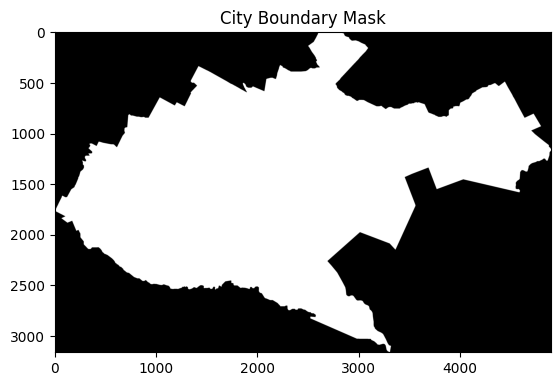

In [2]:
def read_mask(mask_path):
    with rasterio.open(mask_path) as mask_file:
        mask_array = mask_file.read(1)  # Read single band
    return mask_array

# 读取矢量文件
gdf = gpd.read_file(VECTOR_FILE)

# 读取栅格文件以获取变换信息和元数据
with rasterio.open(IMAGE_FILE) as src:
    transform = src.transform
    origin_lon, origin_lat = transform * (0, 0)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": src.height,
        "width": src.width,
        "transform": src.transform,
        "crs": src.crs,
        "count": 1,
        "dtype": 'uint8'
    })
    print(f"Origin (latitude, longitude): ({origin_lat}, {origin_lon})")

# 栅格化矢量边界
shapes = ((geom, 1) for geom in gdf.geometry)

with rasterio.open(MASK_FILE, 'w', **out_meta) as out_raster:
    out_raster.write(rasterize(shapes, out_shape=(src.height, src.width), transform=src.transform, fill=0, all_touched=True, dtype='uint8'), indexes=1)

# 检查栅格掩膜文件
mask = read_mask(MASK_FILE)
plt.imshow(mask, cmap='gray')
plt.title('City Boundary Mask')
plt.show()


def read_image(image_path, bands=[2, 3, 4, 8], normalize=False):
    with rasterio.open(image_path) as image_file:
        height, width = image_file.height, image_file.width
        image_array = np.empty((height, width, len(bands)))
        for i, band_idx in enumerate(bands):
            band_array = image_file.read(band_idx)
            if normalize:
                min_value = np.percentile(band_array, 2)
                max_value = np.percentile(band_array, 98)
                band_array = (band_array - min_value) / (max_value - min_value)
                band_array = np.clip(band_array, 0, 1)  # Ensure within 0-1 range
            image_array[:, :, i] = band_array
    return image_array


def map_classes(labels_array, mapping=CLASS_MAPPING):
    labels_mapped = np.zeros_like(labels_array)
    for class_idx, target_idx in mapping.items():
        labels_mapped[labels_array == class_idx] = target_idx
    return labels_mapped


def read_label(label_path):
    with rasterio.open(label_path) as label_file:
        label_array = label_file.read(1)  # Read single band
    label_array = np.where(label_array == -1, -1, label_array)  # Retain no_data value as -1
    label_array = map_classes(label_array).astype(int)  # Ensure labels are integers
    return label_array


def pad_to_patch_size(arr, patch_size=PATCH_SIZE, pad_value=0):
    height, width = arr.shape[:2]
    target_height = patch_size * int(np.ceil(height / patch_size))
    target_width = patch_size * int(np.ceil(width / patch_size))
    pad_height = target_height - height
    pad_width = target_width - width

    if arr.ndim == 3:
        depth = arr.shape[2]
        padded = np.full((target_height, target_width, depth), pad_value, dtype=arr.dtype)
    else:
        padded = np.full((target_height, target_width), pad_value, dtype=arr.dtype)

    padded[:height, :width] = arr
    return padded, (pad_height, pad_width)


def extract_patches(image, label, mask, patch_size=PATCH_SIZE, label_patch_size=LABEL_PATCH_SIZE):
    image, _ = pad_to_patch_size(image, patch_size, pad_value = 0)
    label, _ = pad_to_patch_size(label, label_patch_size, pad_value = 0)  # Adjust for 80m resolution
    mask, _ = pad_to_patch_size(mask, patch_size, pad_value = 0)

    img_patches = []
    lbl_patches = []
    mask_patches = []
    patch_coords = []
    patch_bounds = []

    height, width, _ = image.shape
    label_height, label_width = label.shape

    for i in range(0, height - patch_size + 1, patch_size):
        for j in range(0, width - patch_size + 1, patch_size):
            img_patch = image[i:i+patch_size, j:j+patch_size, :]
            lbl_patch = label[(i//8):(i//8)+label_patch_size, (j//8):(j//8)+label_patch_size]  # Adjust for 80m resolution
            mask_patch = mask[i:i+patch_size, j:j+patch_size]

            img_patches.append(img_patch)
            lbl_patches.append(lbl_patch)
            mask_patches.append(mask_patch)
            patch_coords.append((i // patch_size, j // patch_size))

            if transform:
                # 计算patch边界坐标
                top_left = transform * (j, i)
                top_right = transform * (j + patch_size, i)
                bottom_left = transform * (j, i + patch_size)
                bottom_right = transform * (j + patch_size, i + patch_size)
                patch_bounds.append([top_left, top_right, bottom_right, bottom_left])

    return np.array(img_patches), np.array(lbl_patches), np.array(mask_patches), patch_coords, patch_bounds


def ensure_all_classes_present(labels, num_classes=CLASSES_COUNT):
    unique_classes = set()
    for lbl_patch in labels:
        unique_classes.update(np.unique(lbl_patch))
    return len(unique_classes) == num_classes


def labels_to_onehot(labels_arr, num_classes=CLASSES_COUNT):
    height, width = labels_arr.shape
    labels_onehot = np.zeros((height, width, num_classes))
    for class_idx in range(num_classes):
        labels_onehot[:, :, class_idx][labels_arr == class_idx] = 1
    return labels_onehot


def split_patches(img_patches, lbl_patches, mask_patches, patch_coords, patch_bounds, train_size=0.6, val_size=0.2, test_size=0.2):
    inside_patches = [(img, lbl, mask, coord, bound) for img, lbl, mask, coord, bound in zip(img_patches, lbl_patches, mask_patches, patch_coords, patch_bounds) if np.any(mask != 0)]
    outside_patches = [(img, lbl, mask, coord, bound) for img, lbl, mask, coord, bound in zip(img_patches, lbl_patches, mask_patches, patch_coords, patch_bounds) if np.all(mask == 0)]

    if inside_patches:
        inside_img_patches, inside_lbl_patches, inside_mask_patches, inside_patch_coords, inside_patch_bounds = zip(*inside_patches)
    else:
        inside_img_patches, inside_lbl_patches, inside_mask_patches, inside_patch_coords, inside_patch_bounds = [], [], [], [], []

    if outside_patches:
        outside_img_patches, outside_lbl_patches, outside_mask_patches, outside_patch_coords, outside_patch_bounds = zip(*outside_patches)
    else:
        outside_img_patches, outside_lbl_patches, outside_mask_patches, outside_patch_coords, outside_patch_bounds = [], [], [], [], []

    inside_img_patches = np.array(inside_img_patches)
    inside_lbl_patches = np.array(inside_lbl_patches)
    inside_mask_patches = np.array(inside_mask_patches)
    inside_patch_coords = np.array(inside_patch_coords)
    inside_patch_bounds = np.array(inside_patch_bounds)

    # Flatten labels and include all values
    flat_labels = [lbl.flatten() for lbl in inside_lbl_patches]
    flat_labels = [label[0] if len(label) > 0 else 0 for label in flat_labels]  # Handle empty labels

    # Perform initial split with stratification
    X_train, X_temp, y_train, y_temp, mask_train, mask_temp, train_coords, temp_coords, train_bounds, temp_bounds = train_test_split(
        inside_img_patches, inside_lbl_patches, inside_mask_patches, inside_patch_coords, inside_patch_bounds, test_size=(1 - train_size), random_state=42, stratify=flat_labels)

    flat_temp_labels = [lbl.flatten() for lbl in y_temp]
    flat_temp_labels = [label[0] if len(label) > 0 else 0 for label in flat_temp_labels]  # Handle empty labels

    X_val, X_test, y_val, y_test, mask_val, mask_test, val_coords, test_coords, val_bounds, test_bounds = train_test_split(
        X_temp, y_temp, mask_temp, temp_coords, temp_bounds, test_size=test_size / (val_size + test_size), random_state=42, stratify=flat_temp_labels)

    while not (ensure_all_classes_present(y_train, num_classes=2) and ensure_all_classes_present(y_val, num_classes=2) and ensure_all_classes_present(y_test, num_classes=2)):
        X_train, X_temp, y_train, y_temp, mask_train, mask_temp, train_coords, temp_coords, train_bounds, temp_bounds = train_test_split(
            np.concatenate((X_train, X_temp)), np.concatenate((y_train, y_temp)), np.concatenate((mask_train, mask_temp)),
            np.concatenate((train_coords, temp_coords)), np.concatenate((train_bounds, temp_bounds)), test_size=(1 - train_size), random_state=42)
        
        flat_temp_labels = [lbl.flatten() for lbl in y_temp]
        flat_temp_labels = [label[0] if len(label) > 0 else 0 for label in flat_temp_labels]  # Handle empty labels

        X_val, X_test, y_val, y_test, mask_val, mask_test, val_coords, test_coords, val_bounds, test_bounds = train_test_split(
            X_temp, y_temp, mask_temp, temp_coords, temp_bounds, test_size=test_size / (val_size + test_size), random_state=42, stratify=flat_temp_labels)

    outside_img_patches = np.array(outside_img_patches, dtype=object)
    outside_lbl_patches = np.array(outside_lbl_patches, dtype=object)
    outside_mask_patches = np.array(outside_mask_patches, dtype=object)
    outside_patch_coords = np.array(outside_patch_coords, dtype=object)

    return X_train, X_val, X_test, outside_img_patches, y_train, y_val, y_test, outside_lbl_patches, mask_train, mask_val, mask_test, outside_mask_patches, train_coords, val_coords, test_coords, train_bounds, val_bounds, test_bounds, outside_patch_coords

In [3]:
# Read data
image = read_image(IMAGE_FILE, normalize=True)
label = read_label(LABEL_FILE)
mask = read_mask(MASK_FILE)  # 读取城市边界掩膜

# Check image, label, and mask sizes
print(f'Image size: {image.shape}')
print(f'Label size: {label.shape}')
print(f'Mask size: {mask.shape}')

# Extract patches
img_patches, lbl_patches, mask_patches, patch_coords, patch_bounds = extract_patches(image, label, mask)

# Split patches
X_train, X_val, X_test, X_out, y_train, y_val, y_test, y_out, mask_train, mask_val, mask_test, mask_out, train_coords, val_coords, test_coords, train_bounds, val_bounds, test_bounds, out_coords = split_patches(
    img_patches, lbl_patches, mask_patches, patch_coords, patch_bounds)

# Print the number of patches in each dataset
print(f'Total patches: {len(img_patches)}')
print(f'Training patches: {len(X_train)}')
print(f'Validation patches: {len(X_val)}')
print(f'Test patches: {len(X_test)}')
print(f'Out patches: {len(X_out)}')

Image size: (3160, 4897, 4)
Label size: (394, 611)
Mask size: (3160, 4897)
Total patches: 975
Training patches: 306
Validation patches: 102
Test patches: 102
Out patches: 465


In [4]:
import pandas as pd
from pyproj import Transformer

REFERENCE_MAP_PATH = LABEL_FILE
GSV_path = '/home/jovyan/private/Research_thesis/Streetview_branch/Nrb_GSV/Nrb_images/Nrb_images/'

# 读取参考地图
with rasterio.open(REFERENCE_MAP_PATH) as src:
    reference_map = src.read(1)
    reference_transform = src.transform

# 定义坐标转换器
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

# 将经纬度转换为参考地图的坐标系
def lonlat_to_pixel(lon, lat, transform, transformer):
    x, y = transformer.transform(lon, lat)
    col, row = ~transform * (x, y)
    return int(col), int(row)

In [5]:
# 解析图像文件名并获取经纬度
def parse_filename(filename):
    parts = filename[:-4].split('_')
    if len(parts) == 3:
        fid = parts[0]
        lon = float(parts[1])
        lat = float(parts[2])
        return fid, lon, lat
    else:
        raise ValueError(f"Filename {filename} does not match expected pattern.")

# 测试解析函数
filename = "12345_36.8219_-1.2921.jpg"
try:
    fid, lon, lat = parse_filename(filename)
    print(f"FID: {fid}, Longitude: {lon}, Latitude: {lat}")
except ValueError as e:
    print(e)

# 读取图像文件名并提取经纬度
image_files = [f for f in os.listdir(GSV_path) if f.endswith('.jpg')]
image_data = []

for image_file in image_files:
    fid, lon, lat = parse_filename(image_file)
    image_data.append((image_file, fid, lon, lat))

# 将数据转换为DataFrame
image_df = pd.DataFrame(image_data, columns=['filename', 'fid', 'longitude', 'latitude'])

FID: 12345, Longitude: 36.8219, Latitude: -1.2921


In [6]:
# 根据参考地图分类图像
def classify_image(lon, lat, reference_map, transform, transformer):
    col, row = lonlat_to_pixel(lon, lat, transform, transformer)
    if 0 <= row < reference_map.shape[0] and 0 <= col < reference_map.shape[1]:
        value = reference_map[row, col]
        if value == 0:
            return 'non slum'
        elif value == 1:
            return 'slum'
    return 'out'

image_df['category'] = image_df.apply(lambda x: classify_image(x['longitude'], x['latitude'], reference_map, reference_transform, transformer), axis=1)

# 输出每个label的街景图像数量
label_counts = image_df['category'].value_counts()
print("Street view image counts per category:")
print(label_counts)

Street view image counts per category:
non slum    28147
slum         5897
Name: category, dtype: int64


In [7]:
from shapely.geometry import Point, Polygon
from pyproj import Transformer

# 初始化转换器
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

def classify_image_by_region(lon, lat, train_bounds, val_bounds, test_bounds, transformer):
    
    x, y = transformer.transform(lat, lon)
    point = Point(x, y)
    
    for bounds in train_bounds:
        polygon = Polygon(bounds)
        if polygon.contains(point):
            return 'train'
    for bounds in val_bounds:
        polygon = Polygon(bounds)
        if polygon.contains(point):
            return 'val'
    for bounds in test_bounds:
        polygon = Polygon(bounds)
        if polygon.contains(point):
            return 'test'
    return None


# 将边界转换为Polygon对象
train_polygons = [Polygon(bounds) for bounds in train_bounds]
val_polygons = [Polygon(bounds) for bounds in val_bounds]
test_polygons = [Polygon(bounds) for bounds in test_bounds]


train_images = []
val_images = []
test_images = []

for _, row in image_df.iterrows():
    lon, lat = row['longitude'], row['latitude']
    label = row['category']
    region = classify_image_by_region(lon, lat, train_bounds, val_bounds, test_bounds, transformer)
    if region == 'train':
        train_images.append((row['filename'], label))
    elif region == 'val':
        val_images.append((row['filename'], label))
    elif region == 'test':
        test_images.append((row['filename'], label))


# 输出数据集大小
print(f"Train set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(test_images)} images")

# 验证总数
total_images = len(train_images) + len(val_images) + len(test_images)
print(f"Total images: {total_images}")

Train set: 20192 images
Validation set: 6231 images
Test set: 7621 images
Total images: 34044


In [8]:
Sentinel2_featuresfile_train = os.path.join(ROOT_DIR, "train_s2_features.npy")
Sentinel2_featuresfile_val = os.path.join(ROOT_DIR, "val_s2_features.npy")
Sentinel2_featuresfile_test = os.path.join(ROOT_DIR, "test_s2_features.npy")

s2_features_train = np.load(Sentinel2_featuresfile_train)
s2_features_val = np.load(Sentinel2_featuresfile_val)
s2_features_test = np.load(Sentinel2_featuresfile_test)

In [9]:
print(s2_features_train.shape)
print(s2_features_val.shape)
print(s2_features_test.shape)

(306, 16, 16, 256)
(102, 16, 16, 256)
(102, 16, 16, 256)


In [10]:
test_fused_features = np.load("test_fused_features_80m.npy")
test_pixel_labels = np.load("test_pixel_labels_80m.npy")
val_fused_features = np.load("val_fused_features_80m.npy")
val_pixel_labels = np.load("val_pixel_labels_80m.npy")
train_fused_features = np.load("train_fused_features_80m.npy")
train_pixel_labels = np.load("train_pixel_labels_80m.npy")

print(f"Shape of test_fused_features: {test_fused_features.shape}")
print(f"Shape of test_pixel_labels: {test_pixel_labels.shape}")
print(f"Shape of val_fused_features: {val_fused_features.shape}")
print(f"Shape of val_pixel_labels: {val_pixel_labels.shape}")
print(f"Shape of train_fused_features: {train_fused_features.shape}")
print(f"Shape of train_pixel_labels: {train_pixel_labels.shape}")

Shape of test_fused_features: (26112, 2048)
Shape of test_pixel_labels: (26112,)
Shape of val_fused_features: (26112, 2048)
Shape of val_pixel_labels: (26112,)
Shape of train_fused_features: (78336, 2048)
Shape of train_pixel_labels: (78336,)


In [11]:
# 获取分类数和特征形状
num_classes = len(np.unique(y_train))
s2_feature_shape = s2_features_train.shape[-1]
fused_feature_shape = train_fused_features.shape[-1]

print(f"Number of classes: {num_classes}")
print(f"Sentinel2 feature shape: {s2_feature_shape}")
print(f"Fused feature shape: {fused_feature_shape}")

Number of classes: 2
Sentinel2 feature shape: 256
Fused feature shape: 2048


In [12]:
num_images_train = train_fused_features.shape[0] // 256
num_images_val = val_fused_features.shape[0] // 256
num_images_test = test_fused_features.shape[0] // 256

fused_features_train = train_fused_features.reshape(num_images_train, 16, 16, fused_feature_shape)
fused_features_val = val_fused_features.reshape(num_images_val, 16, 16, fused_feature_shape)
fused_features_test = test_fused_features.reshape(num_images_test, 16, 16, fused_feature_shape)

print(f"Shape of fused_features_train: {fused_features_train.shape}")
# print(f"Shape of labels_train: {labels_train.shape}")
print(f"Shape of fused_features_val: {fused_features_val.shape}")
# print(f"Shape of labels_val: {labels_val.shape}")
print(f"Shape of fused_features_test: {fused_features_test.shape}")
# print(f"Shape of labels_test: {labels_test.shape}")

Shape of fused_features_train: (306, 16, 16, 2048)
Shape of fused_features_val: (102, 16, 16, 2048)
Shape of fused_features_test: (102, 16, 16, 2048)


In [13]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


def convert_to_one_hot(labels, num_classes):
    """ 转换标签为one-hot编码格式 """
    one_hot_labels = tf.one_hot(labels, depth=num_classes)
    return one_hot_labels


# 将标签转换为 one-hot 编码
labels_train = convert_to_one_hot(y_train, num_classes)
labels_val = convert_to_one_hot(y_val, num_classes)
labels_test = convert_to_one_hot(y_test, num_classes)

print(f"Shape of labels_train: {labels_train.shape}")
print(f"Shape of labels_val: {labels_val.shape}")
print(f"Shape of labels_test: {labels_test.shape}")

(306, 16, 16)
(102, 16, 16)
(102, 16, 16)
(306, 128, 128, 4)
(102, 128, 128, 4)
(102, 128, 128, 4)
Shape of labels_train: (306, 16, 16, 2)
Shape of labels_val: (102, 16, 16, 2)
Shape of labels_test: (102, 16, 16, 2)


2024-08-14 13:05:24.590283: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [14]:
s2_input_shape = (16, 16, s2_feature_shape)
s2_output_channels = num_classes

fused_input_shape = (16, 16, fused_feature_shape)
fused_output_channels = num_classes

In [28]:
def build_main_model(input_shape, output_channels):
    inputs = layers.Input(shape=input_shape)

    # 使用卷积层提取特征，同时加入Batch Normalization和Dropout

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # 使用1x1卷积层将特征图映射到输出通道数
    outputs = layers.Conv2D(output_channels, (1, 1), activation='softmax', padding='same')(x)

    model = models.Model(inputs, outputs)
    return model

In [16]:
from tensorflow.keras import layers, models, backend as K


def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    return K.mean(f1)


# 定义Focal Loss
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, y_pred.dtype)
        bce = K.binary_crossentropy(y_true, y_pred)
        bce_exp = K.exp(-bce)
        focal_loss = alpha * K.pow((1 - bce_exp), gamma) * bce
        return K.mean(focal_loss)
    return loss

In [17]:
import tensorflow_addons as tfa

# 构建和编译模型
s2_model = build_main_model(s2_input_shape, s2_output_channels)

s2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss=focal_loss(),
                 metrics=['accuracy',
                 f1_score,
                 tf.keras.metrics.MeanIoU(num_classes=num_classes)])

# 打印模型结构
s2_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 256)]     0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 2)         258       
                                                                 
Total params: 295,810
Trainable params: 295,554
Non-trainable params: 256
_____________________________________________________

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Epoch 1/50
20/20 [==============================] - 6s 68ms/step - loss: 0.0446 - accuracy: 0.5768 - f1_score: 0.4248 - mean_io_u: 0.2500 - val_loss: 0.0422 - val_accuracy: 0.9446 - val_f1_score: 0.4869 - val_mean_io_u: 0.2500
Epoch 2/50
20/20 [==============================] - 0s 14ms/step - loss: 0.0420 - accuracy: 0.6541 - f1_score: 0.4776 - mean_io_u: 0.2500 - val_loss: 0.0410 - val_accuracy: 0.9446 - val_f1_score: 0.4867 - val_mean_io_u: 0.2500
Epoch 3/50
20/20 [==============================] - 0s 15ms/step - loss: 0.0401 - accuracy: 0.7176 - f1_score: 0.5183 - mean_io_u: 0.2500 - val_loss: 0.0400 - val_accuracy: 0.9446 - val_f1_score: 0.4867 - val_mean_io_u: 0.2500
Epoch 4/50
20/20 [==============================] - 0s 15ms/step - loss: 0.0386 - accuracy: 0.7646 - f1_score: 0.5430 - mean_io_u: 0.2500 - val_loss: 0.0385 - val_accuracy: 0.9446 - val_f1_score: 0.4867 - val_mean_io_u: 0.2500
Epoch 5/50
20/20 [==============================] - 0s 15ms/step - loss: 0.0369 - accuracy: 

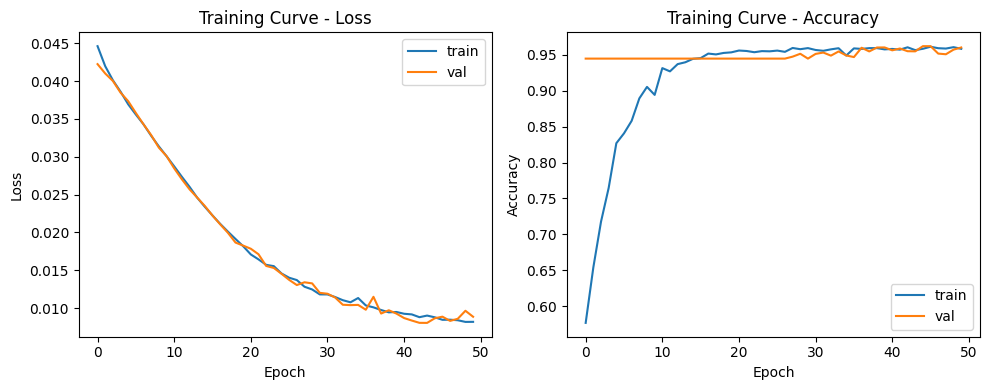

In [18]:
# 训练模型
s2_history = s2_model.fit(
    s2_features_train, labels_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=(s2_features_val, labels_val)
)

# 绘制训练曲线
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].set_title("Training Curve - Loss")
axs[0].plot(s2_history.history["loss"], label="train")
axs[0].plot(s2_history.history["val_loss"], label="val")
axs[0].legend()
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Epoch")

axs[1].set_title("Training Curve - Accuracy")
axs[1].plot(s2_history.history["accuracy"], label="train")
axs[1].plot(s2_history.history["val_accuracy"], label="val")
axs[1].legend()
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")

plt.tight_layout()
plt.show()

In [19]:
s2_results = s2_model.evaluate(s2_features_test, labels_test)
print(f"\nTest Loss: {s2_results[0]:.4f}")
print(f"Test Accuracy: {s2_results[1] * 100:.2f}%")
print(f"F1 Score: {s2_results[2]:.4f}")  # F1Score 类的结果
print(f"Mean IoU: {s2_results[3]:.4f}")  # MeanIoU 的结果

4/4 [==============================] - 0s 8ms/step - loss: 0.0113 - accuracy: 0.9362 - f1_score: 0.6305 - mean_io_u: 0.2500

Test Loss: 0.0113
Test Accuracy: 93.62%
F1 Score: 0.6305
Mean IoU: 0.2500


In [194]:
s2_valresults = s2_model.evaluate(s2_features_val, labels_val)
print(f"\nValidation Loss: {s2_valresults[0]:.4f}")
print(f"Validation Accuracy: {s2_valresults[1] * 100:.2f}%")
print(f"Validation F1 Score: {s2_valresults[2]:.4f}")  # F1Score 类的结果
print(f"Validation Mean IoU: {s2_valresults[3]:.4f}")  # MeanIoU 的结果

4/4 [==============================] - 0s 8ms/step - loss: 0.0089 - accuracy: 0.9601 - f1_score: 0.6921 - mean_io_u: 0.2500

Validation Loss: 0.0089
Validation Accuracy: 96.01%
Validation F1 Score: 0.6921
Validation Mean IoU: 0.2500


In [195]:
s2_trainresults = s2_model.evaluate(s2_features_train, labels_train)
print(f"\nTrain Loss: {s2_trainresults[0]:.4f}")
print(f"Train Accuracy: {s2_trainresults[1] * 100:.2f}%")
print(f"Train F1 Score: {s2_trainresults[2]:.4f}")  # F1Score 类的结果
print(f"Train Mean IoU: {s2_trainresults[3]:.4f}")  # MeanIoU 的结果

10/10 [==============================] - 0s 8ms/step - loss: 0.0090 - accuracy: 0.9588 - f1_score: 0.7356 - mean_io_u: 0.2500

Train Loss: 0.0090
Train Accuracy: 95.88%
Train F1 Score: 0.7356
Train Mean IoU: 0.2500


4/4 [==============================] - 0s 5ms/step
Overall Classification Report on Sentinel-2:
              precision    recall  f1-score   support

    Non-slum       0.98      0.97      0.98    123154
        Slum       0.59      0.63      0.61      7406

    accuracy                           0.95    130560
   macro avg       0.79      0.80      0.79    130560
weighted avg       0.96      0.95      0.96    130560

Confusion Matrix on Sentinel-2
[[119976   3178]
 [  2760   4646]]


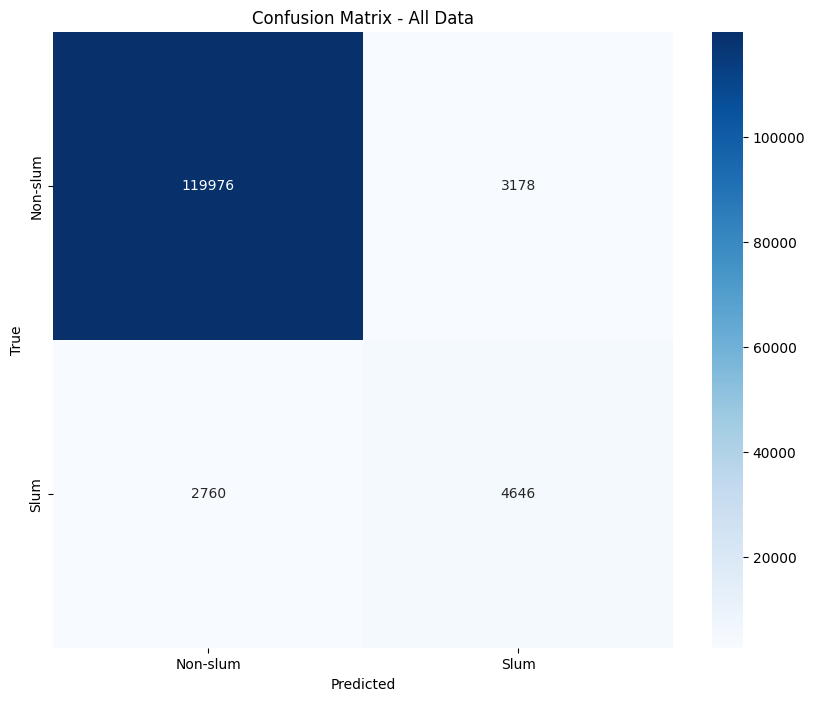

In [193]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 获取预测结果
s2_train_predictions = s2_model.predict(s2_features_train)
s2_val_predictions = s2_model.predict(s2_features_val)
s2_test_predictions = s2_model.predict(s2_features_test)

# 获取预测类别
s2_train_pred_classes = np.argmax(s2_train_predictions, axis=-1).flatten()
s2_val_pred_classes = np.argmax(s2_val_predictions, axis=-1).flatten()
s2_test_pred_classes = np.argmax(s2_test_predictions, axis=-1).flatten()

# 获取真实类别
s2_train_true_classes = np.argmax(labels_train, axis=-1).flatten()
s2_val_true_classes = np.argmax(labels_val, axis=-1).flatten()
s2_test_true_classes = np.argmax(labels_test, axis=-1).flatten()

# 组合所有预测结果和真实标签
s2_all_pred_classes = np.concatenate([s2_train_pred_classes, s2_val_pred_classes, s2_test_pred_classes], axis=0)
s2_all_true_classes = np.concatenate([s2_train_true_classes, s2_val_true_classes, s2_test_true_classes], axis=0)

# 计算整体混淆矩阵
s2_overall_cm = confusion_matrix(s2_all_true_classes, s2_all_pred_classes)

# 输出整体分类报告
class_labels = ['Non-slum', 'Slum']
s2_overall_report = classification_report(s2_all_true_classes, s2_all_pred_classes, target_names=class_labels, zero_division=1)
print("Overall Classification Report on Sentinel-2:")
print(s2_overall_report)

print("Confusion Matrix on Sentinel-2")
print(s2_overall_cm)


# 可视化整体混淆矩阵
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - All Data')
    plt.show()


plot_confusion_matrix(s2_overall_cm)

In [176]:
# 获取预测结果
s2_train_predictions = s2_model.predict(s2_features_train)
s2_val_predictions = s2_model.predict(s2_features_val)
s2_test_predictions = s2_model.predict(s2_features_test)

# 获取预测类别
s2_train_pred_classes = np.argmax(s2_train_predictions, axis=-1)
s2_val_pred_classes = np.argmax(s2_val_predictions, axis=-1)
s2_test_pred_classes = np.argmax(s2_test_predictions, axis=-1)

# 获取真实类别
s2_train_true_classes = np.argmax(labels_train, axis=-1)
s2_val_true_classes = np.argmax(labels_val, axis=-1)
s2_test_true_classes = np.argmax(labels_test, axis=-1)

print(s2_train_pred_classes.shape)
print(s2_val_pred_classes.shape)
print(s2_test_pred_classes.shape)
print(s2_train_true_classes.shape)
print(s2_val_true_classes.shape)
print(s2_test_true_classes.shape)

4/4 [==============================] - 0s 5ms/step
(306, 16, 16)
(102, 16, 16)
(102, 16, 16)
(306, 16, 16)
(102, 16, 16)
(102, 16, 16)


Skipping patch at (9, 38) due to shape mismatch: (16, 3) vs (16, 16)
Skipping patch at (24, 24) due to shape mismatch: (10, 16) vs (16, 16)
Skipping patch at (8, 38) due to shape mismatch: (16, 3) vs (16, 16)
Skipping patch at (24, 25) due to shape mismatch: (10, 16) vs (16, 16)


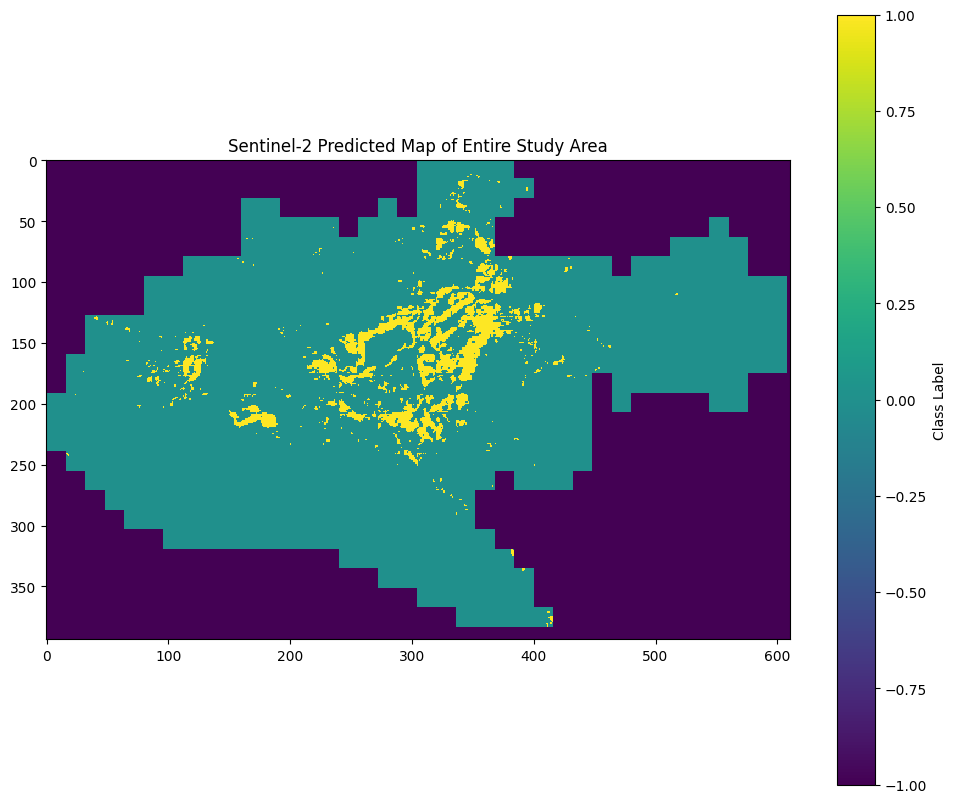

In [185]:
# 研究区的全局地图尺寸（基于标签数据）
global_map_shape = (394, 611)  # 对应的是80m分辨率下的研究区尺寸
global_prediction_map_s2 = np.full(global_map_shape, -1)  # 初始化全局预测地图

label_patch_size = 16  # 预测结果的patch大小（16x16）

# 获取预测类别
s2_train_pred_classes = np.argmax(s2_train_predictions, axis=-1)  # 转换为类别标签
s2_val_pred_classes = np.argmax(s2_val_predictions, axis=-1)      # 转换为类别标签
s2_test_pred_classes = np.argmax(s2_test_predictions, axis=-1)    # 转换为类别标签

# 确保填充到全局地图中的每个预测结果是单类别的二维标签图
def fill_global_map(global_map, predictions, coords, label_patch_size):
    for pred, coord in zip(predictions, coords):
        x, y = coord
        # 确保填充区域的大小和预测结果一致
        global_patch = global_map[x*label_patch_size:(x+1)*label_patch_size, y*label_patch_size:(y+1)*label_patch_size]
        if global_patch.shape == pred.shape:
            global_map[x*label_patch_size:(x+1)*label_patch_size, y*label_patch_size:(y+1)*label_patch_size] = pred
        else:
            print(f"Skipping patch at ({x}, {y}) due to shape mismatch: {global_patch.shape} vs {pred.shape}")

# 填充训练、验证和测试数据的预测结果
fill_global_map(global_prediction_map_s2, s2_train_pred_classes, train_coords, label_patch_size)
fill_global_map(global_prediction_map_s2, s2_val_pred_classes, val_coords, label_patch_size)
fill_global_map(global_prediction_map_s2, s2_test_pred_classes, test_coords, label_patch_size)

# 可视化研究区的完整预测结果
plt.figure(figsize=(12, 10))
plt.imshow(global_prediction_map_s2, cmap='viridis', interpolation='none')  # 使用viridis颜色图，不进行插值
plt.colorbar(label='Class Label')
plt.title('Sentinel-2 Predicted Map of Entire Study Area')
plt.show()

In [102]:
# 创建U-Net模型
fused_model = build_main_model(fused_input_shape, fused_output_channels)


fused_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=focal_loss(),
                    metrics=['accuracy',
                    f1_score,
                    tf.keras.metrics.MeanIoU(num_classes=num_classes)])


fused_model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 16, 16, 2048)]    0         
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 128)       2359424   
                                                                 
 batch_normalization_20 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 2)         258       
                                                                 
Total params: 2,360,194
Trainable params: 2,359,938
Non-trainable params: 256
______________________________________________

Epoch 1/50
20/20 [==============================] - 1s 52ms/step - loss: 0.0069 - accuracy: 0.9584 - f1_score: 0.6304 - mean_io_u_20: 0.2510 - val_loss: 0.0068 - val_accuracy: 0.9635 - val_f1_score: 0.6736 - val_mean_io_u_20: 0.2505
Epoch 2/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0067 - accuracy: 0.9607 - f1_score: 0.6527 - mean_io_u_20: 0.2511 - val_loss: 0.0079 - val_accuracy: 0.9573 - val_f1_score: 0.6839 - val_mean_io_u_20: 0.2505
Epoch 3/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0068 - accuracy: 0.9596 - f1_score: 0.6332 - mean_io_u_20: 0.2511 - val_loss: 0.0073 - val_accuracy: 0.9589 - val_f1_score: 0.5863 - val_mean_io_u_20: 0.2505
Epoch 4/50
20/20 [==============================] - 1s 29ms/step - loss: 0.0077 - accuracy: 0.9543 - f1_score: 0.5975 - mean_io_u_20: 0.2510 - val_loss: 0.0075 - val_accuracy: 0.9589 - val_f1_score: 0.6786 - val_mean_io_u_20: 0.2505
Epoch 5/50
20/20 [==============================] - 1s 28ms/step - l

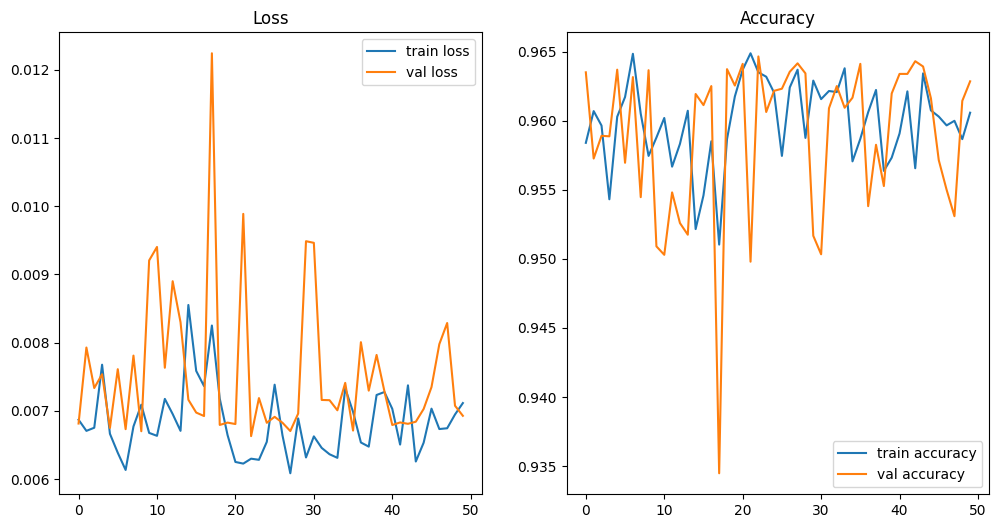

In [130]:
fused_history = fused_model.fit(
    fused_features_train, labels_train,
    epochs=50,
    batch_size=16,
    validation_data=(fused_features_val, labels_val),
    verbose=1
)

# 可视化训练曲线
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axs[0].plot(fused_history.history['loss'], label='train loss')
axs[0].plot(fused_history.history['val_loss'], label='val loss')
axs[0].legend()
axs[0].set_title('Loss')

axs[1].plot(fused_history.history['accuracy'], label='train accuracy')
axs[1].plot(fused_history.history['val_accuracy'], label='val accuracy')
axs[1].legend()
axs[1].set_title('Accuracy')

plt.show()

In [131]:
fused_results = fused_model.evaluate(fused_features_test, labels_test)
print(f"\nTest Loss: {fused_results[0]:.4f}")
print(f"Test Accuracy: {fused_results[1] * 100:.2f}%")
print(f"F1 Score: {fused_results[2]:.4f}")  # F1Score 类的结果
print(f"Mean IoU: {fused_results[3]:.4f}")  # MeanIoU 的结果

4/4 [==============================] - 0s 21ms/step - loss: 0.0091 - accuracy: 0.9487 - f1_score: 0.6434 - mean_io_u_20: 0.2513

Test Loss: 0.0091
Test Accuracy: 94.87%
F1 Score: 0.6434
Mean IoU: 0.2513


In [196]:
fused_valresults = fused_model.evaluate(fused_features_val, labels_val)
print(f"\nValidation Loss: {fused_valresults[0]:.4f}")
print(f"Validation Accuracy: {fused_valresults[1] * 100:.2f}%")
print(f"Validation F1 Score: {fused_valresults[2]:.4f}")  # F1Score 类的结果
print(f"Validation Mean IoU: {fused_valresults[3]:.4f}")  # MeanIoU 的结果

4/4 [==============================] - 0s 21ms/step - loss: 0.0069 - accuracy: 0.9629 - f1_score: 0.6990 - mean_io_u_20: 0.2505

Validation Loss: 0.0069
Validation Accuracy: 96.29%
Validation F1 Score: 0.6990
Validation Mean IoU: 0.2505


In [197]:
fused_trainresults = fused_model.evaluate(fused_features_train, labels_train)
print(f"\nTrain Loss: {fused_trainresults[0]:.4f}")
print(f"Train Accuracy: {fused_trainresults[1] * 100:.2f}%")
print(f"Train F1 Score: {fused_trainresults[2]:.4f}")  # F1Score 类的结果
print(f"Train Mean IoU: {fused_trainresults[3]:.4f}")  # MeanIoU 的结果

10/10 [==============================] - 0s 25ms/step - loss: 0.0056 - accuracy: 0.9674 - f1_score: 0.7738 - mean_io_u_20: 0.2512

Train Loss: 0.0056
Train Accuracy: 96.74%
Train F1 Score: 0.7738
Train Mean IoU: 0.2512


4/4 [==============================] - 0s 16ms/step
Overall Classification Report on Fused Features:
              precision    recall  f1-score   support

    Non-slum       0.98      0.98      0.98    123154
        Slum       0.68      0.65      0.66      7406

    accuracy                           0.96    130560
   macro avg       0.83      0.82      0.82    130560
weighted avg       0.96      0.96      0.96    130560

Confusion Matrix on Fused Features
[[120885   2269]
 [  2590   4816]]


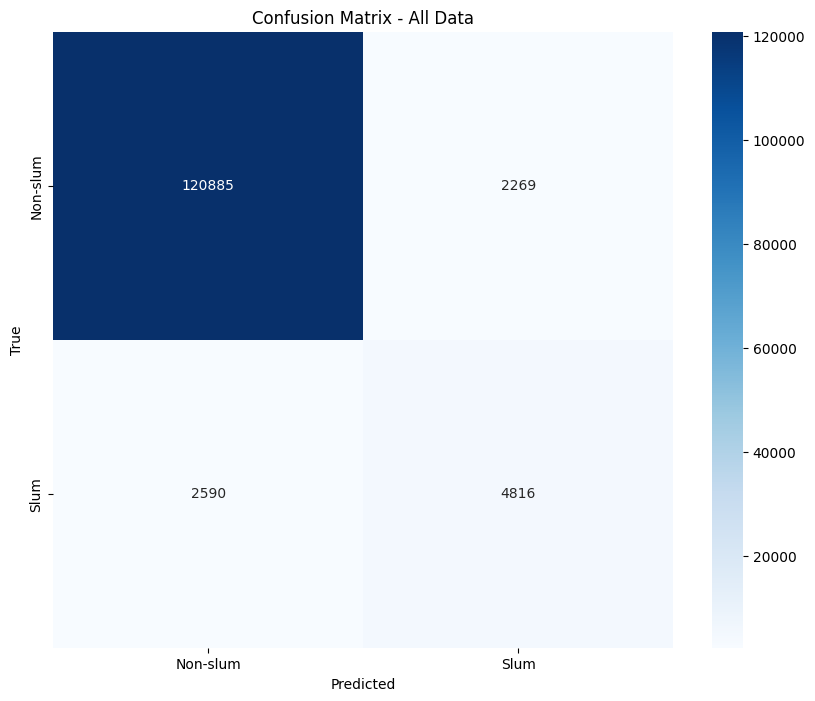

In [132]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 获取预测结果
fused_train_predictions = fused_model.predict(fused_features_train)
fused_val_predictions = fused_model.predict(fused_features_val)
fused_test_predictions = fused_model.predict(fused_features_test)

# 获取预测类别
fused_train_pred_classes = np.argmax(fused_train_predictions, axis=-1).flatten()
fused_val_pred_classes = np.argmax(fused_val_predictions, axis=-1).flatten()
fused_test_pred_classes = np.argmax(fused_test_predictions, axis=-1).flatten()

# 获取真实类别
fused_train_true_classes = np.argmax(labels_train, axis=-1).flatten()
fused_val_true_classes = np.argmax(labels_val, axis=-1).flatten()
fused_test_true_classes = np.argmax(labels_test, axis=-1).flatten()

# 组合所有预测结果和真实标签
fused_all_pred_classes = np.concatenate([fused_train_pred_classes, fused_val_pred_classes, fused_test_pred_classes], axis=0)
fused_all_true_classes = np.concatenate([fused_train_true_classes, fused_val_true_classes, fused_test_true_classes], axis=0)

# 计算整体混淆矩阵
fused_overall_cm = confusion_matrix(fused_all_true_classes, fused_all_pred_classes)

# 输出整体分类报告
class_labels = ['Non-slum', 'Slum']
fused_overall_report = classification_report(fused_all_true_classes, fused_all_pred_classes, target_names=class_labels, zero_division=1)
print("Overall Classification Report on Fused Features:")
print(fused_overall_report)

print("Confusion Matrix on Fused Features")
print(fused_overall_cm)


# 可视化整体混淆矩阵
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - All Data')
    plt.show()


plot_confusion_matrix(fused_overall_cm)

In [145]:
print(fused_test_predictions.shape)
print(s2_test_predictions.shape)
print(labels_test.shape)

(102, 16, 16, 2)
(102, 16, 16, 2)
(102, 16, 16, 2)


In [183]:
# 获取预测结果
fused_train_predictions = fused_model.predict(fused_features_train)
fused_val_predictions = fused_model.predict(fused_features_val)
fused_test_predictions = fused_model.predict(fused_features_test)

# 获取预测类别
fused_train_pred_classes = np.argmax(fused_train_predictions, axis=-1)
fused_val_pred_classes = np.argmax(fused_val_predictions, axis=-1)
fused_test_pred_classes = np.argmax(fused_test_predictions, axis=-1)

# 获取真实类别
fused_train_true_classes = np.argmax(labels_train, axis=-1)
fused_val_true_classes = np.argmax(labels_val, axis=-1)
fused_test_true_classes = np.argmax(labels_test, axis=-1)

print(fused_train_pred_classes.shape)
print(fused_val_pred_classes.shape)
print(fused_test_pred_classes.shape)
print(fused_train_true_classes.shape)
print(fused_val_true_classes.shape)
print(fused_test_true_classes.shape)

4/4 [==============================] - 0s 16ms/step
(306, 16, 16)
(102, 16, 16)
(102, 16, 16)
(306, 16, 16)
(102, 16, 16)
(102, 16, 16)


Skipping patch at (9, 38) due to shape mismatch: (16, 3) vs (16, 16)
Skipping patch at (24, 24) due to shape mismatch: (10, 16) vs (16, 16)
Skipping patch at (8, 38) due to shape mismatch: (16, 3) vs (16, 16)
Skipping patch at (24, 25) due to shape mismatch: (10, 16) vs (16, 16)


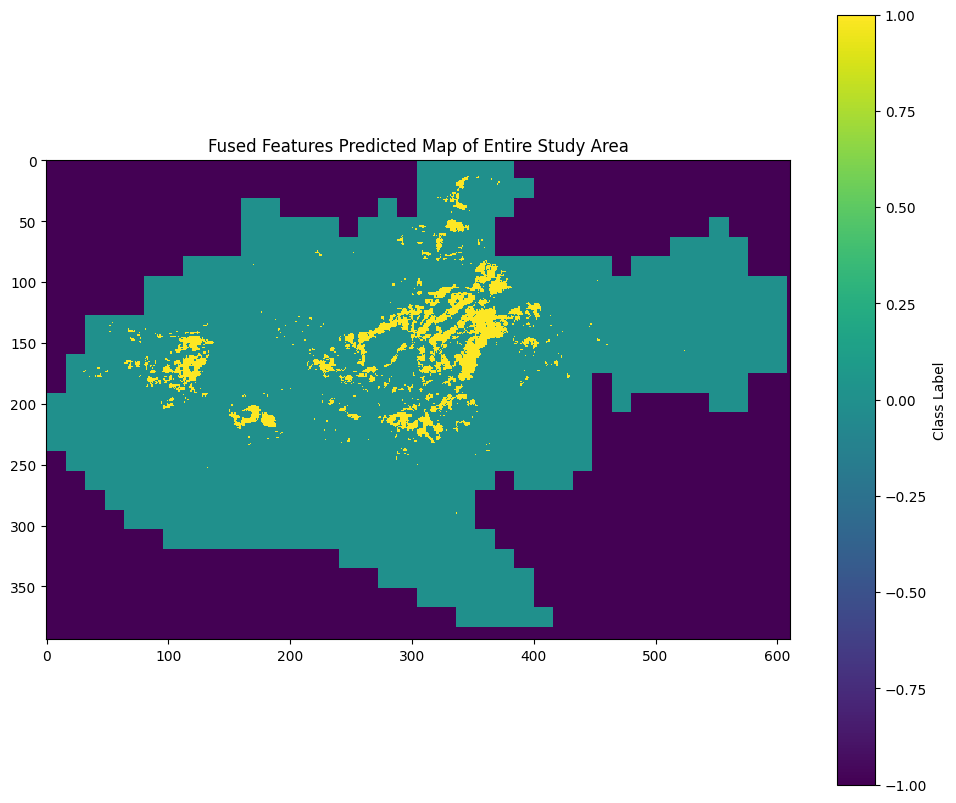

In [207]:
# 研究区的全局地图尺寸（基于标签数据）
global_map_shape = (394, 611)  # 对应的是80m分辨率下的研究区尺寸
global_prediction_map_fused = np.full(global_map_shape, -1)  # 初始化全局预测地图

label_patch_size = 16  # 预测结果的patch大小（16x16）

# 获取预测类别
fused_train_pred_classes = np.argmax(fused_train_predictions, axis=-1)  # 转换为类别标签
fused_val_pred_classes = np.argmax(fused_val_predictions, axis=-1)      # 转换为类别标签
fused_test_pred_classes = np.argmax(fused_test_predictions, axis=-1)    # 转换为类别标签

# 确保填充到全局地图中的每个预测结果是单类别的二维标签图
def fill_global_map(global_map, predictions, coords, label_patch_size):
    for pred, coord in zip(predictions, coords):
        x, y = coord
        # 确保填充区域的大小和预测结果一致
        global_patch = global_map[x*label_patch_size:(x+1)*label_patch_size, y*label_patch_size:(y+1)*label_patch_size]
        if global_patch.shape == pred.shape:
            global_map[x*label_patch_size:(x+1)*label_patch_size, y*label_patch_size:(y+1)*label_patch_size] = pred
        else:
            print(f"Skipping patch at ({x}, {y}) due to shape mismatch: {global_patch.shape} vs {pred.shape}")

# 填充训练、验证和测试数据的预测结果
fill_global_map(global_prediction_map_fused, fused_train_pred_classes, train_coords, label_patch_size)
fill_global_map(global_prediction_map_fused, fused_val_pred_classes, val_coords, label_patch_size)
fill_global_map(global_prediction_map_fused, fused_test_pred_classes, test_coords, label_patch_size)

# 可视化研究区的完整预测结果
plt.figure(figsize=(12, 10))
plt.imshow(global_prediction_map_fused, cmap='viridis', interpolation='none')  # 使用viridis颜色图，不进行插值
plt.colorbar(label='Class Label')
plt.title('Fused Features Predicted Map of Entire Study Area')
plt.show()

Visualizing Slum Patches in Training Set


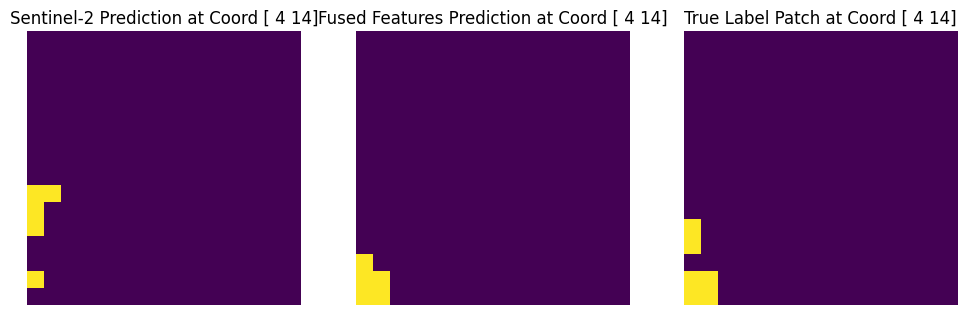

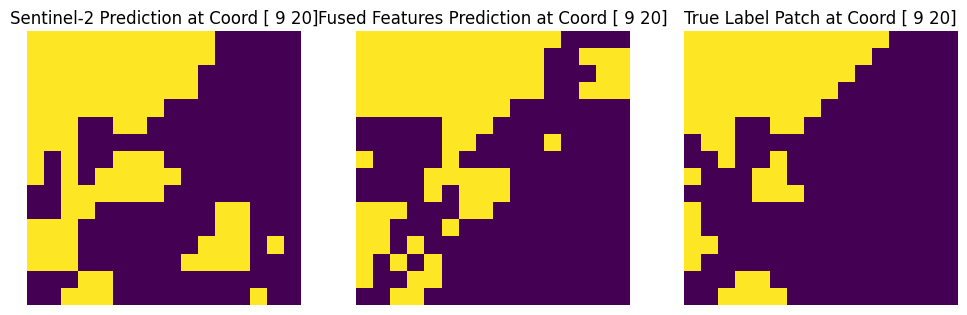

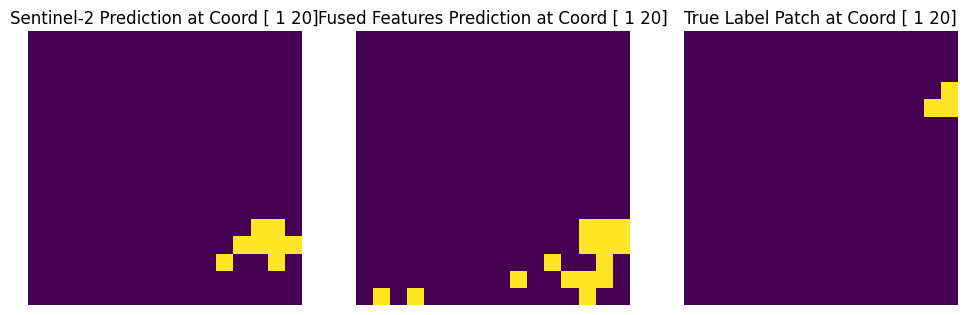

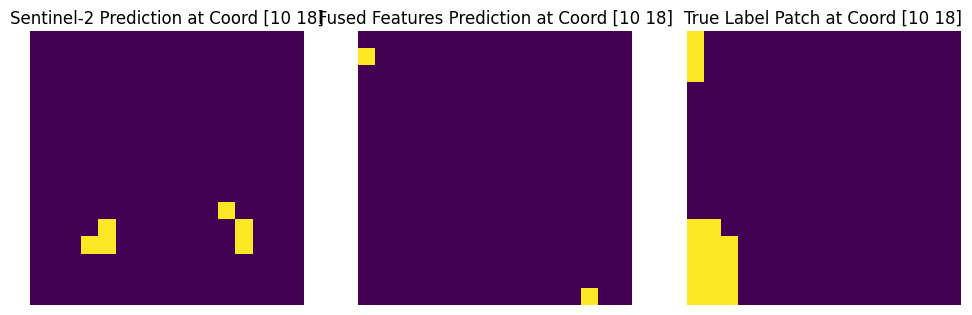

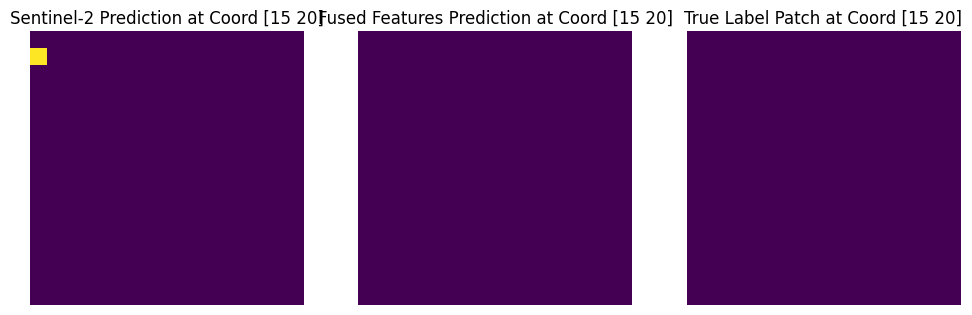

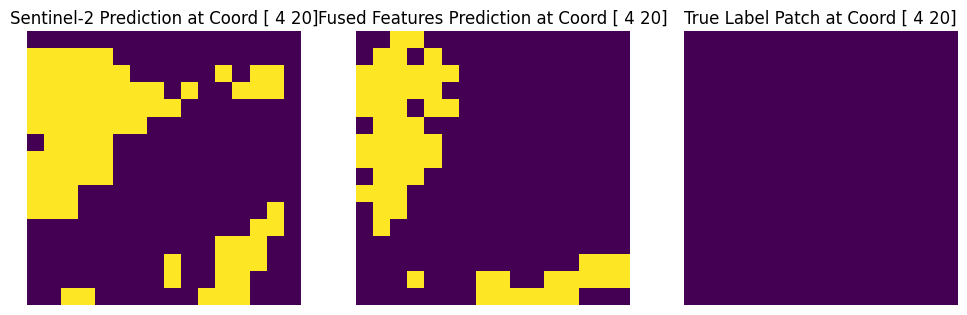

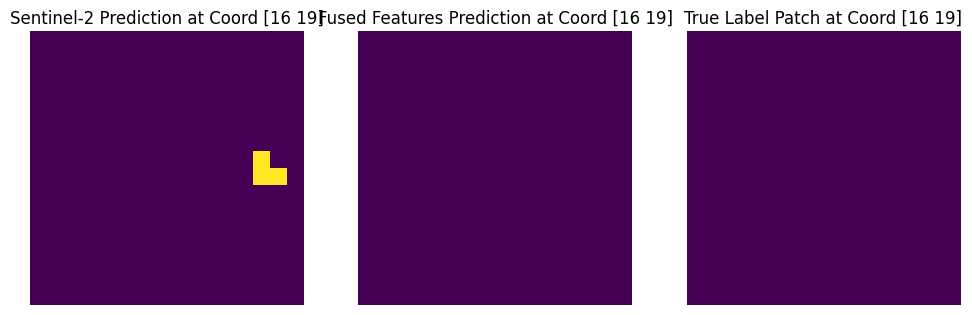

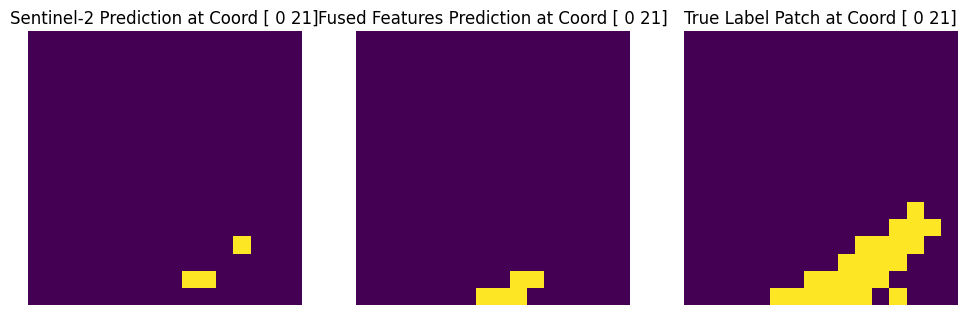

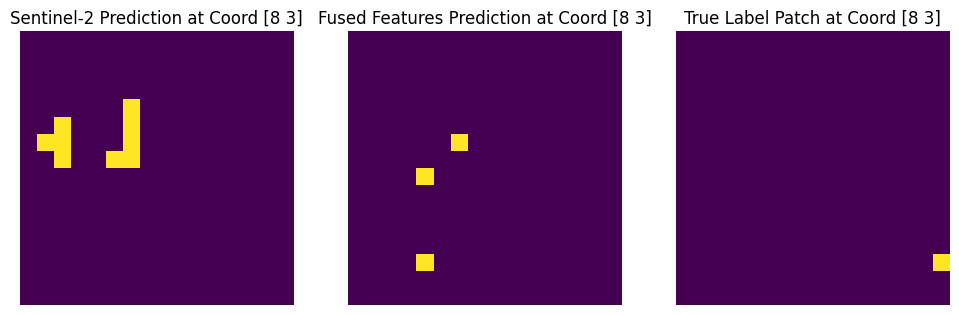

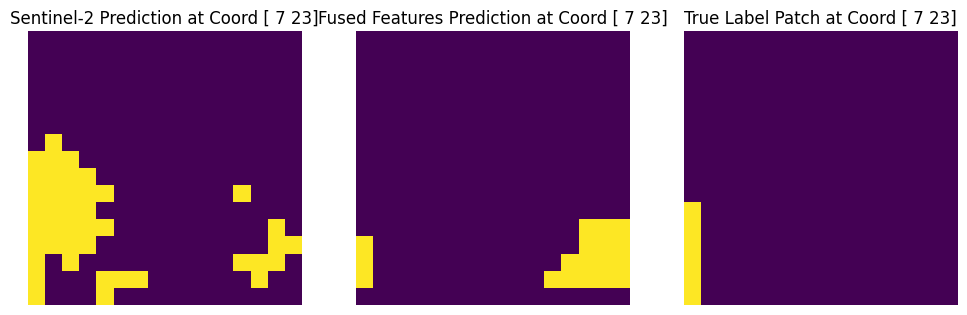

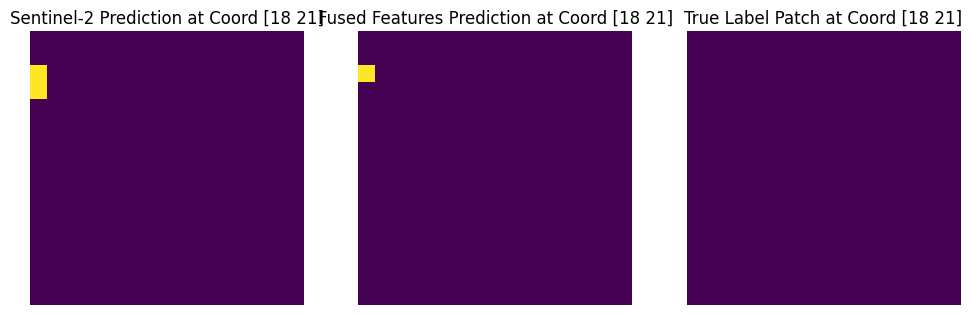

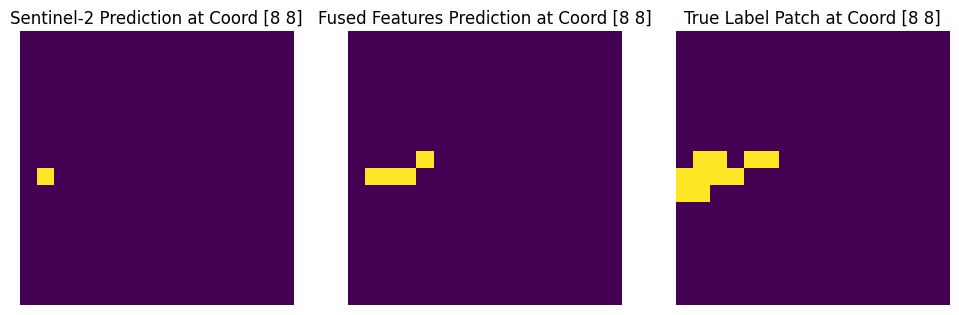

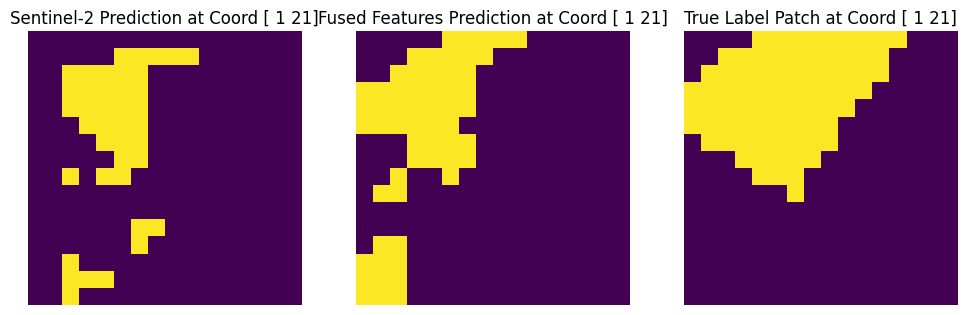

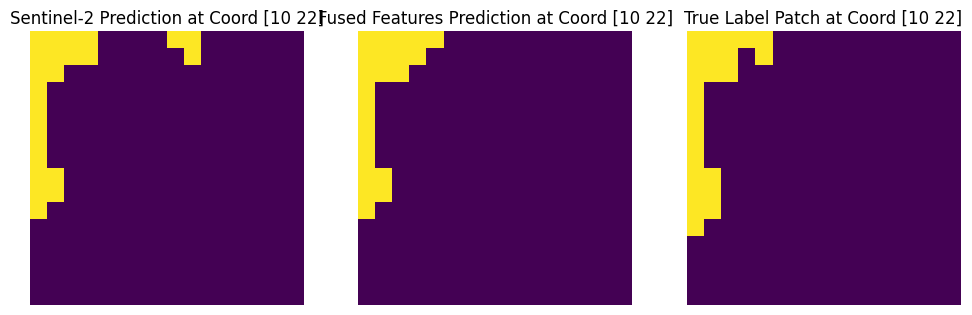

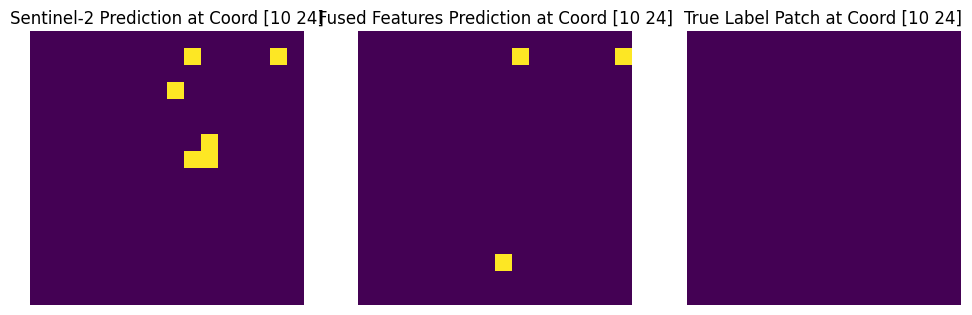

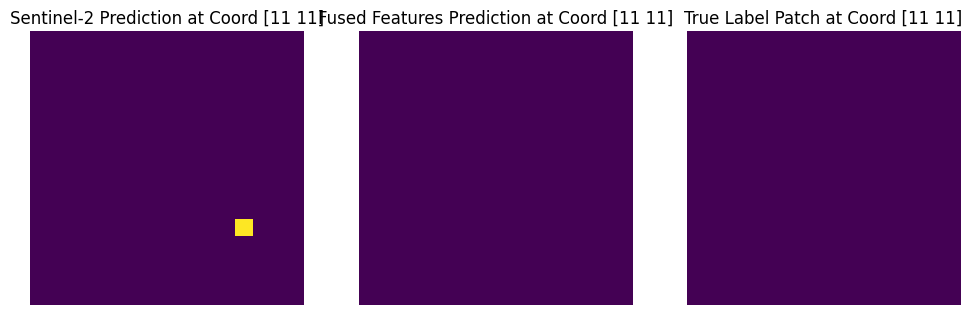

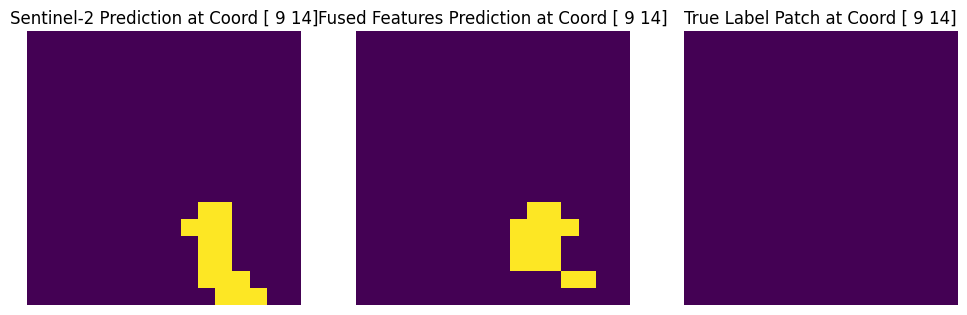

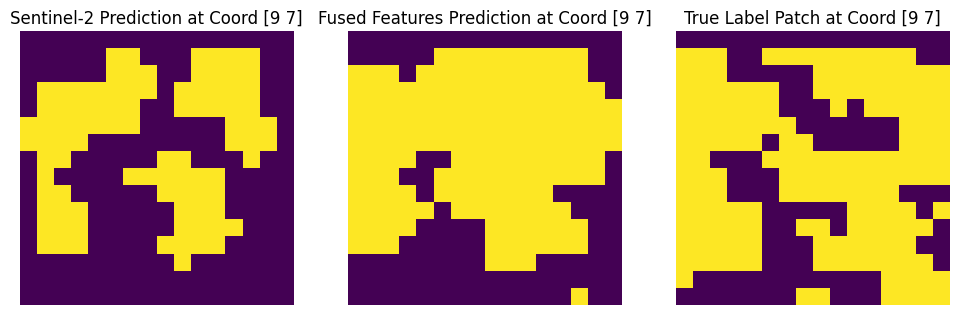

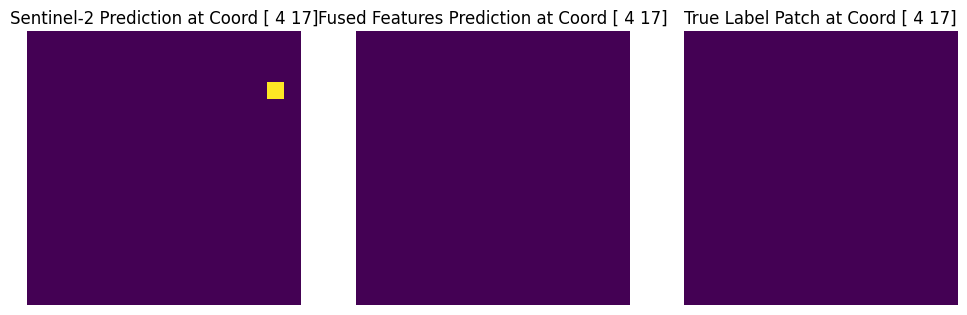

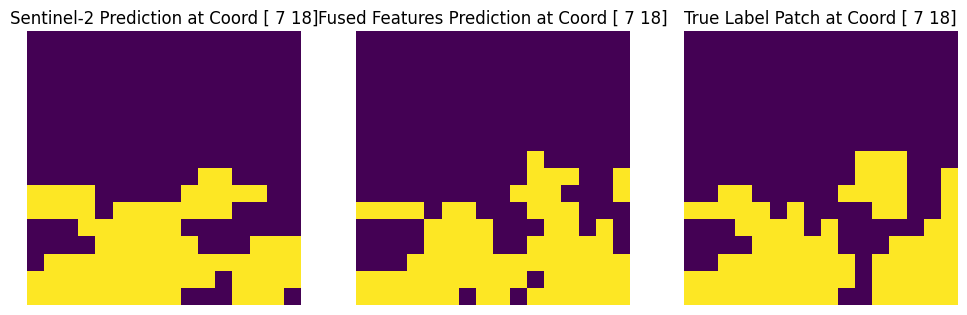

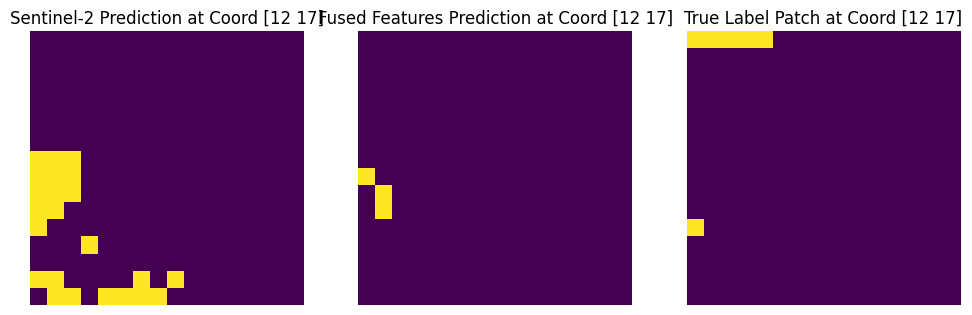

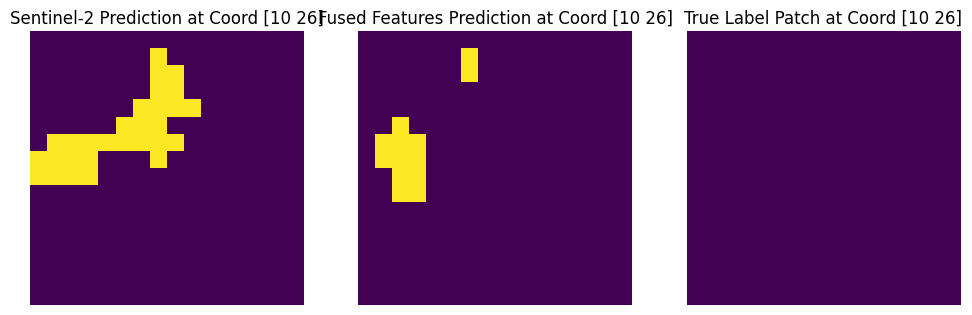

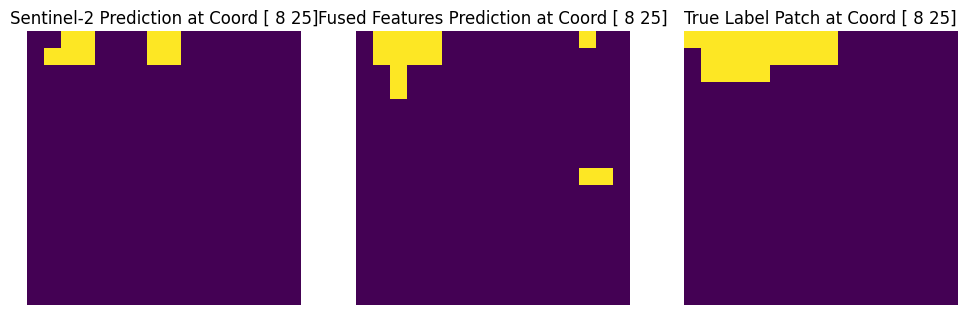

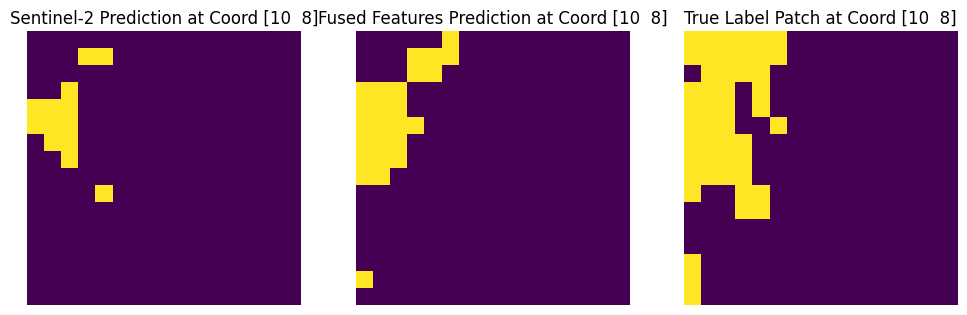

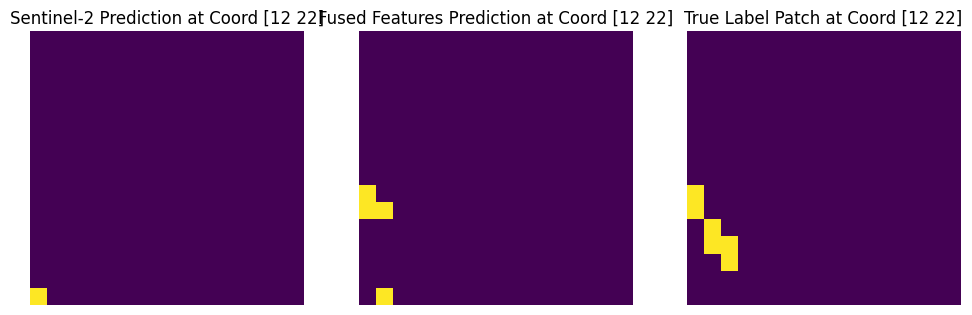

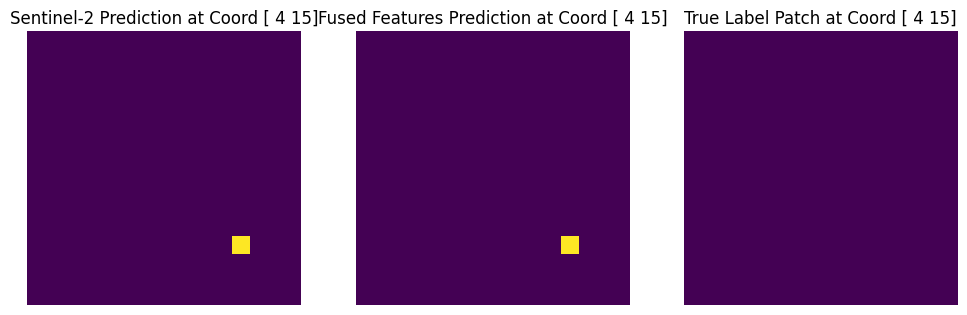

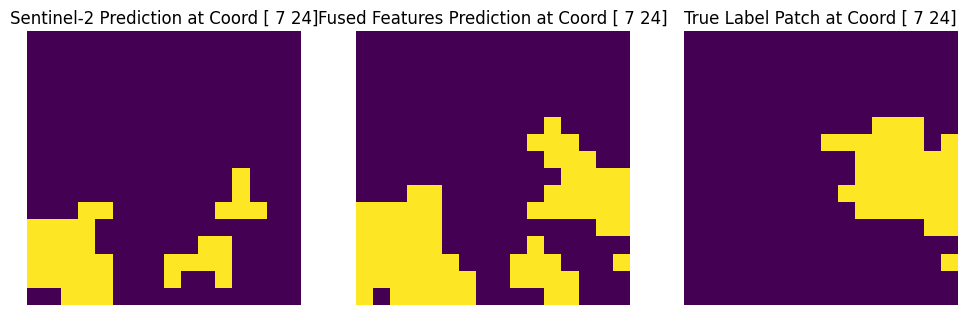

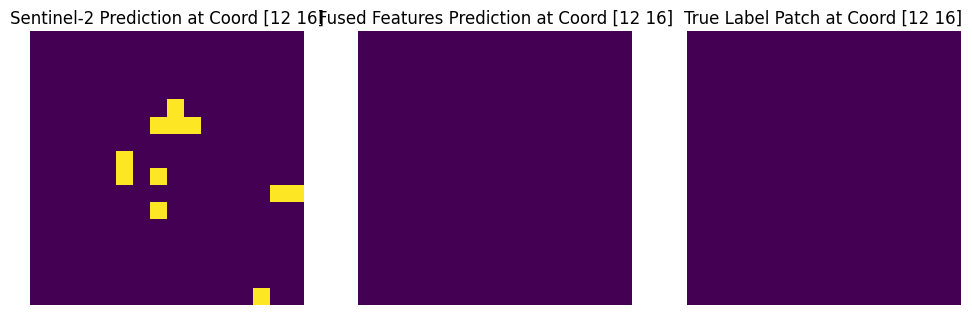

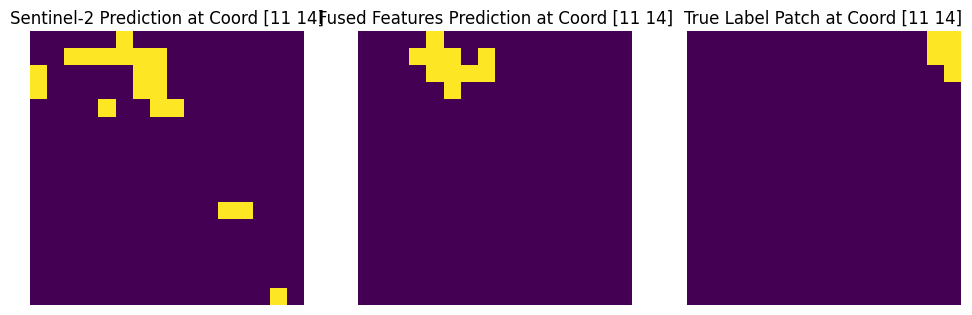

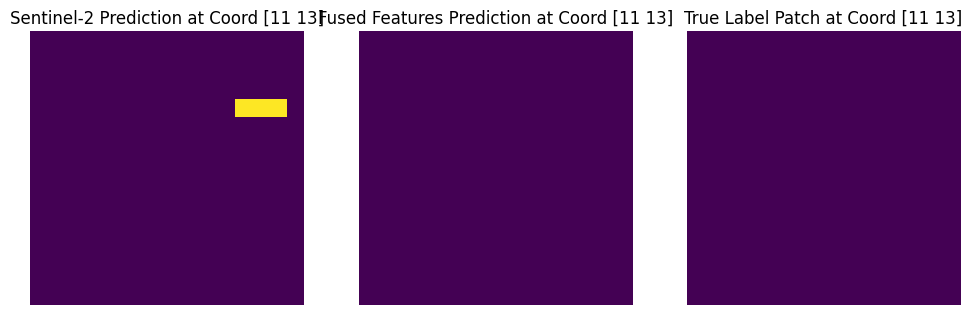

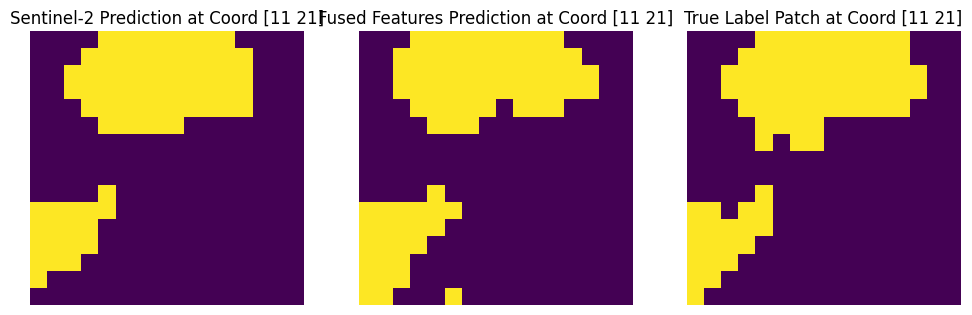

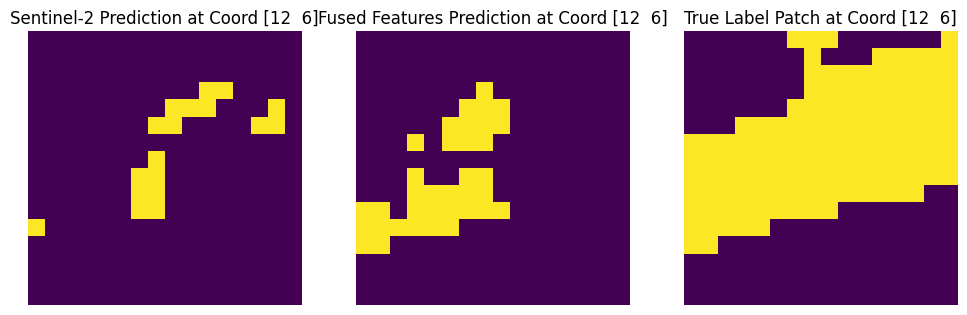

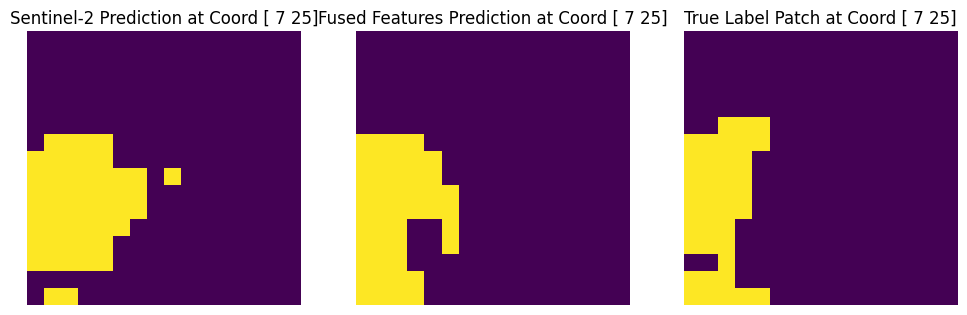

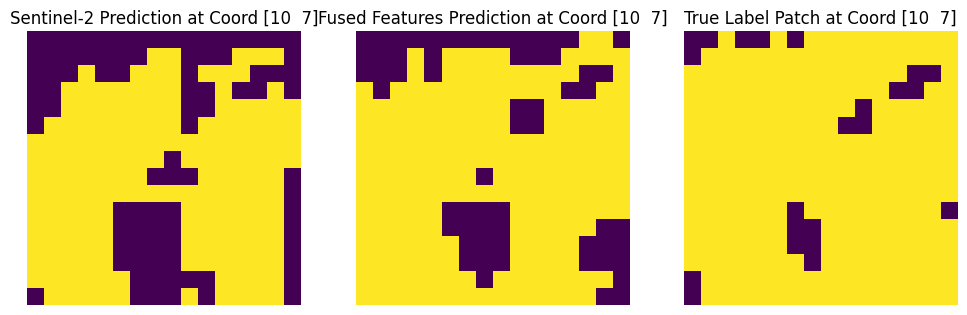

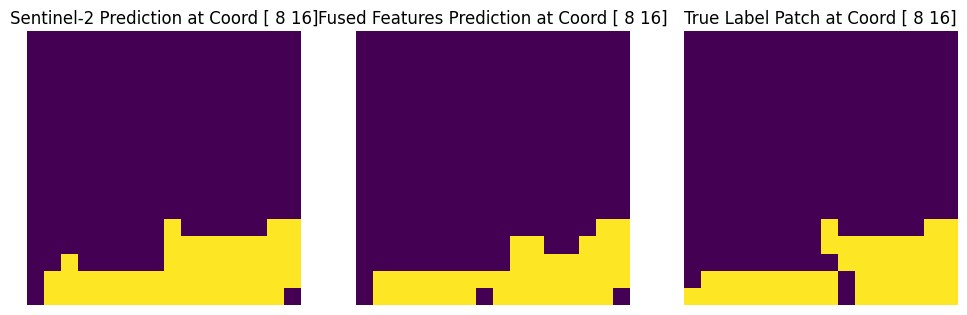

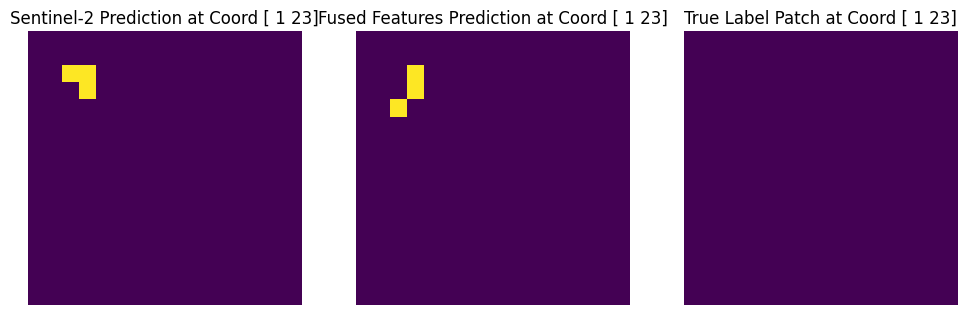

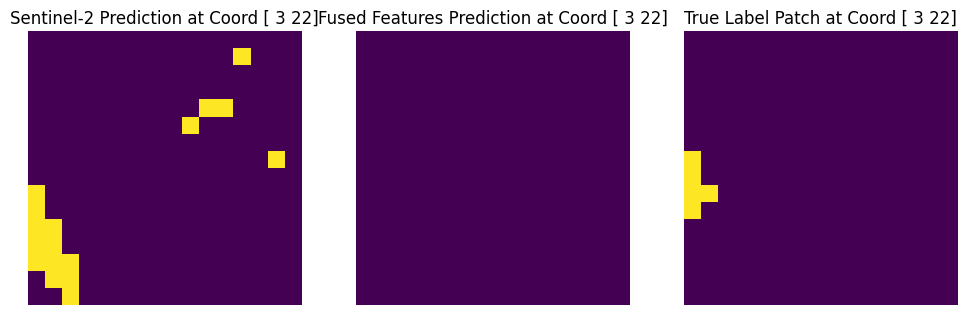

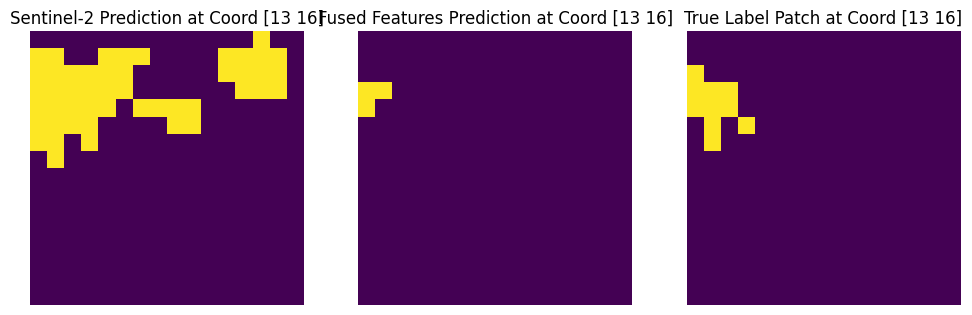

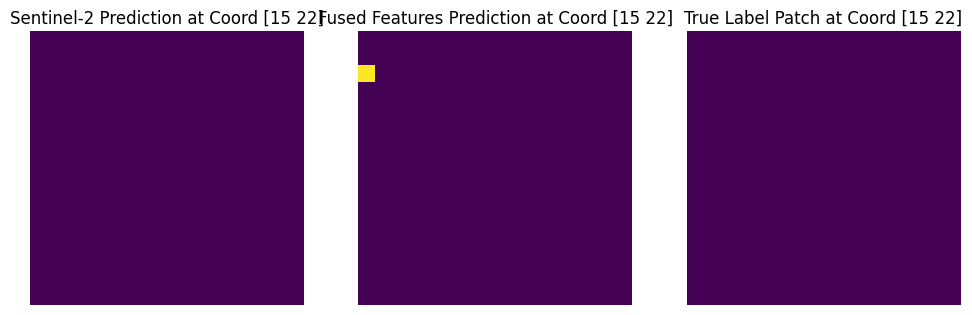

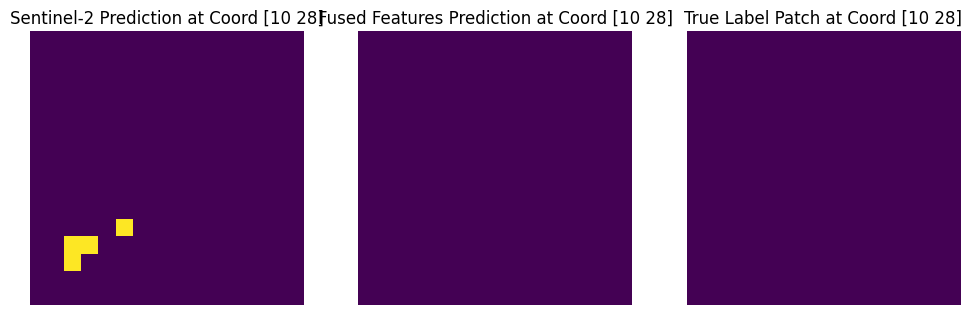

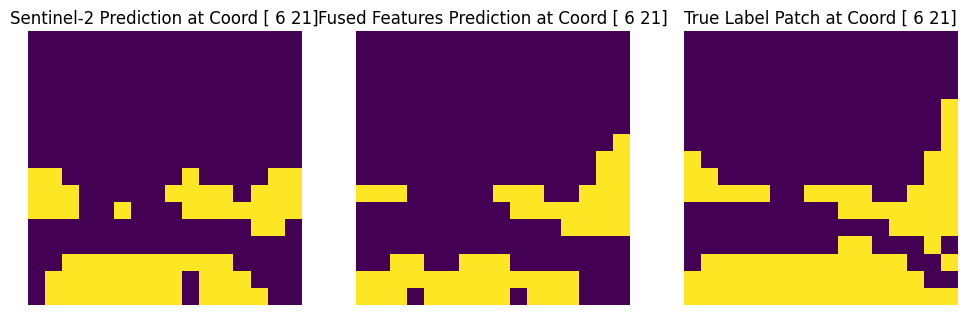

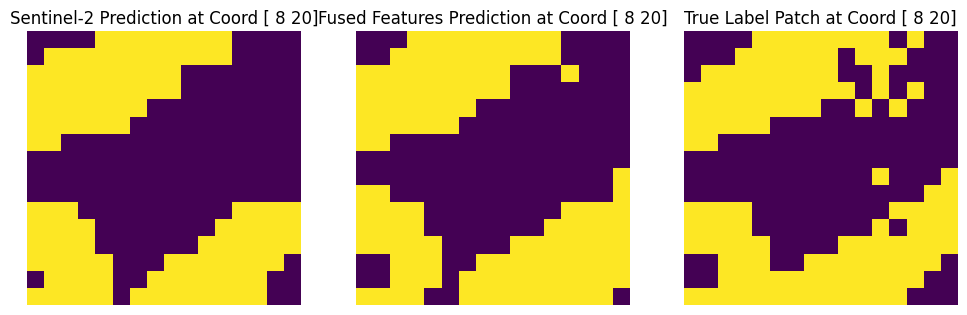

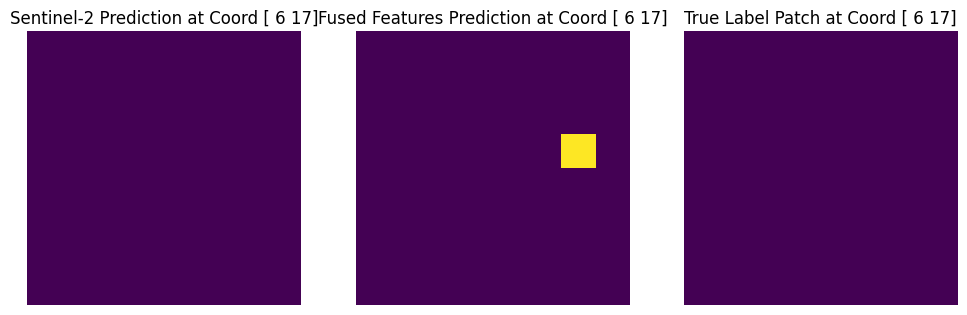

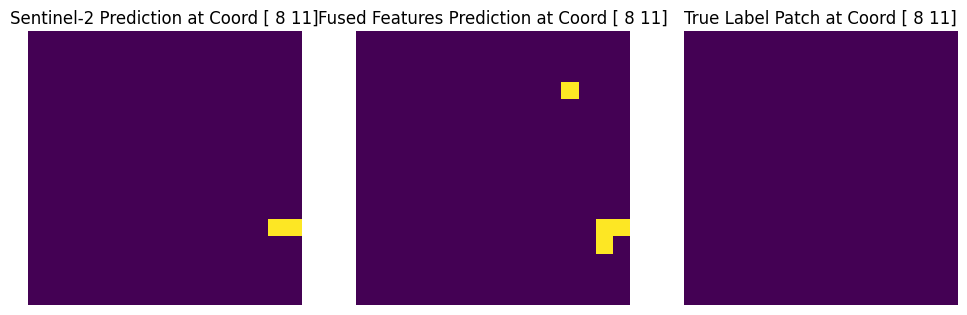

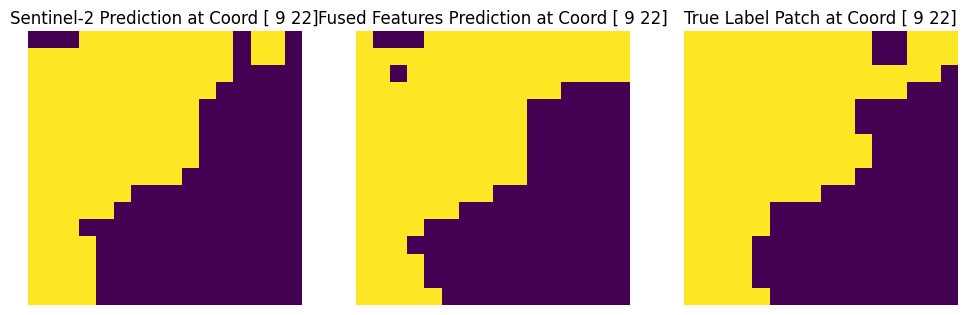

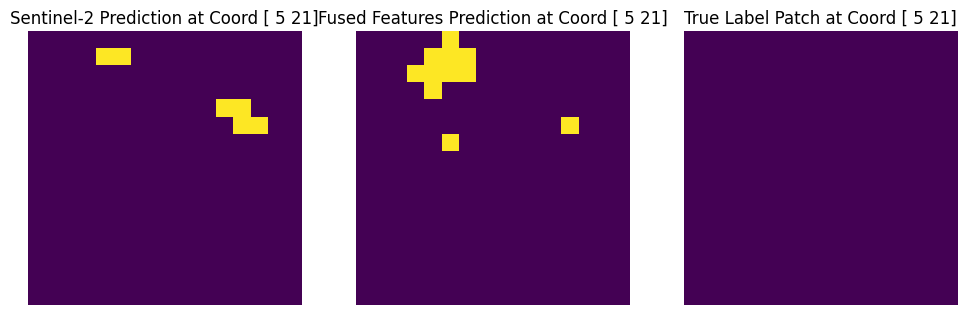

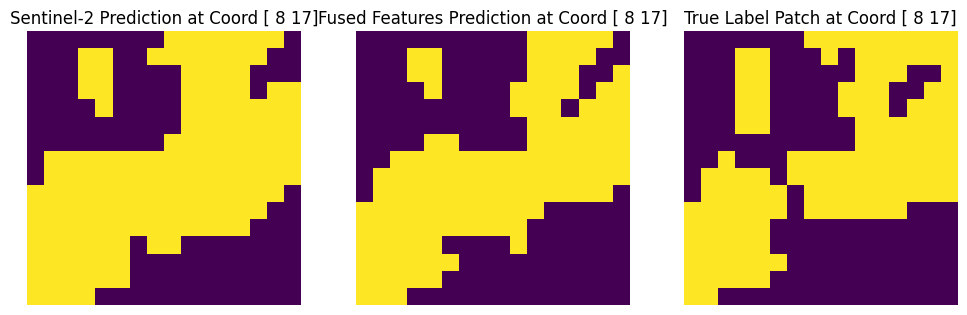

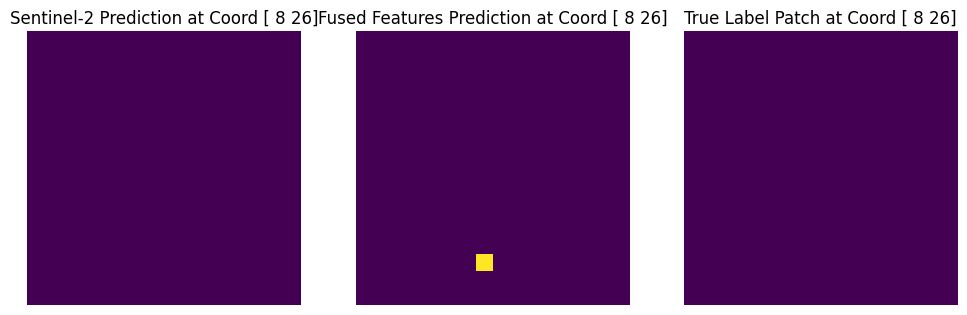

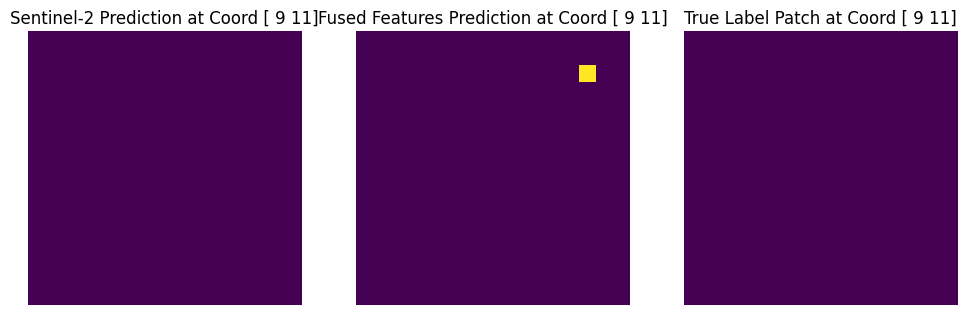

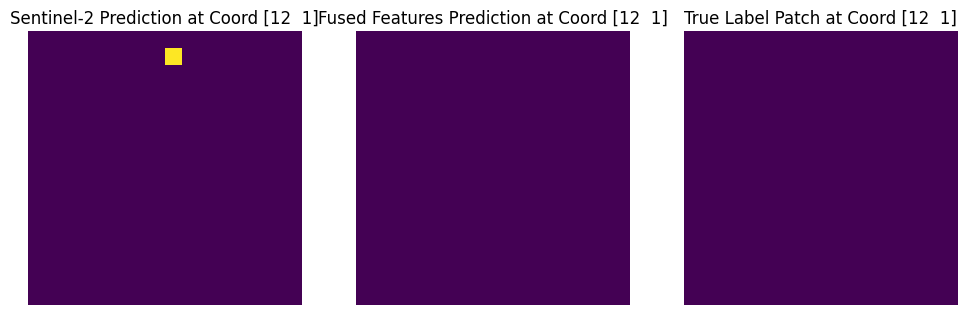

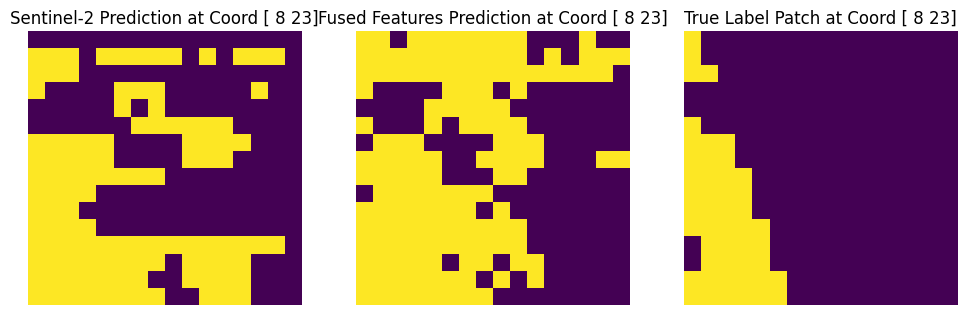

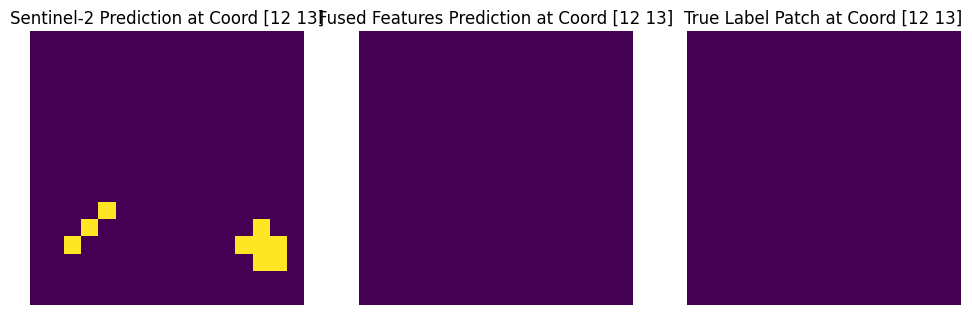

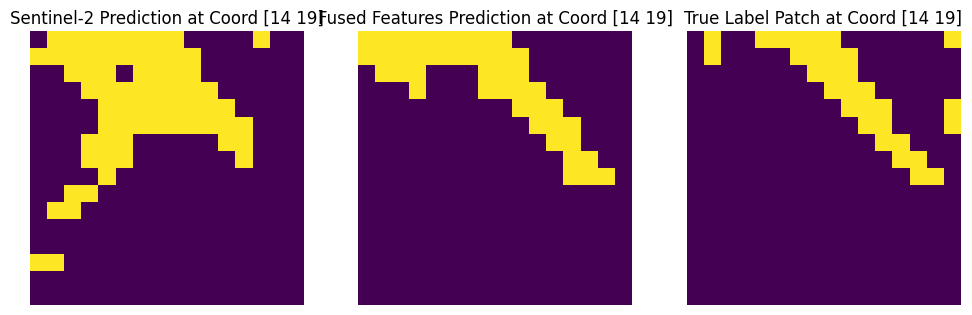

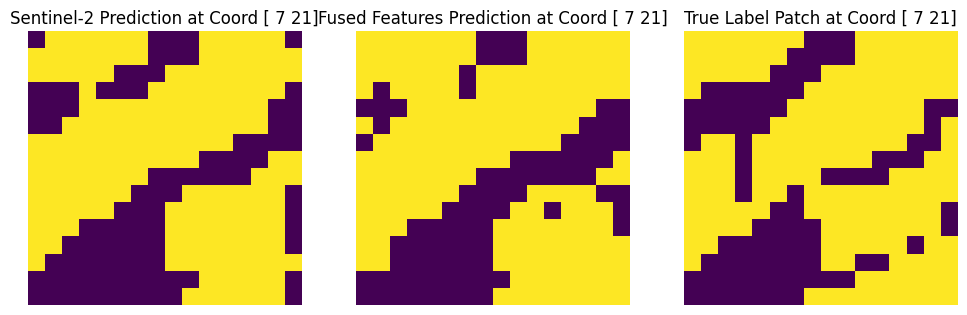

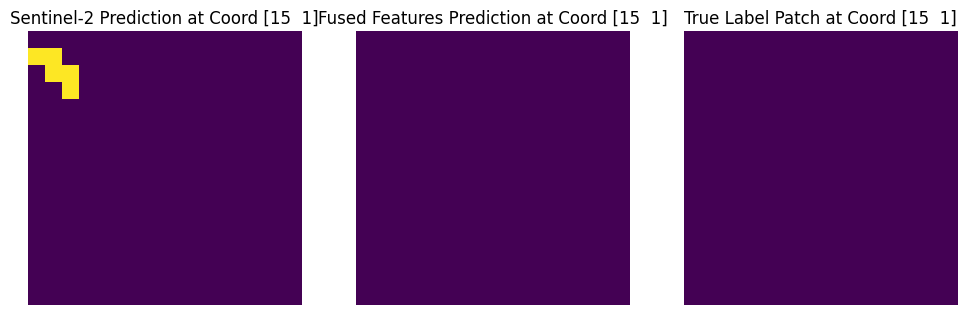

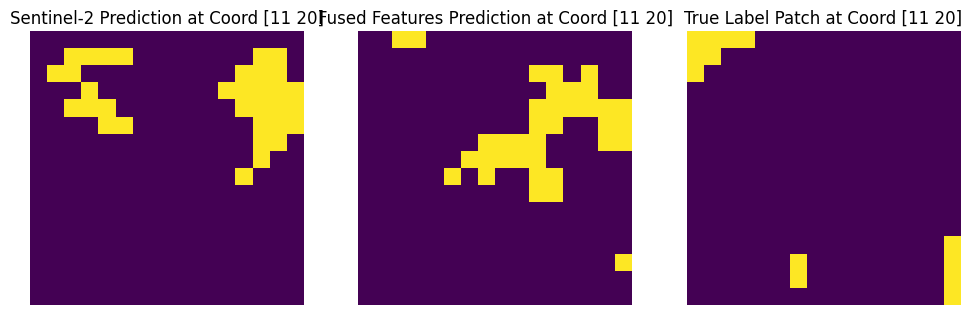

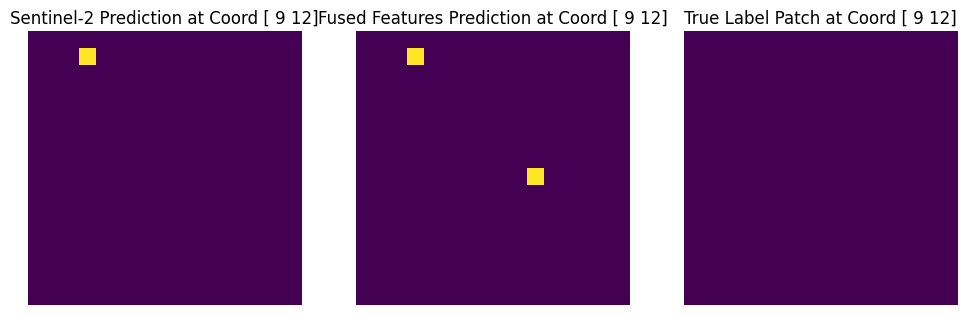

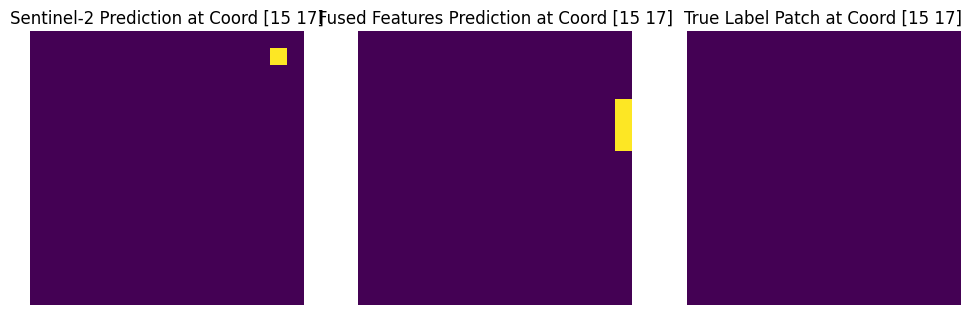

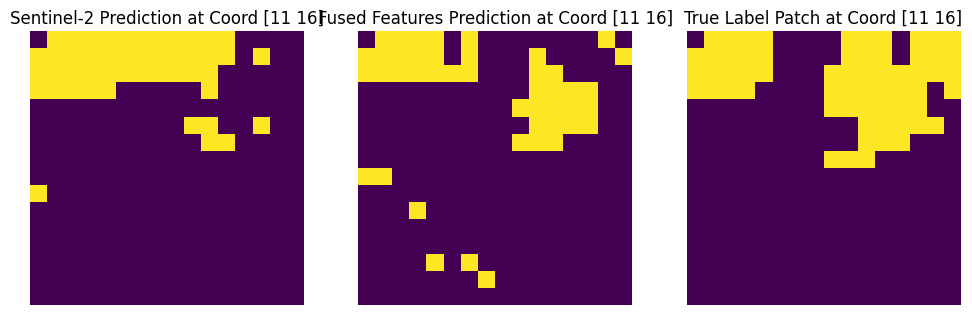

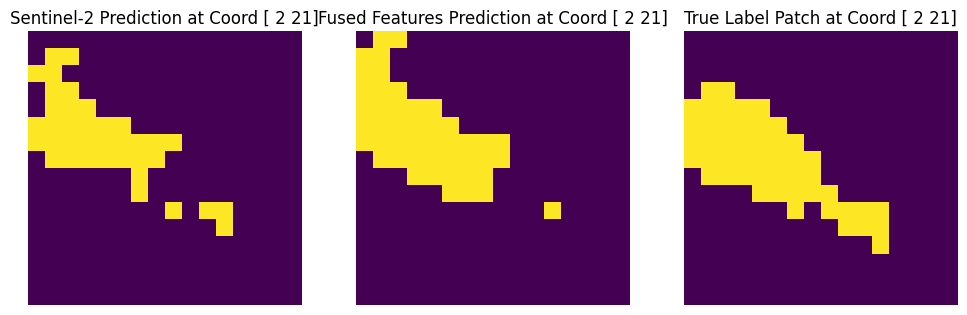

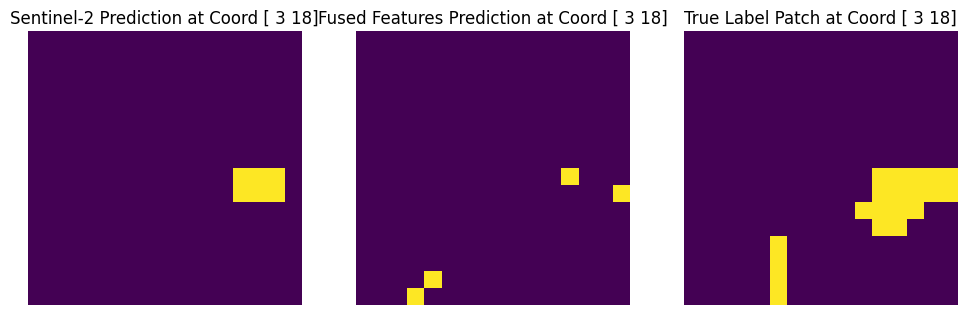

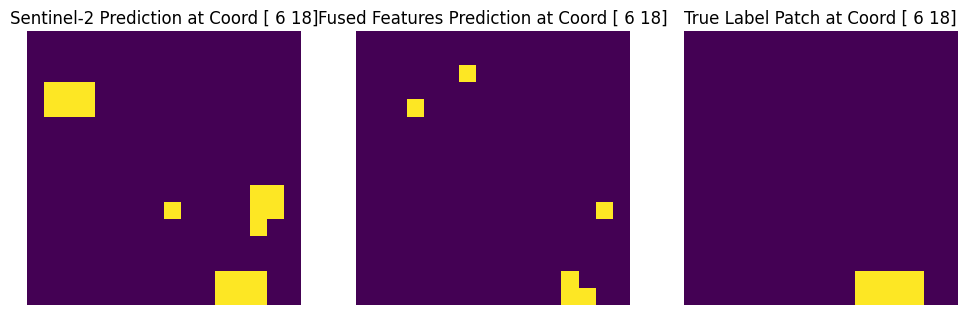

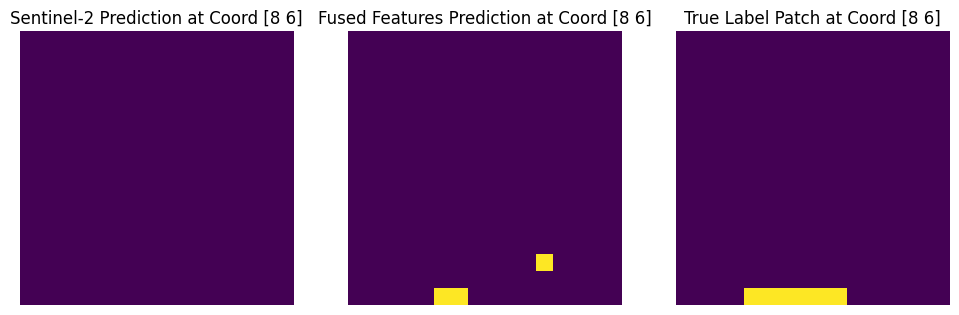

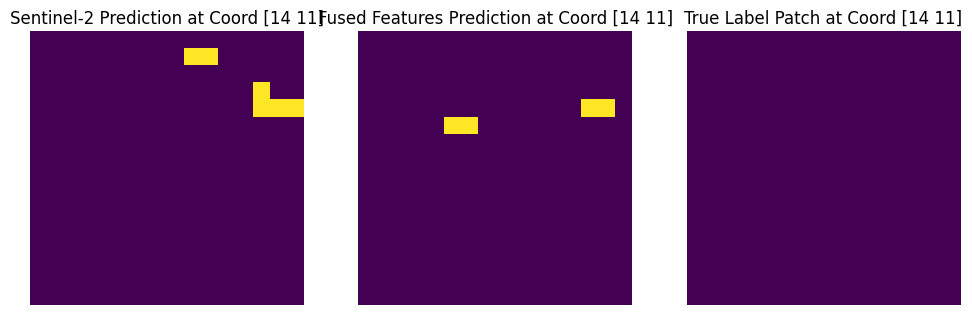

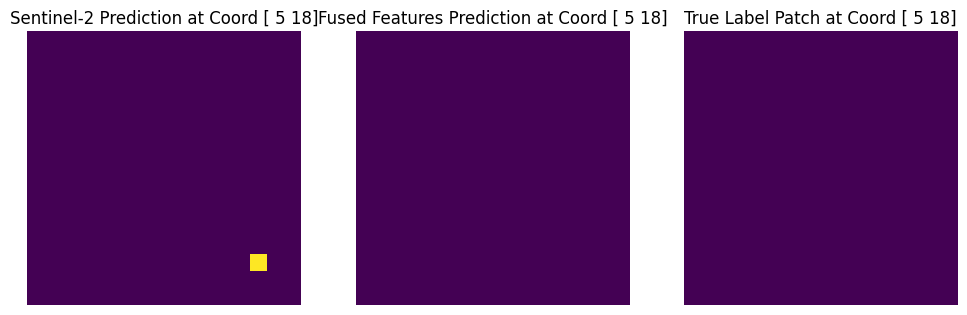

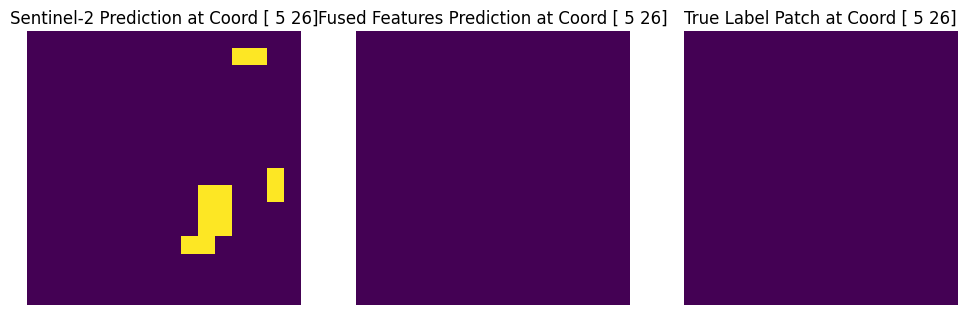

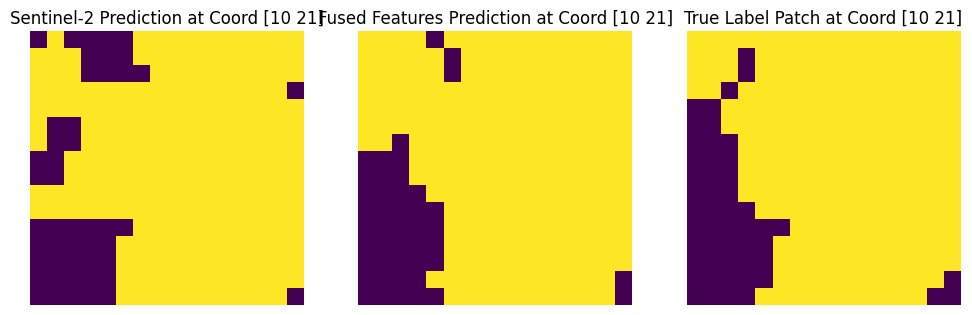

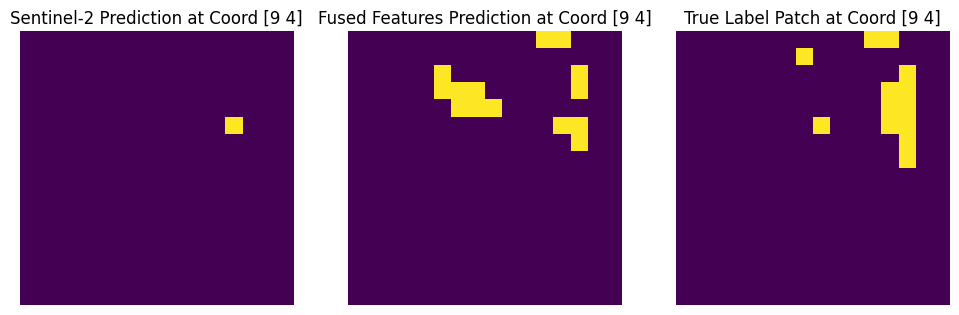

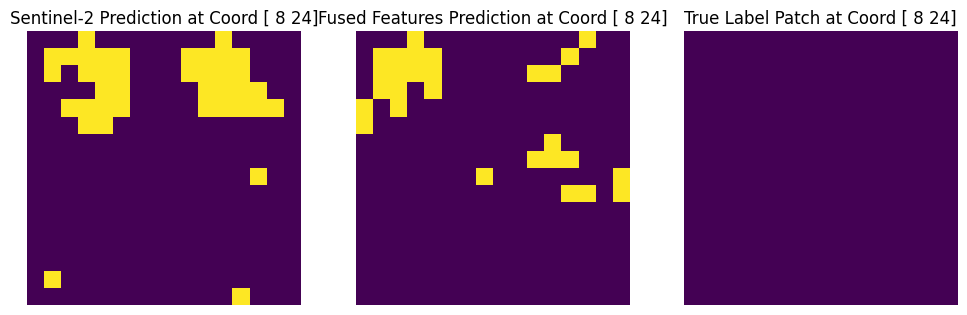

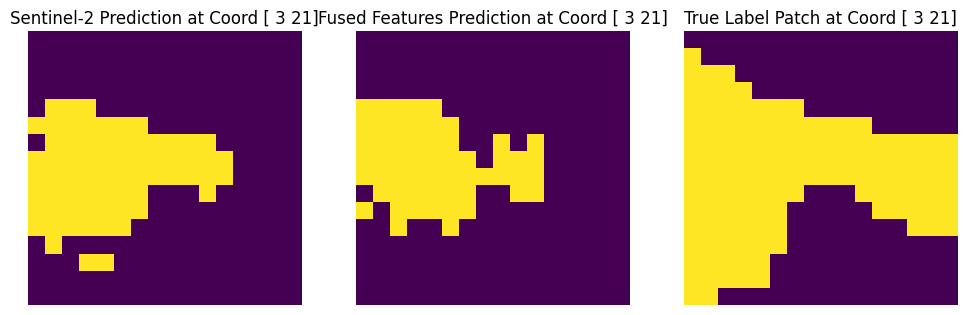

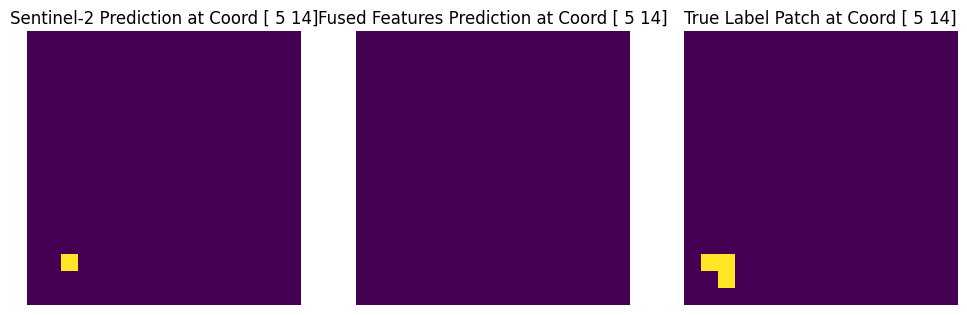

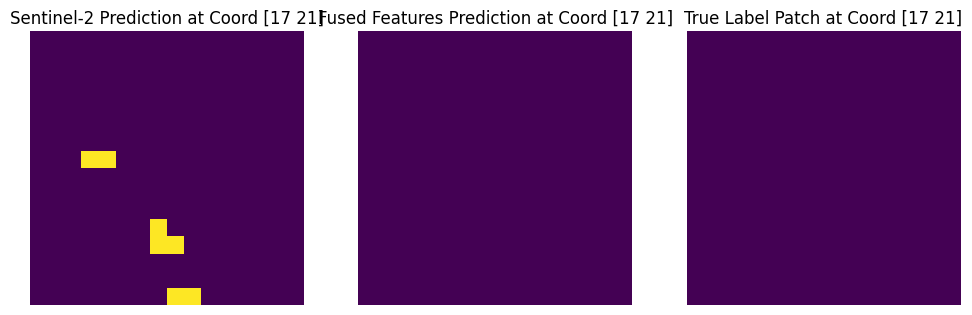

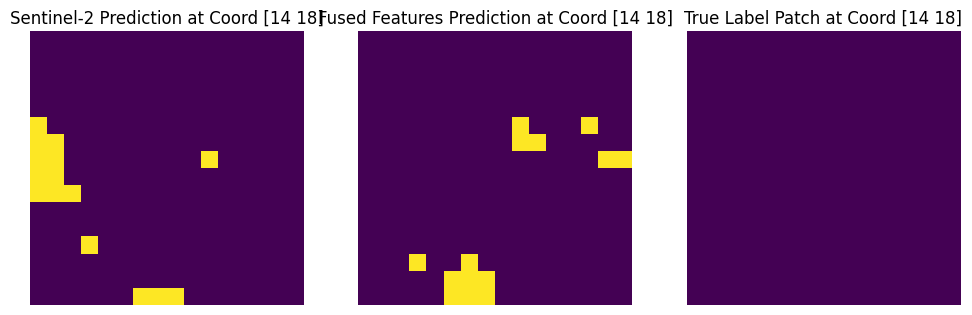

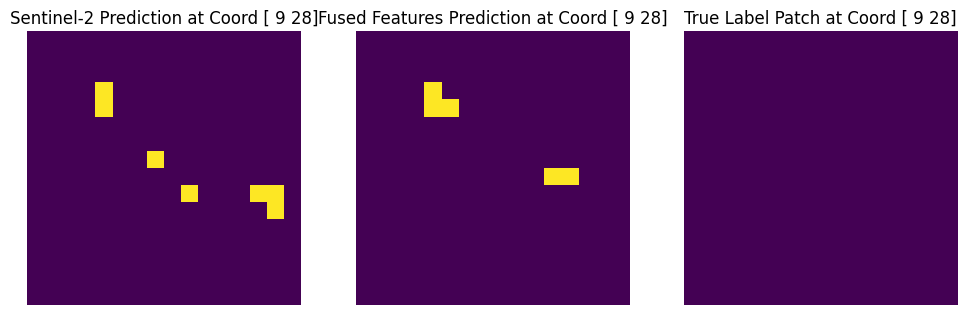

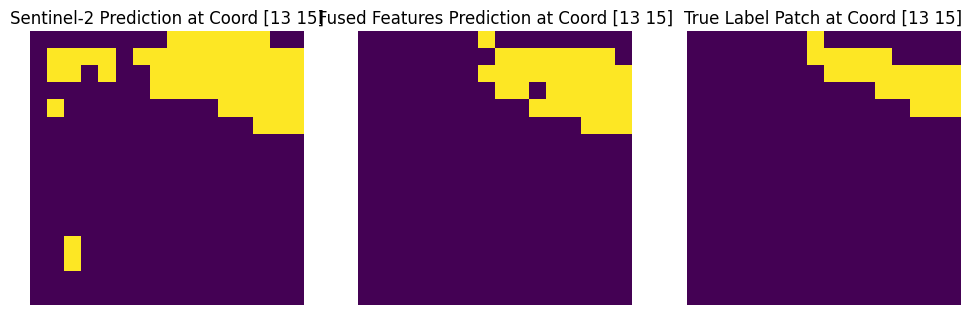

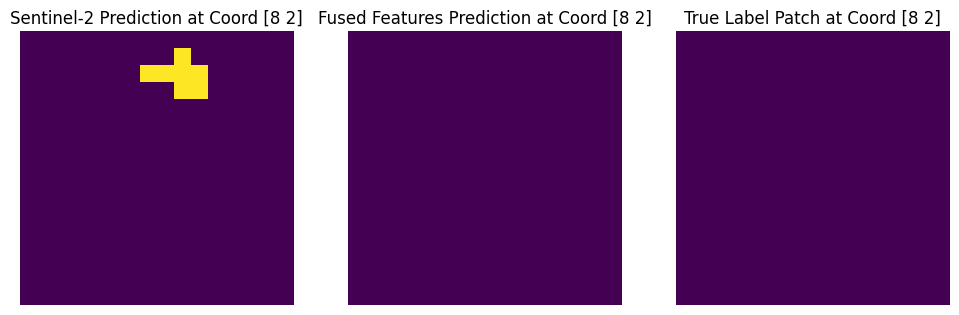

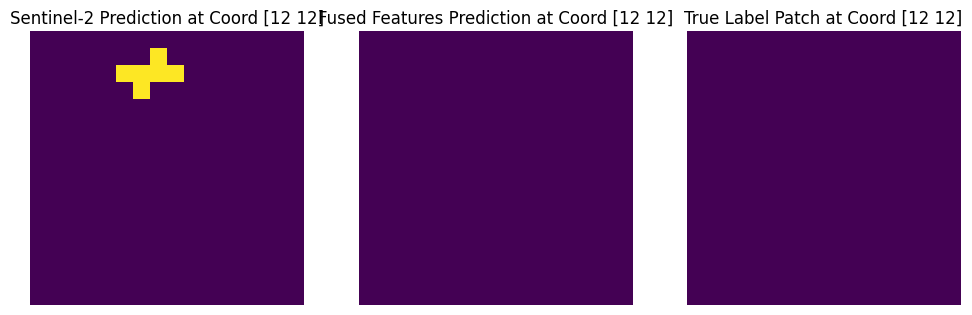

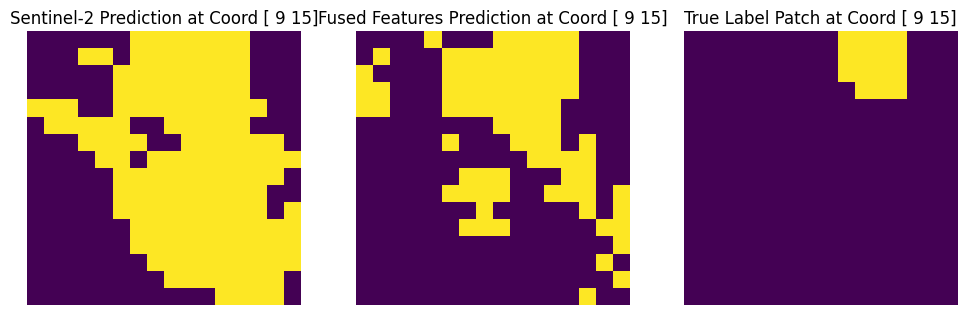

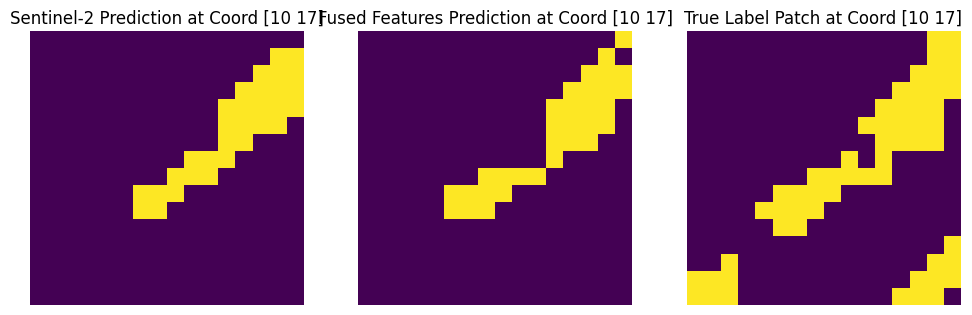

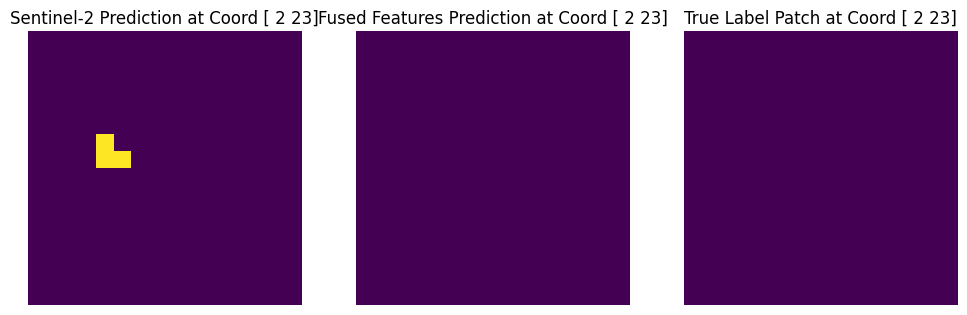

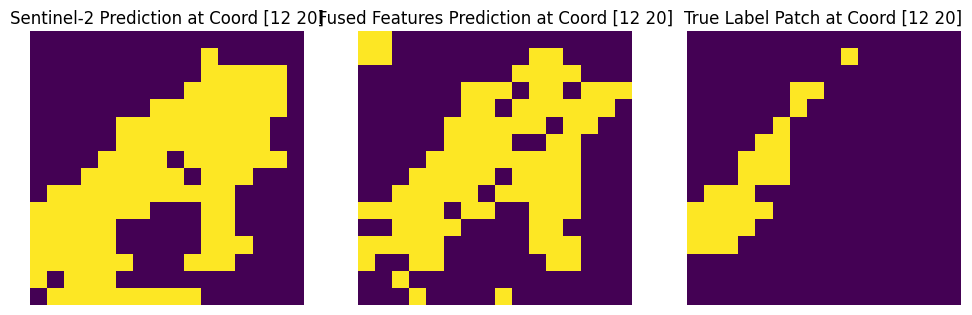

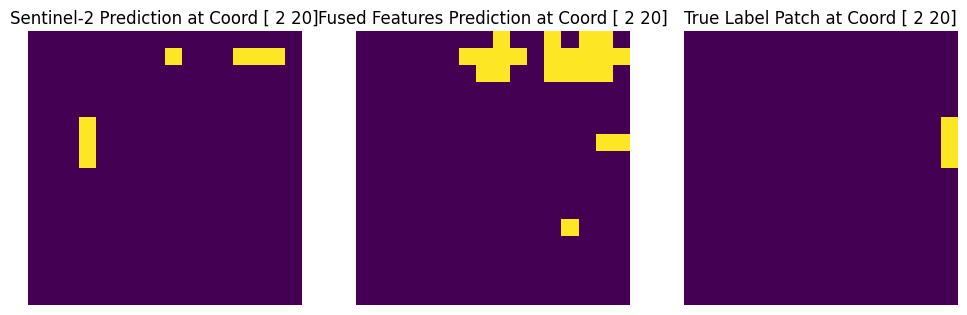

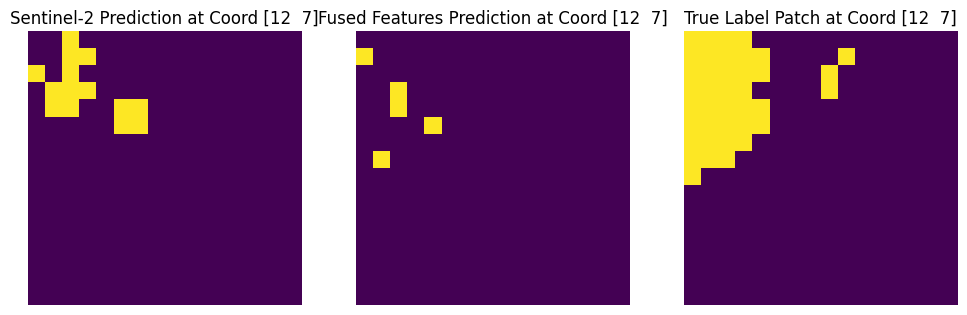

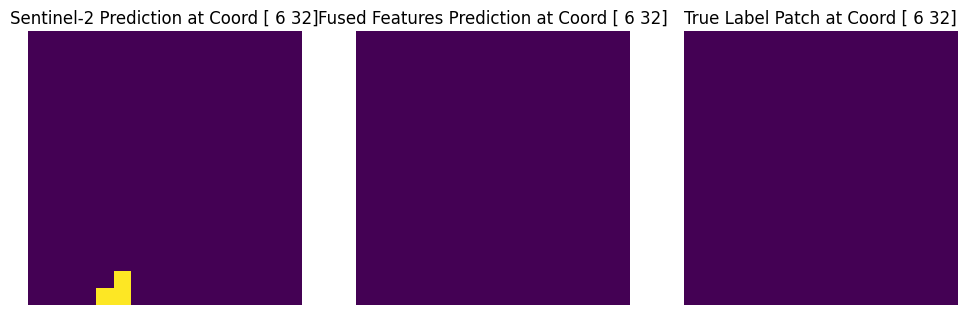

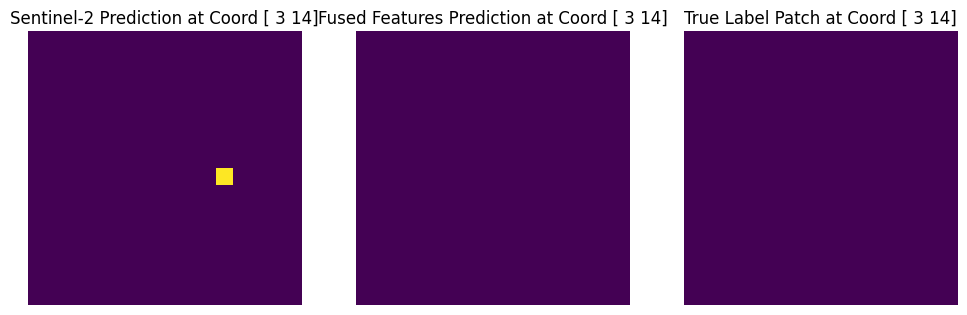

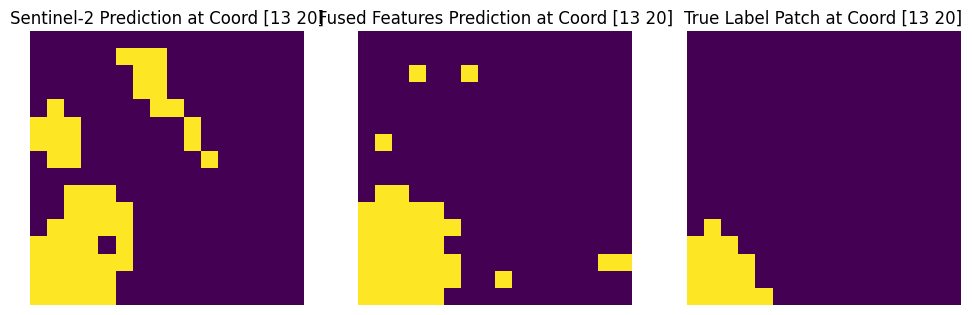

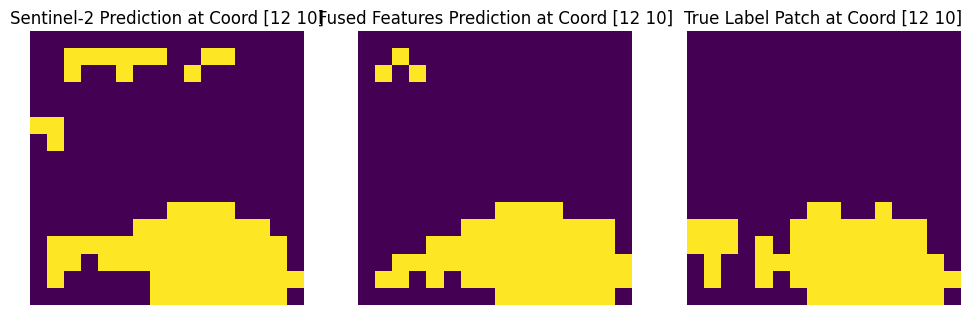

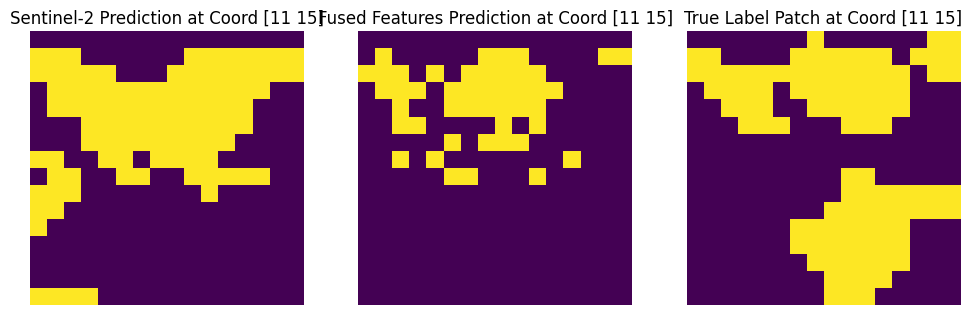

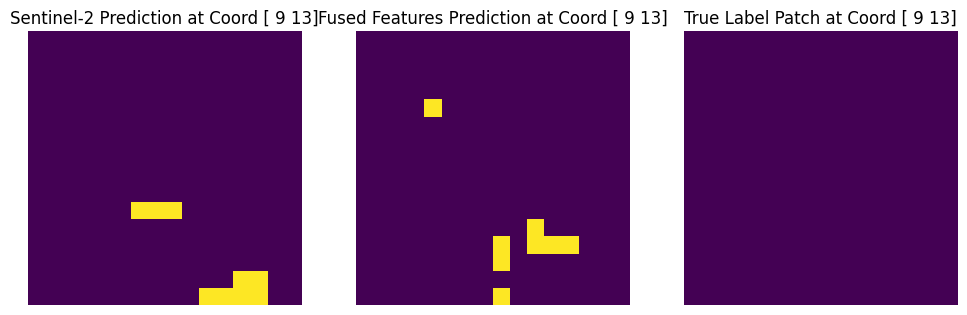

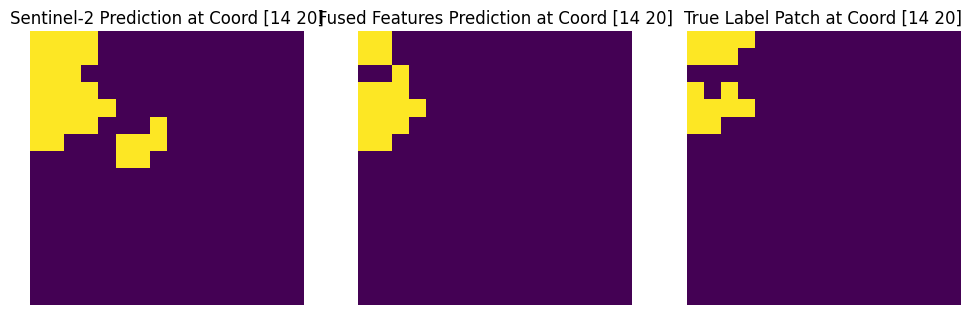

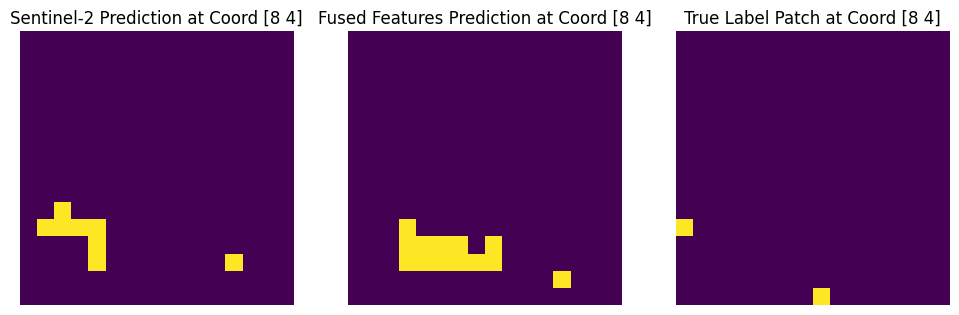

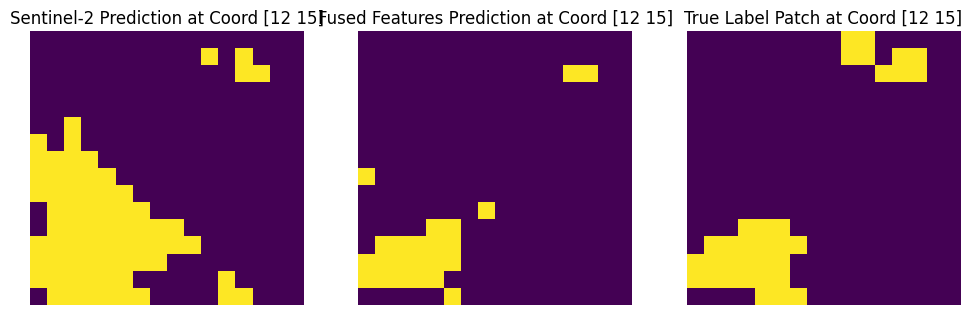

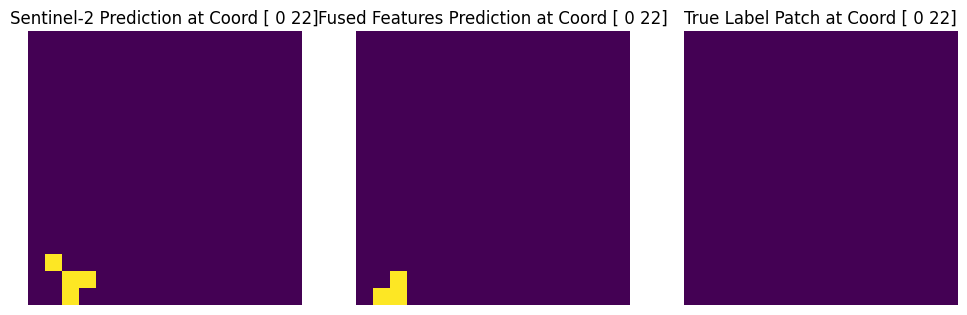

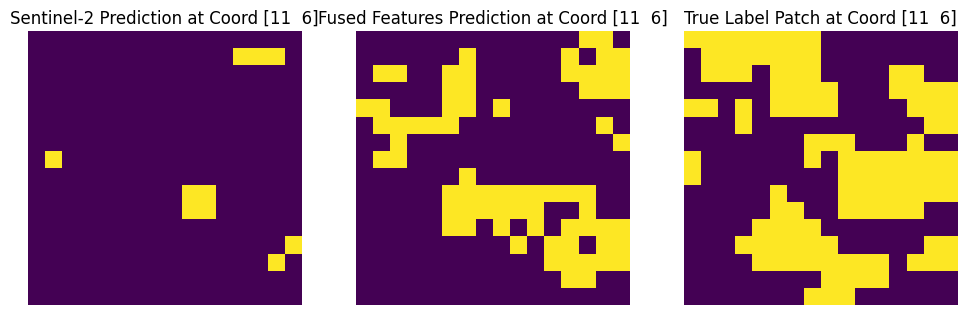

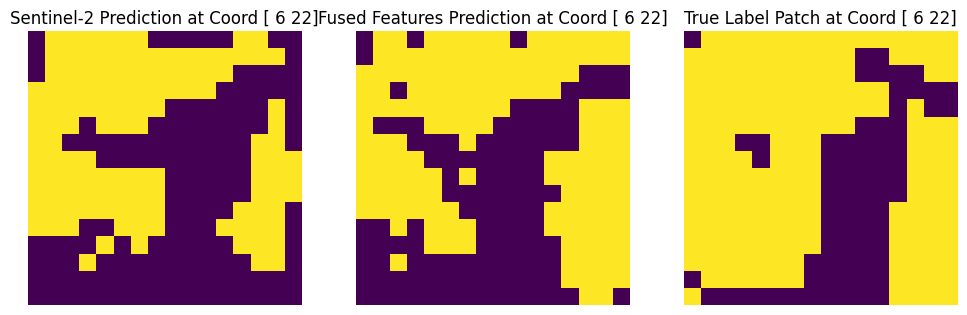

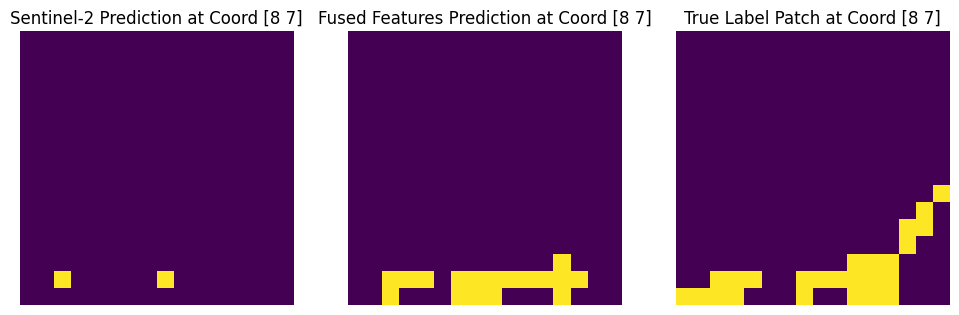

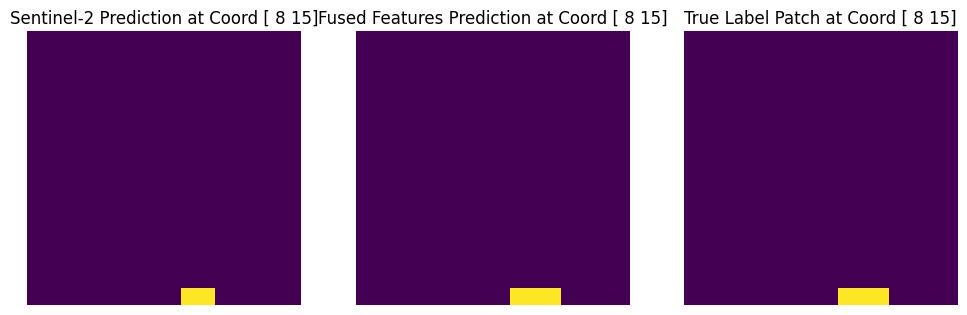

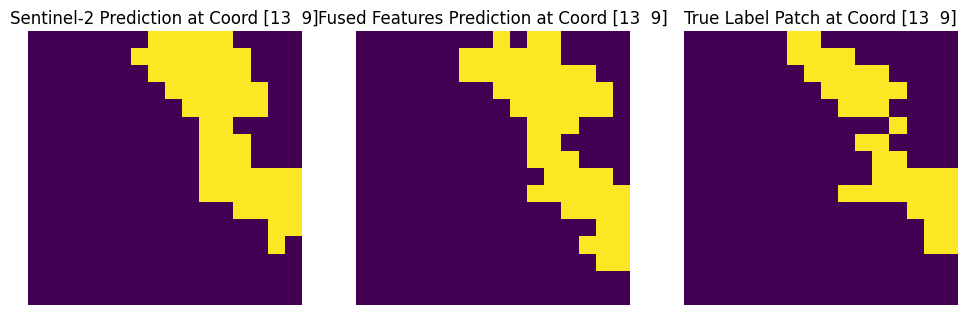

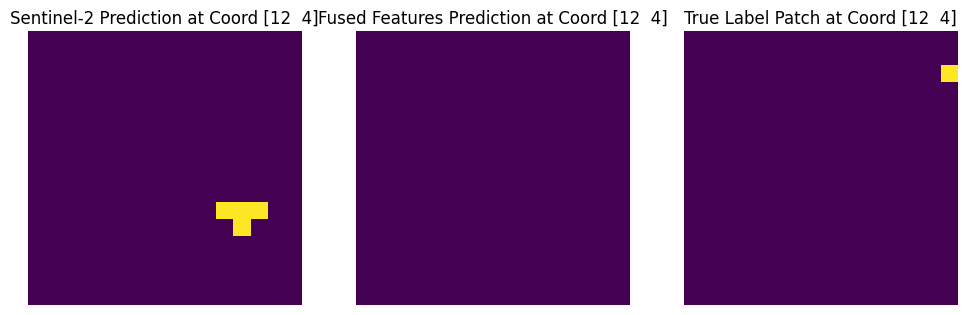

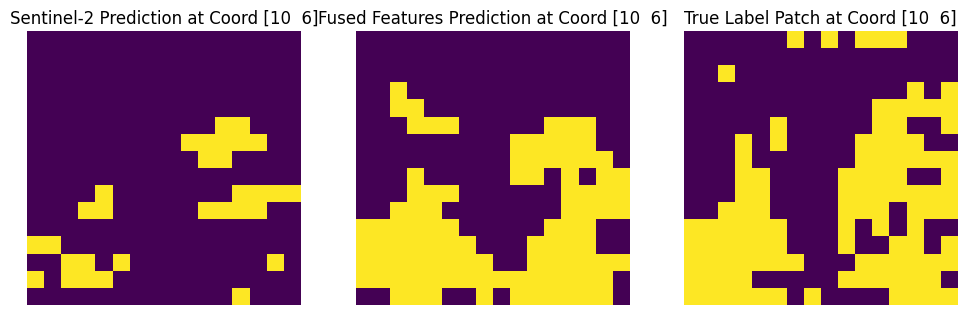

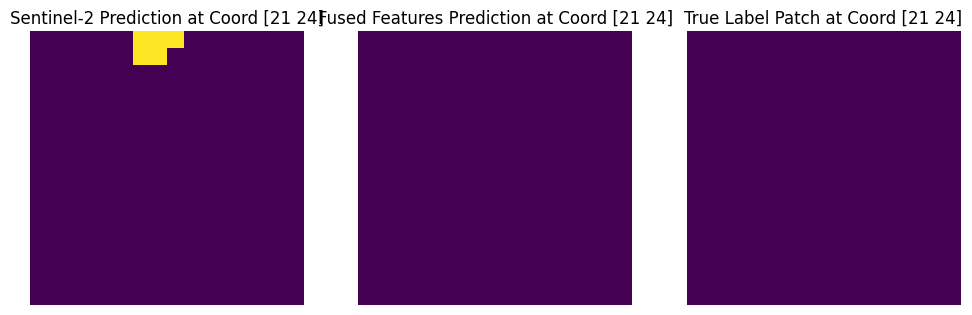

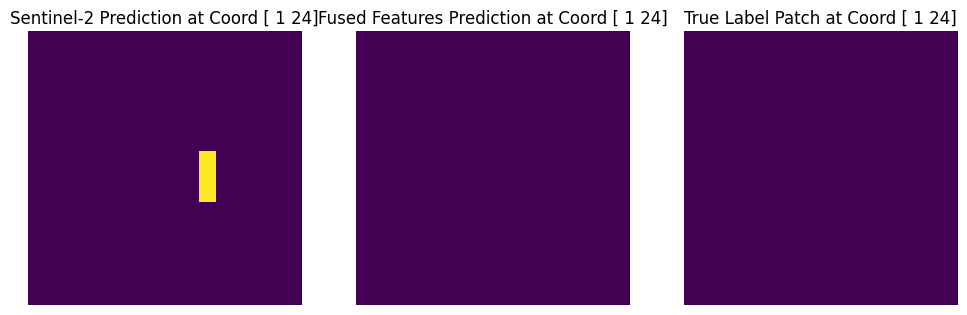

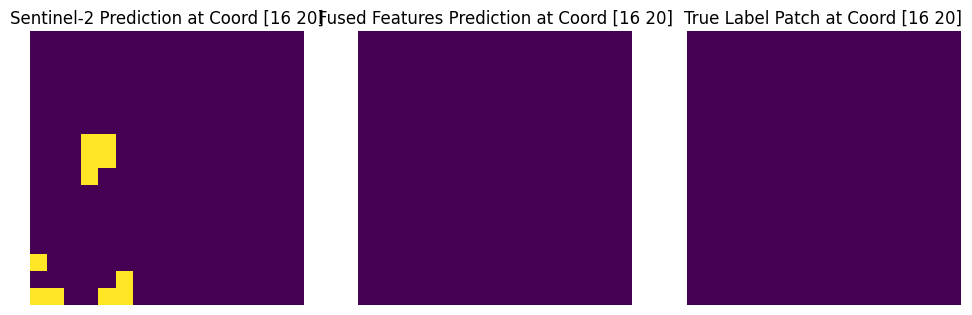

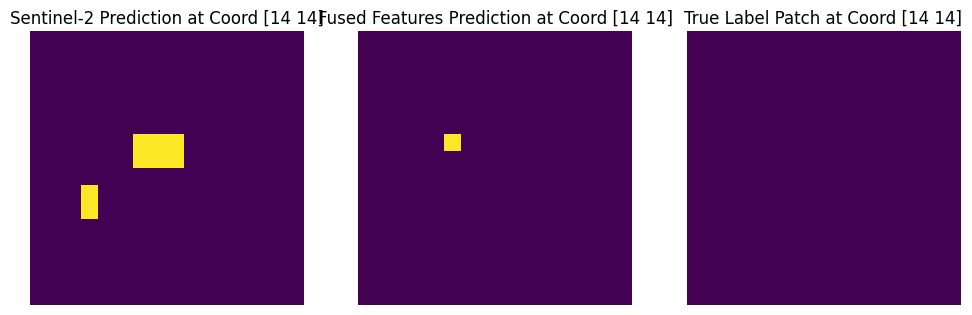

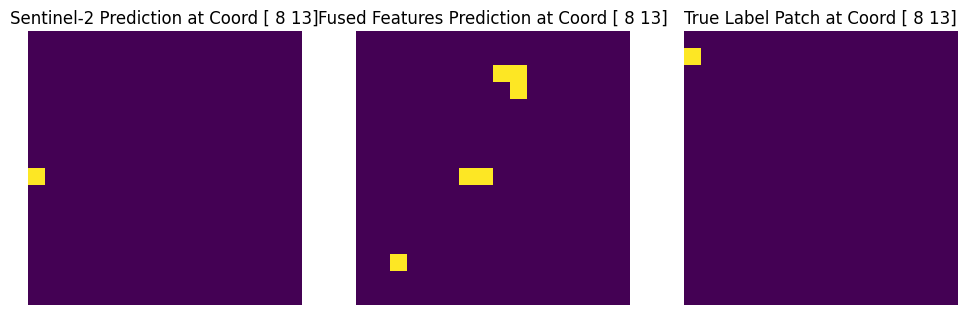

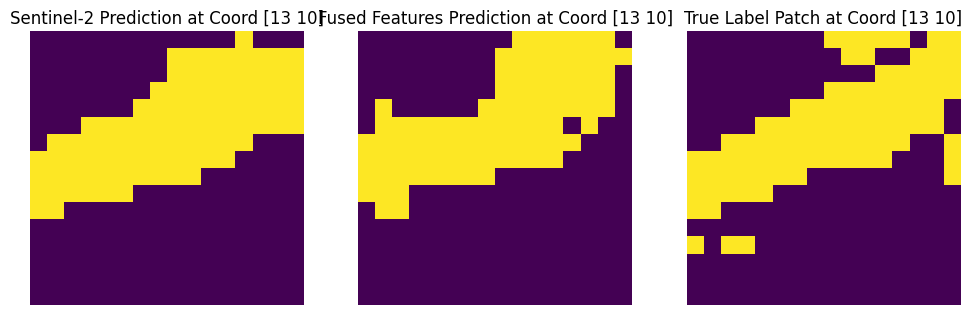

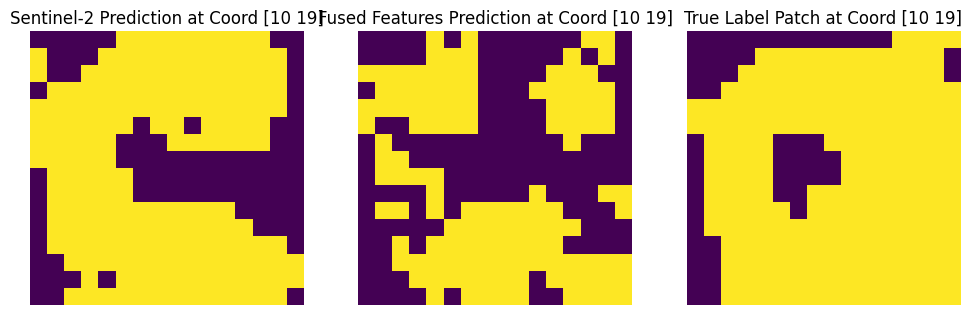

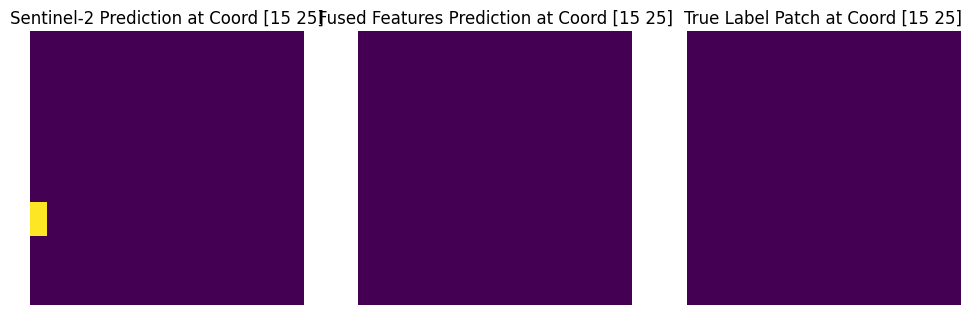

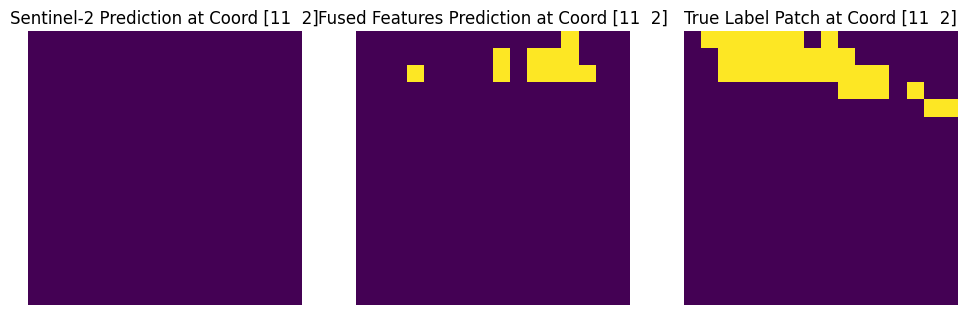

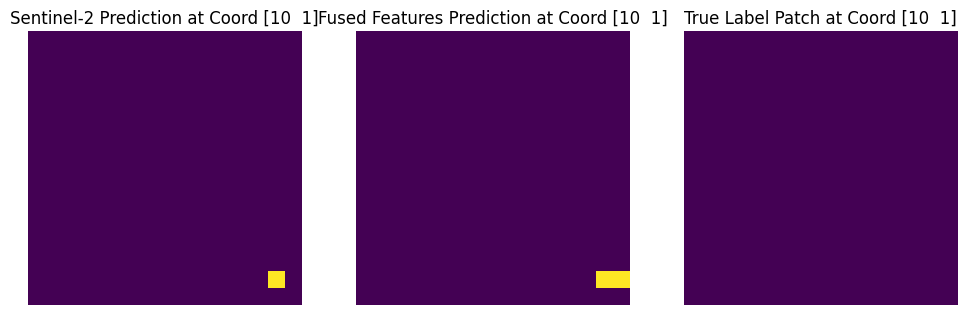

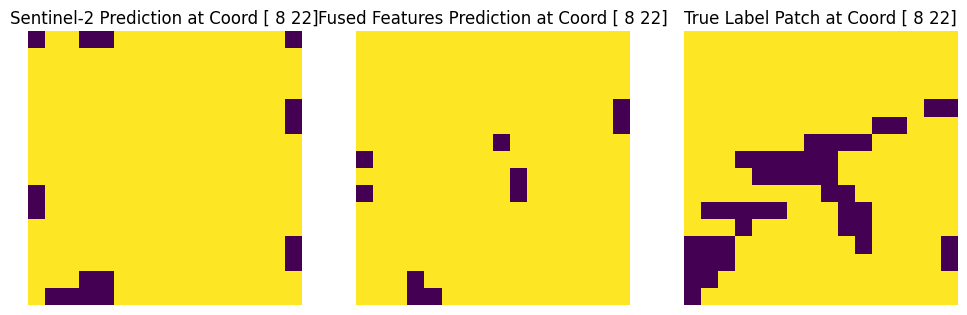

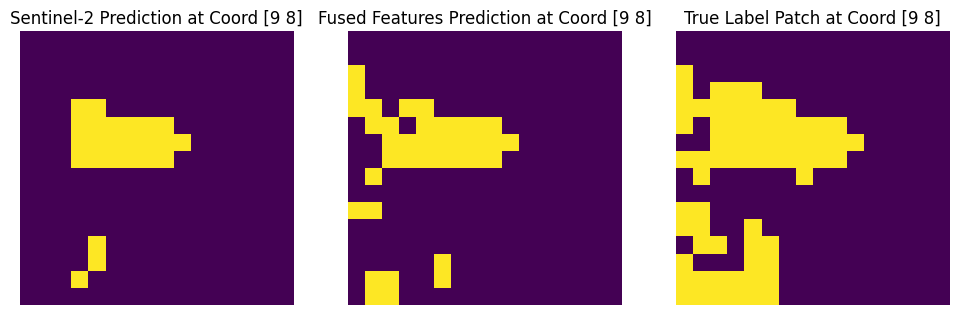

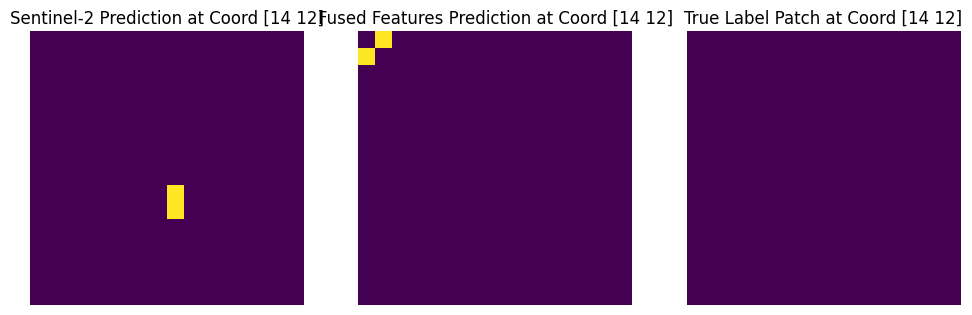

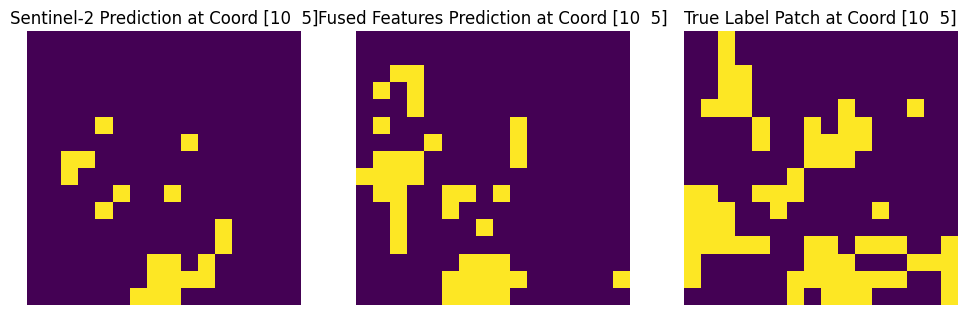

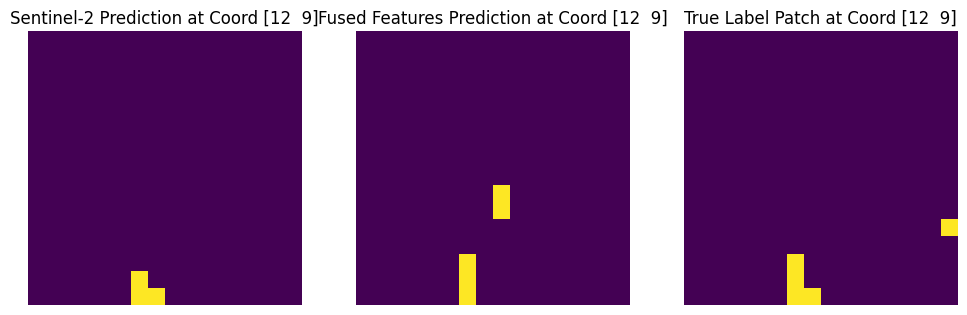

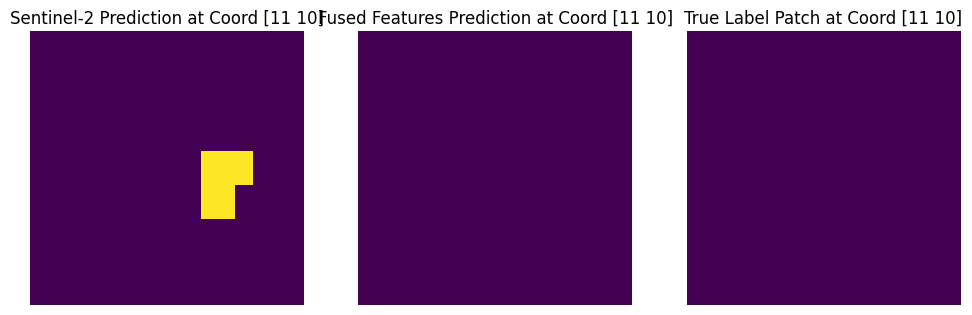

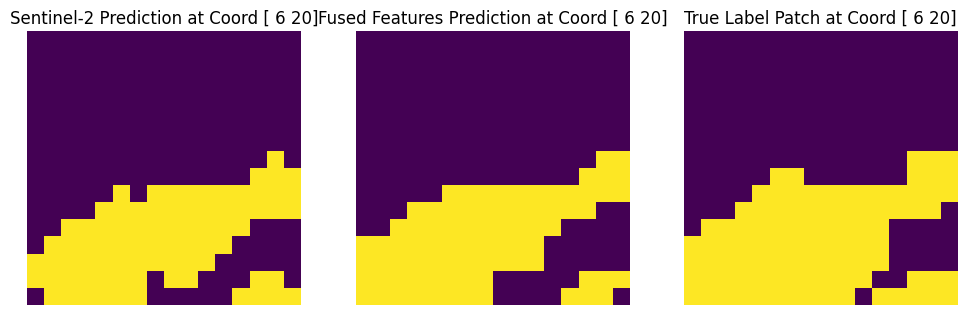

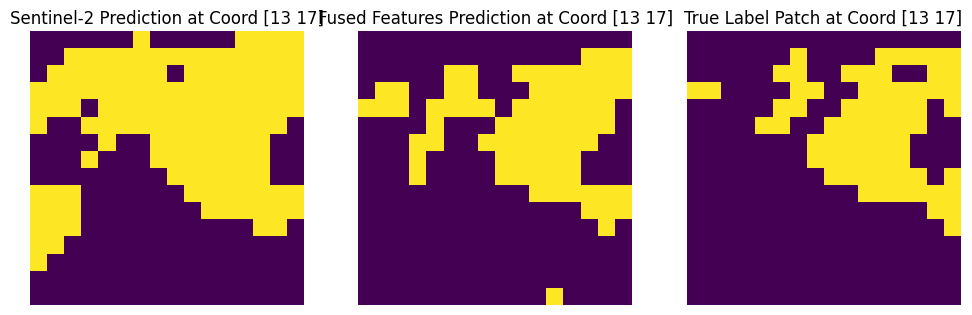

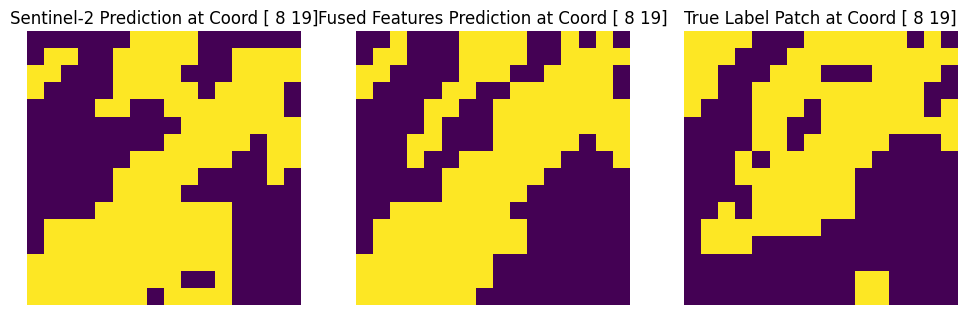

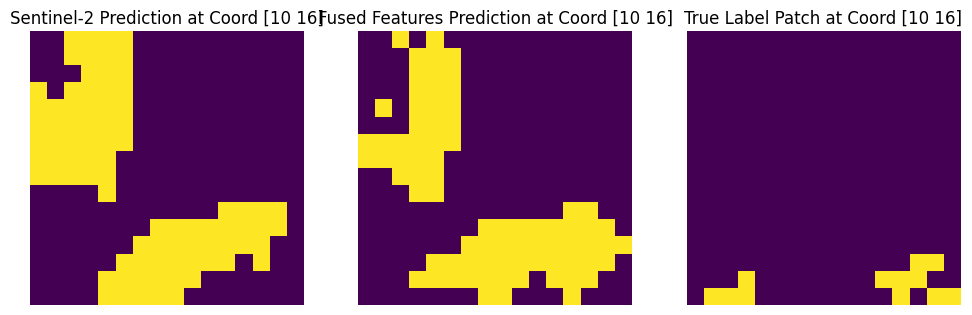

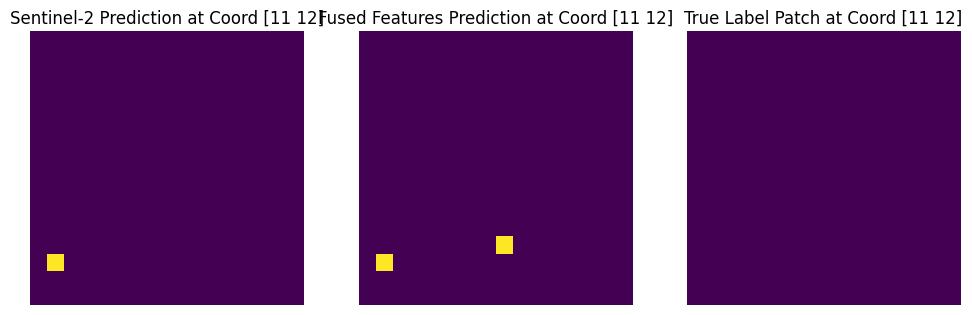

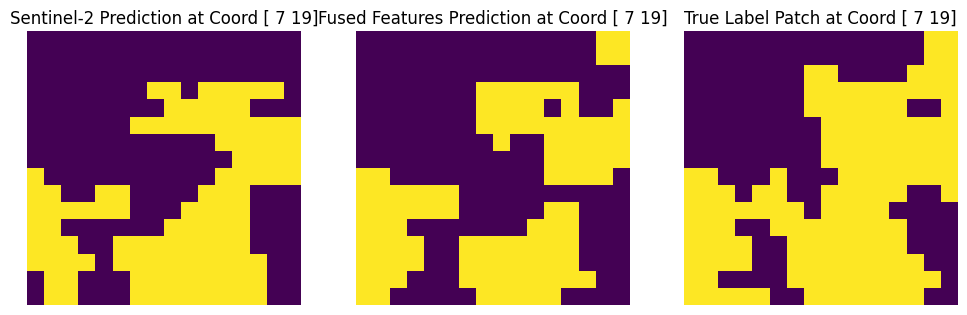

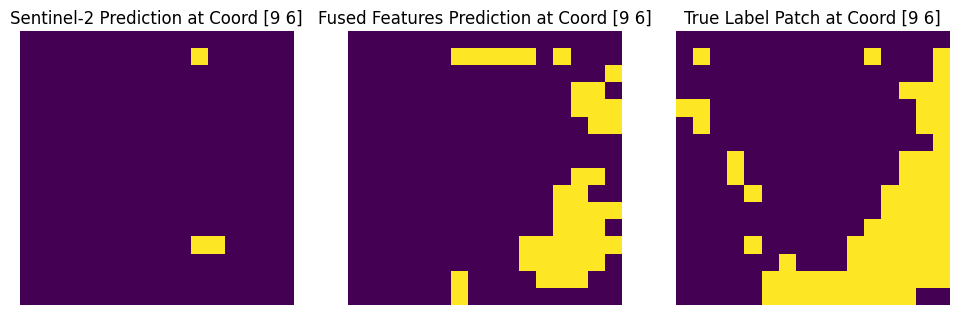

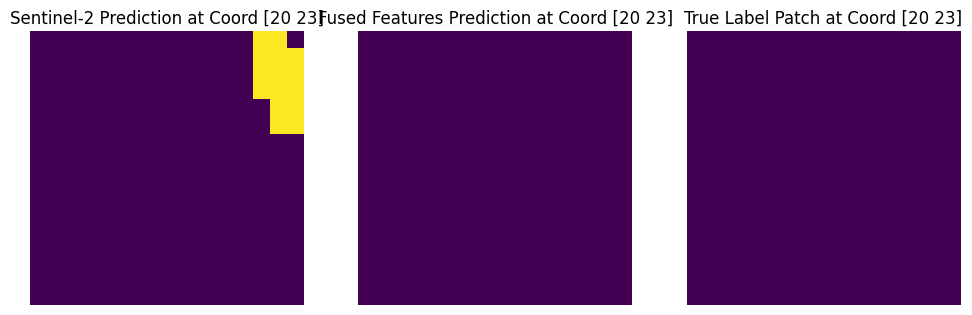

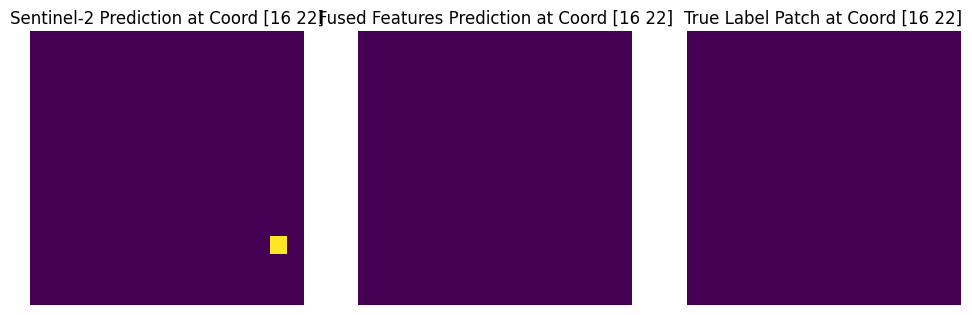

Visualizing Slum Patches in Validation Set


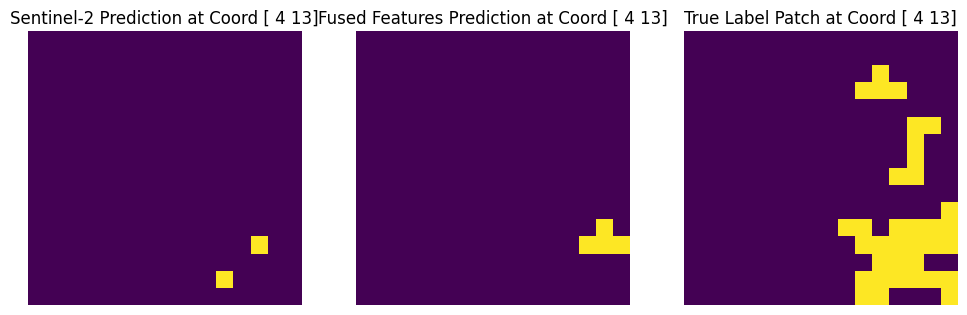

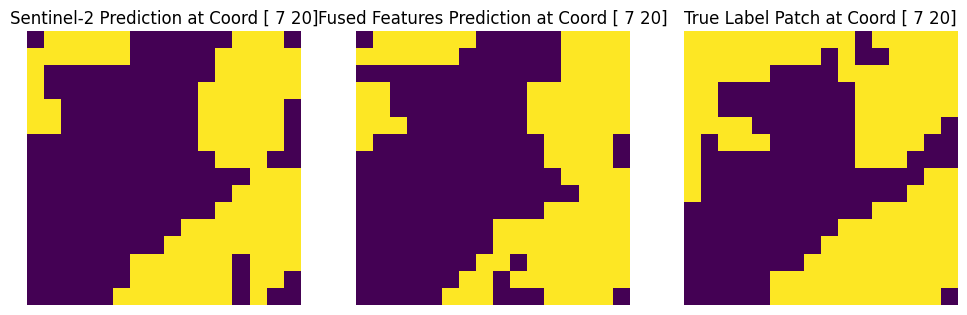

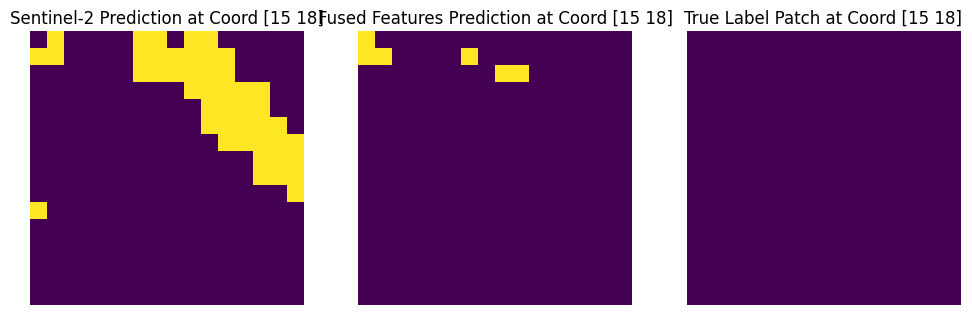

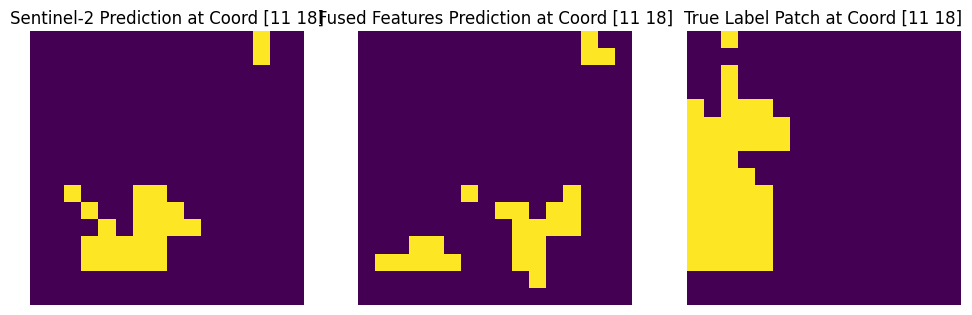

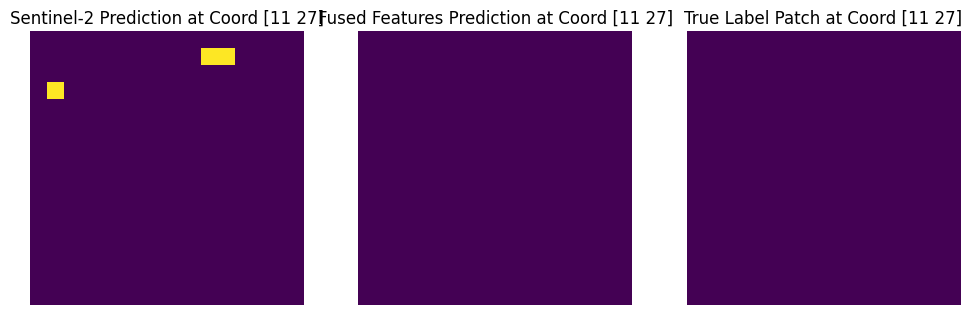

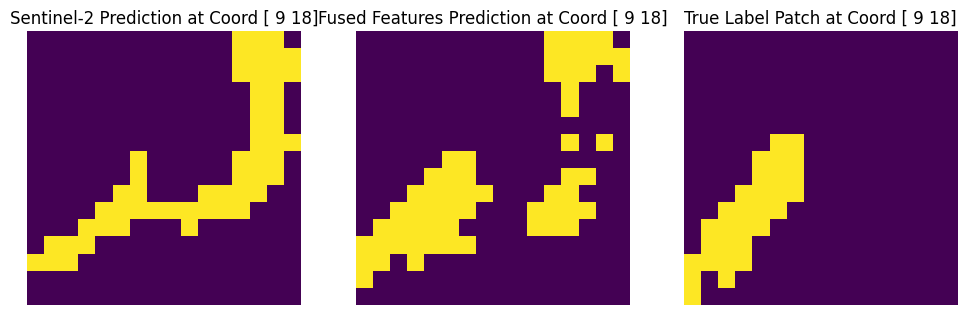

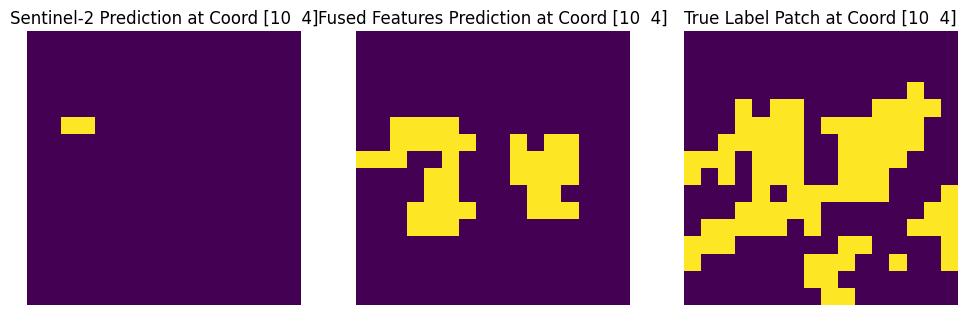

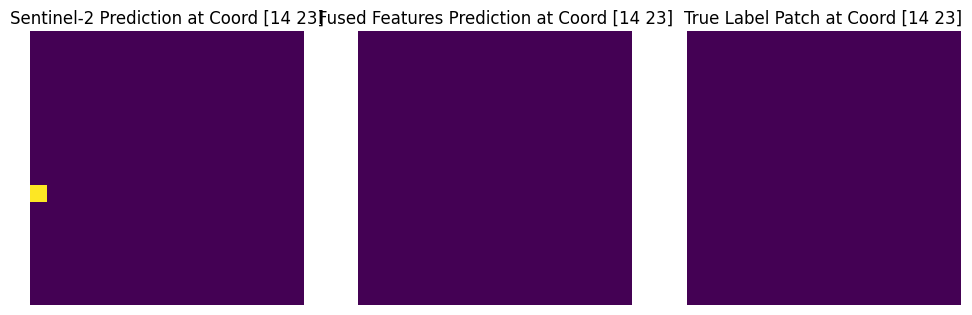

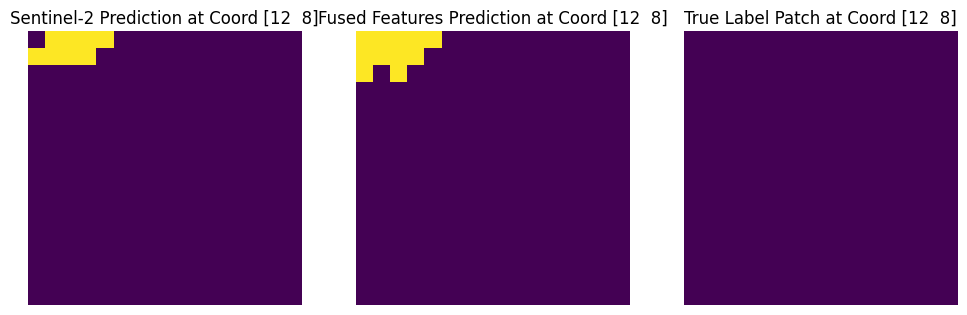

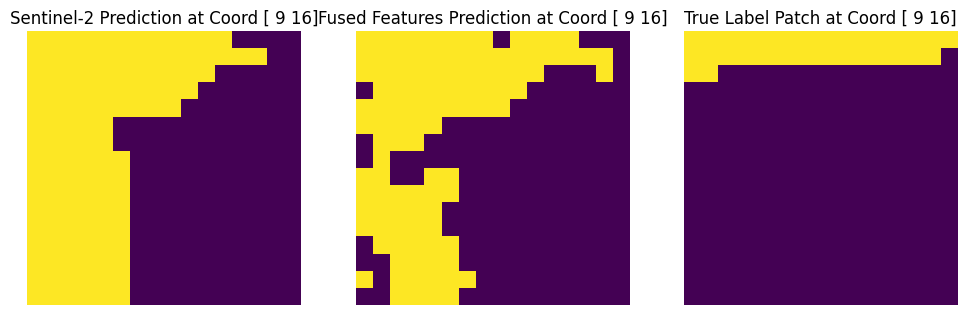

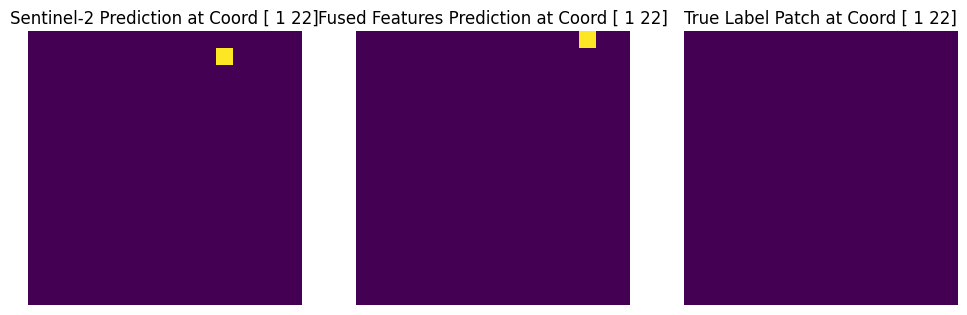

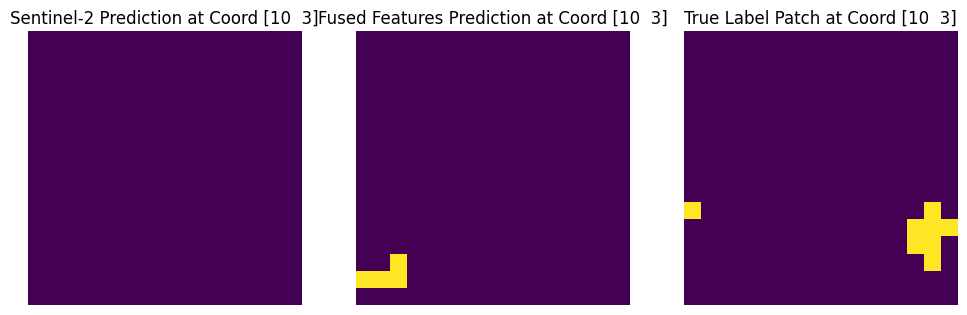

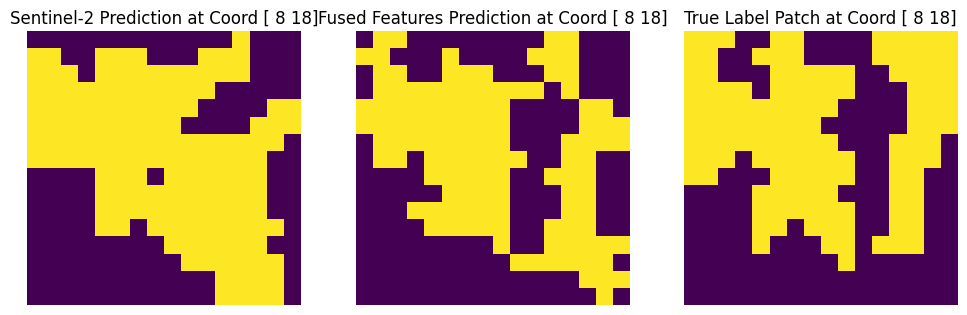

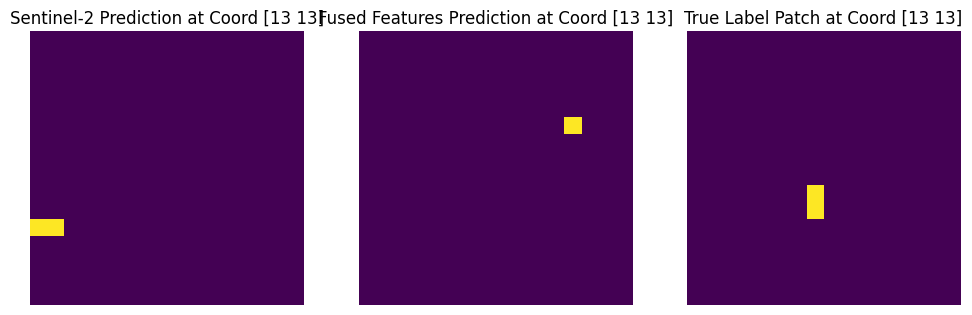

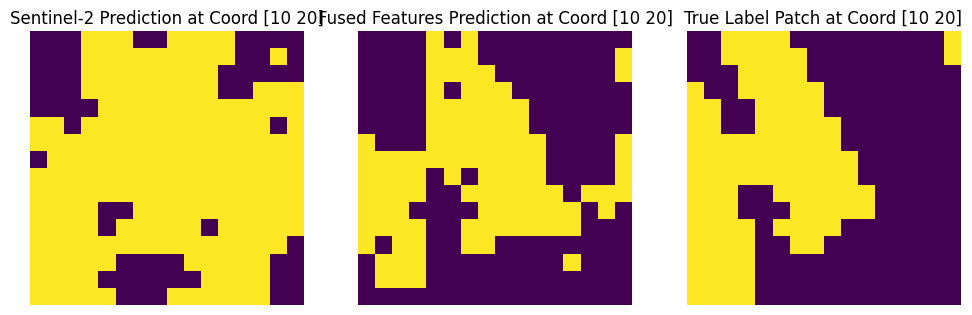

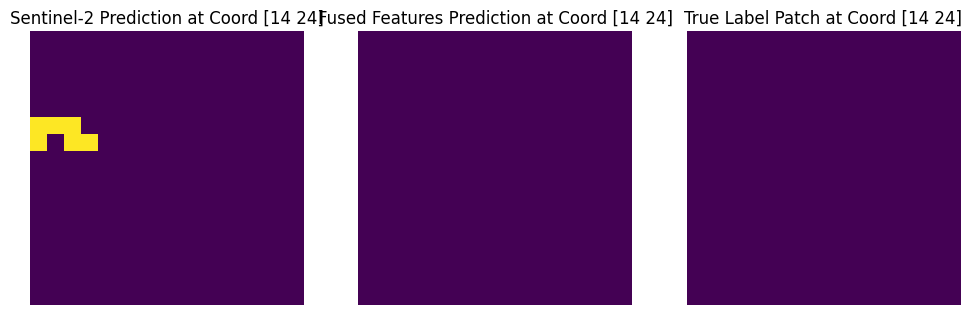

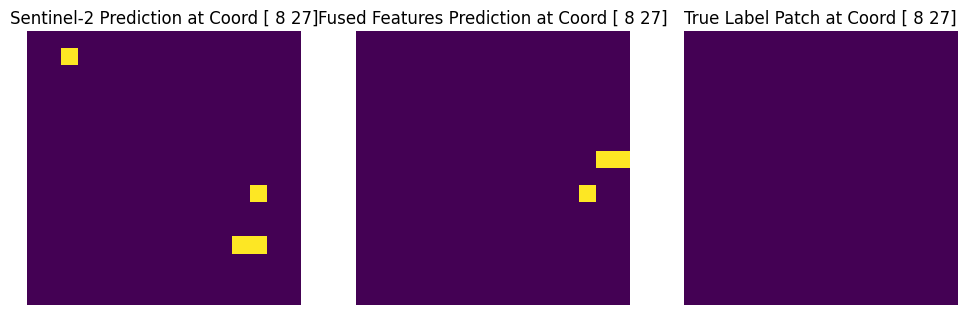

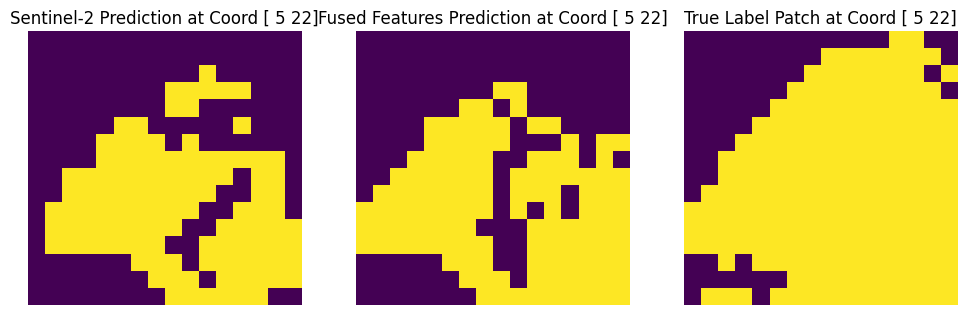

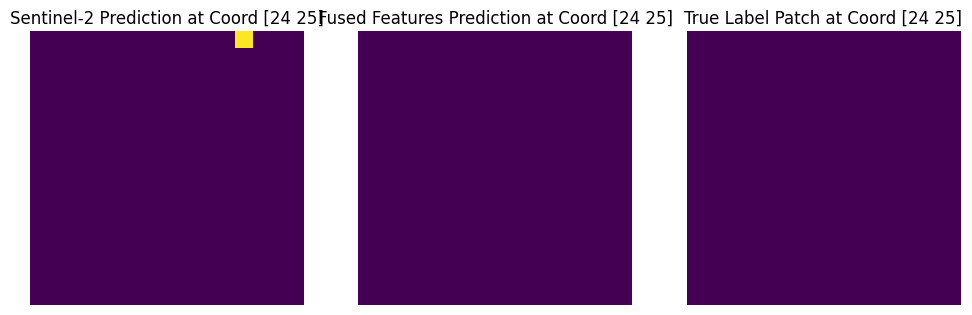

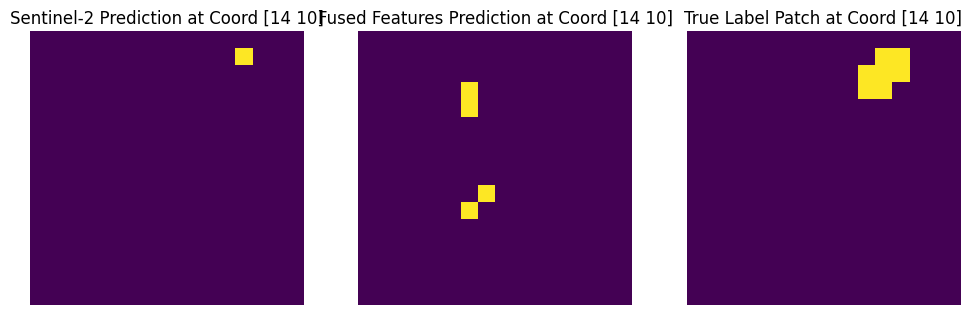

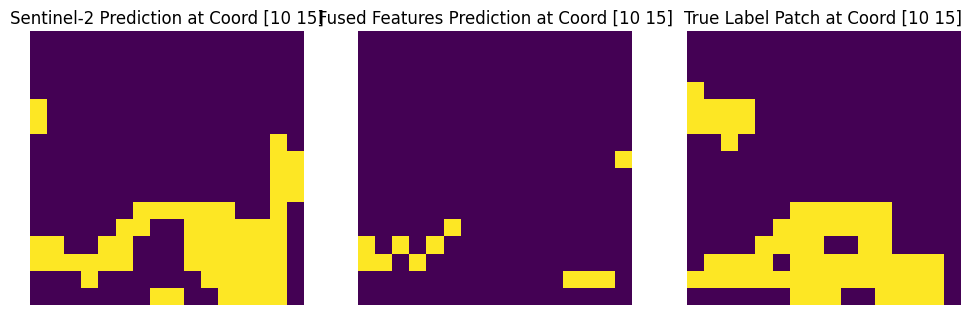

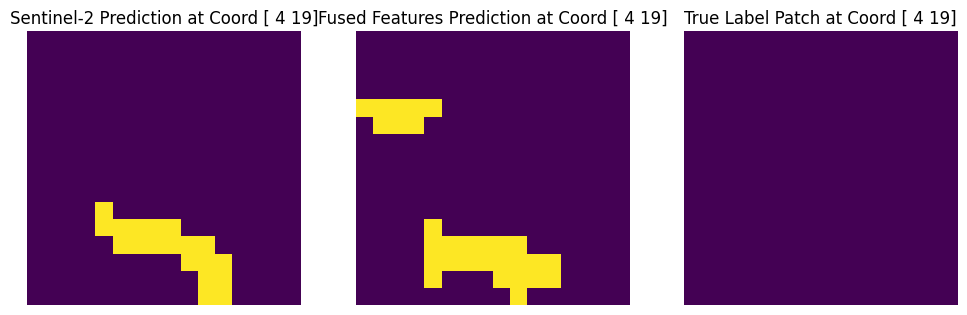

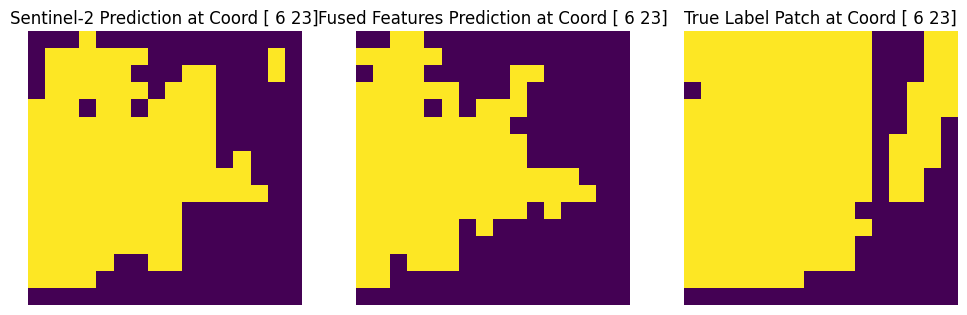

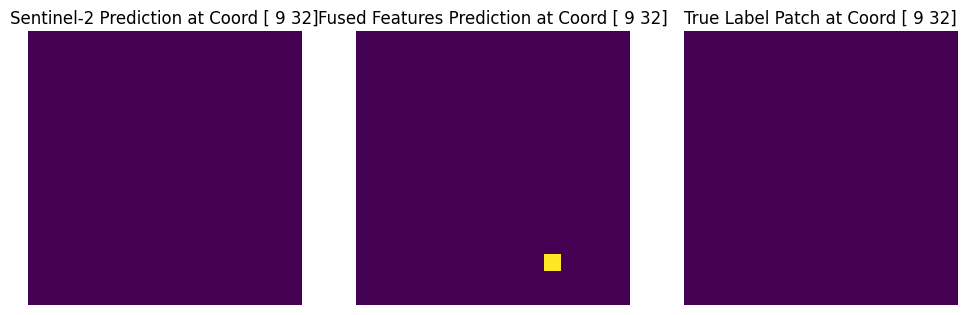

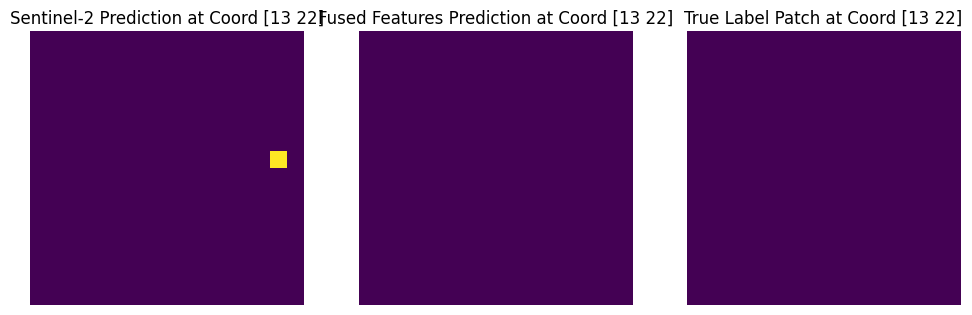

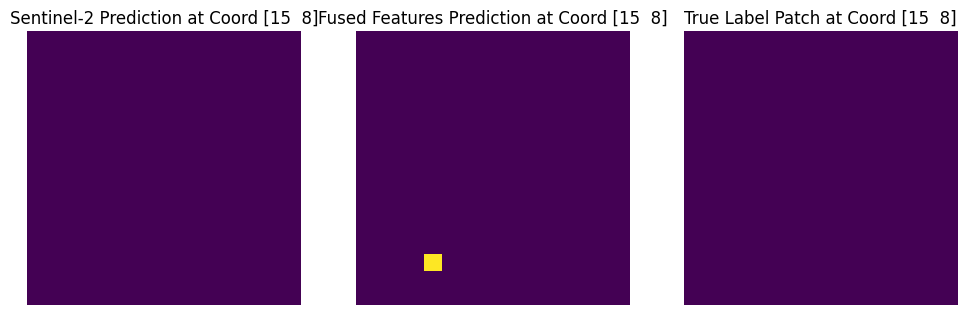

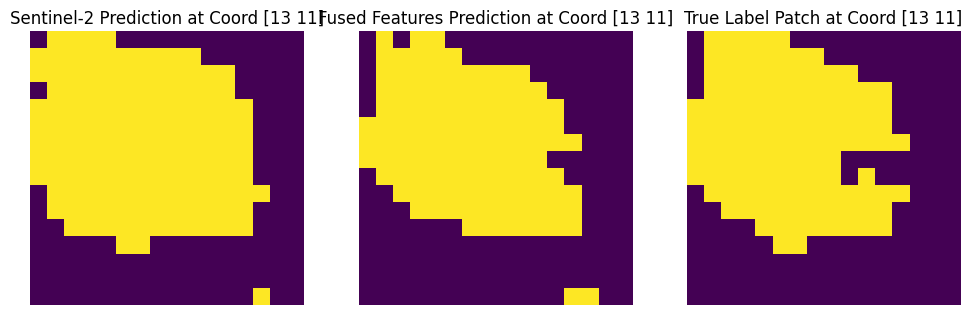

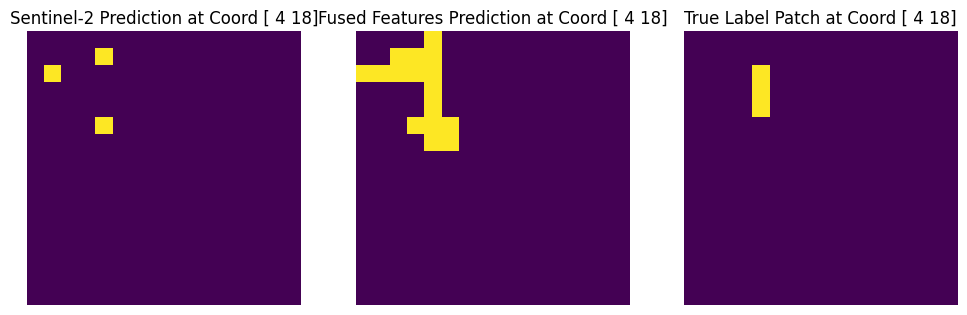

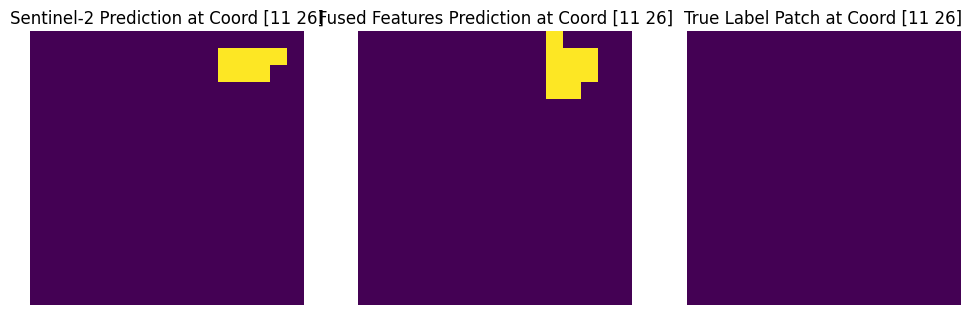

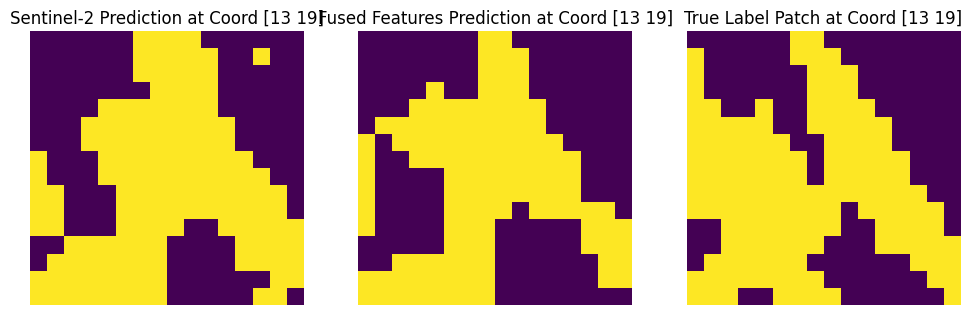

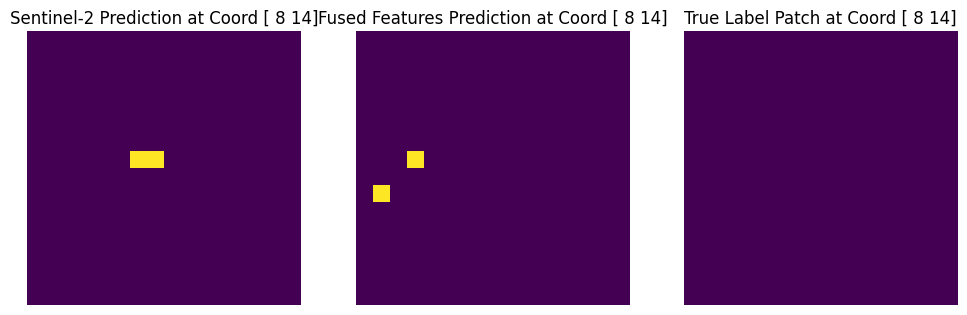

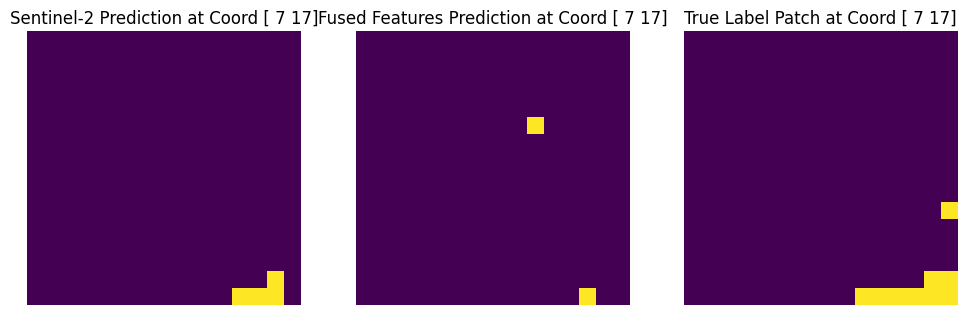

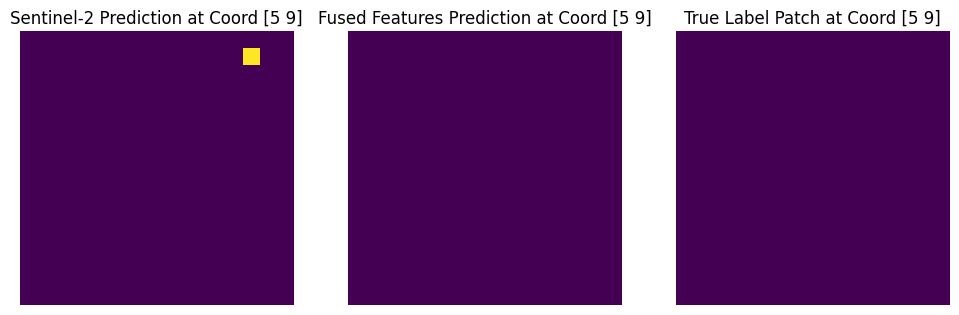

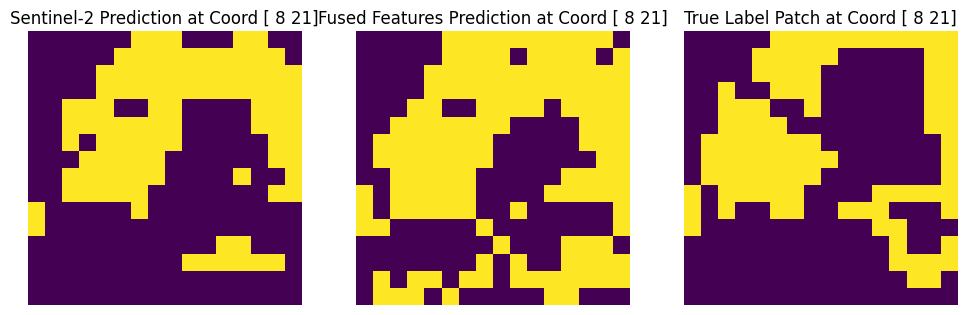

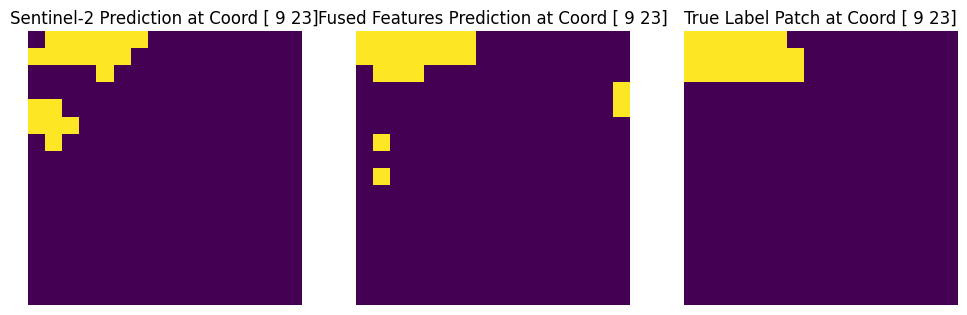

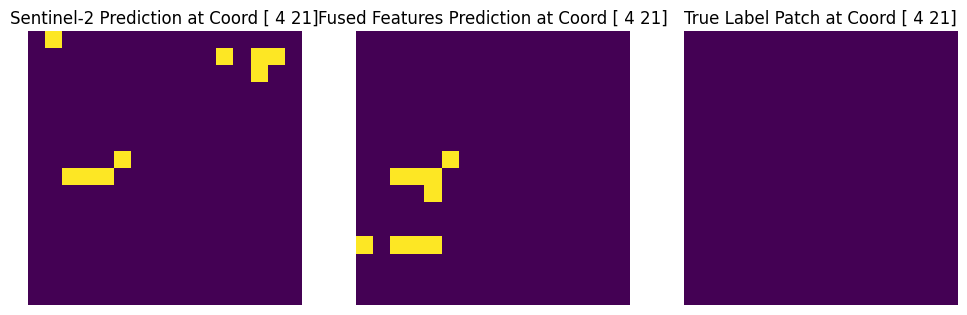

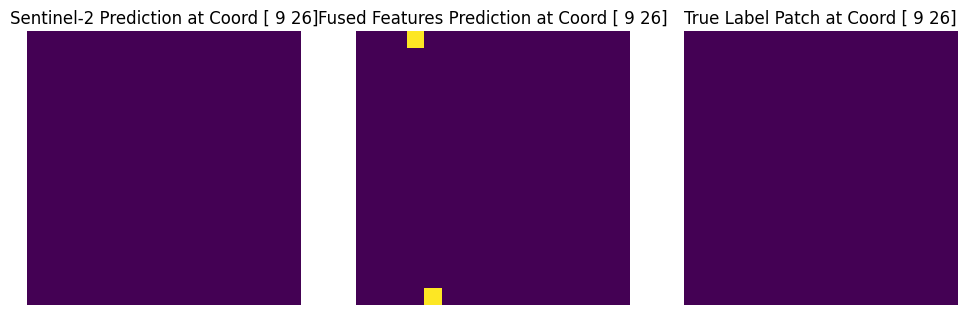

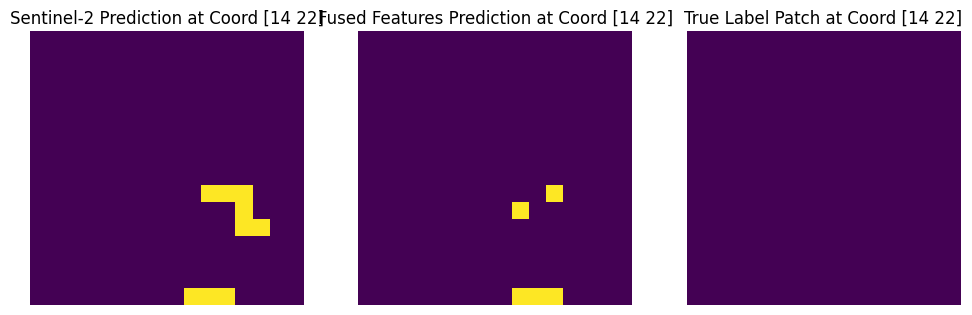

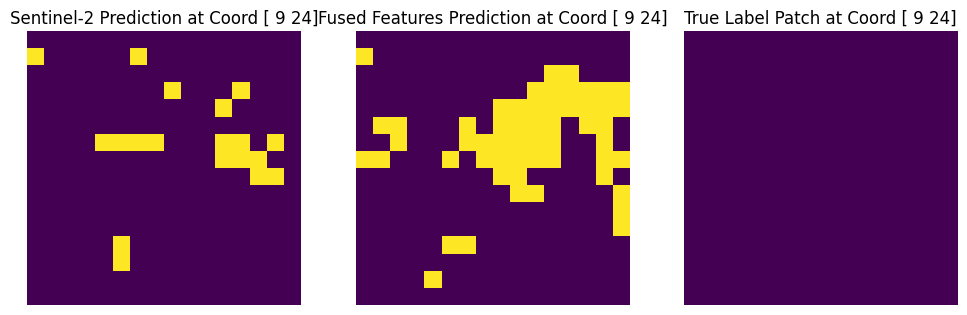

Visualizing Slum Patches in Test Set


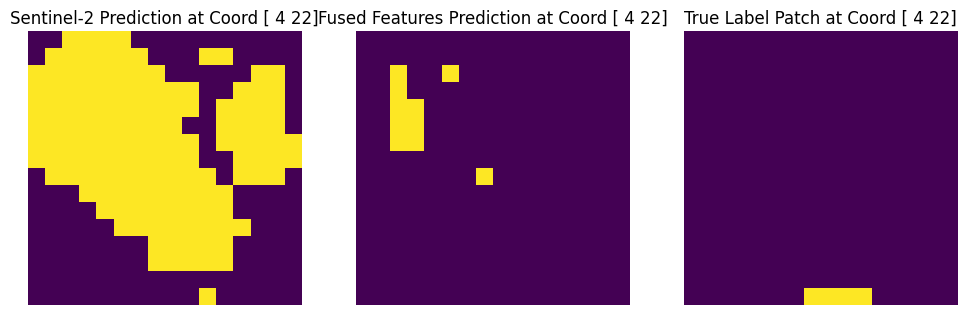

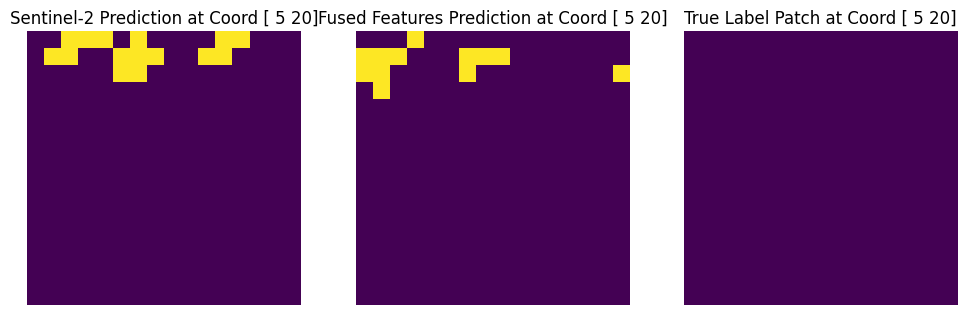

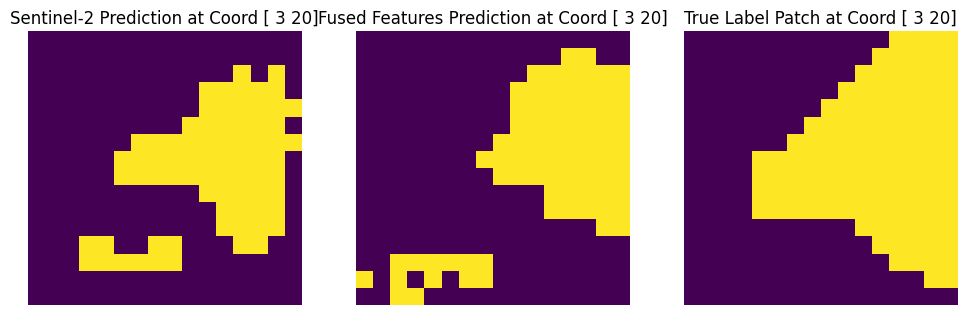

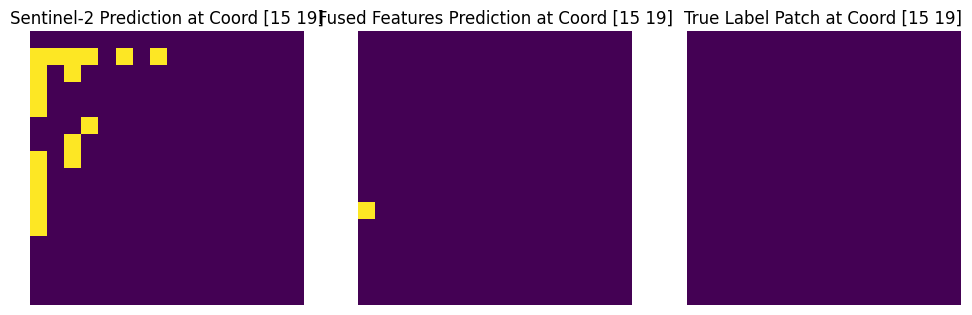

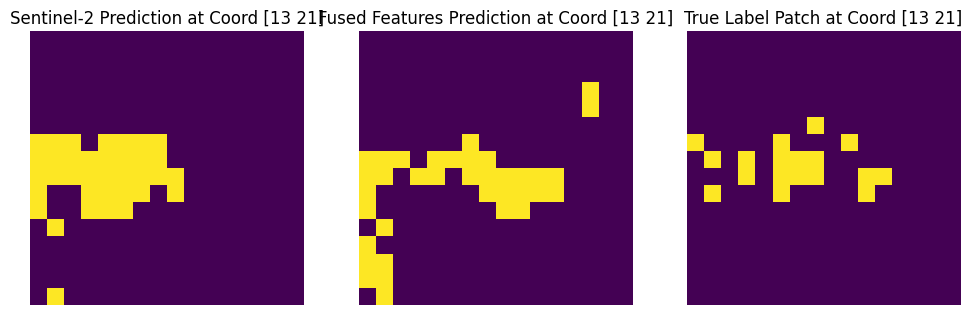

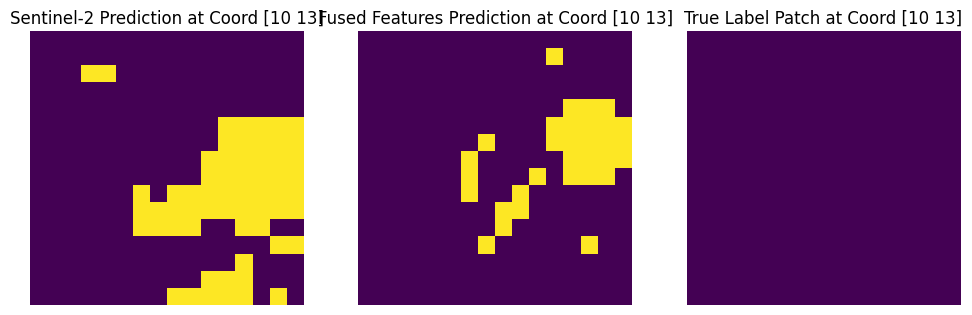

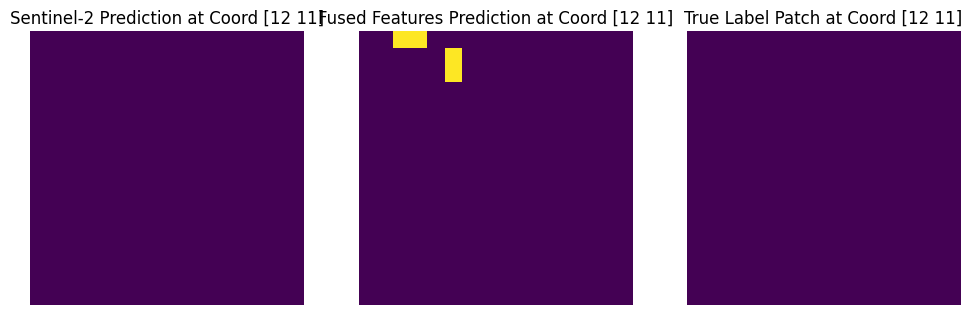

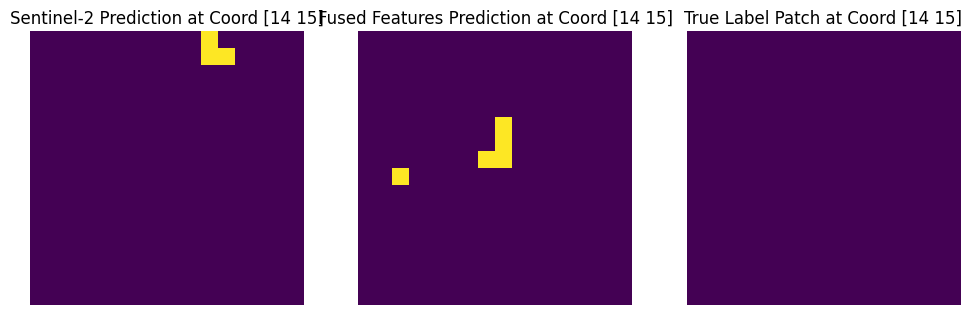

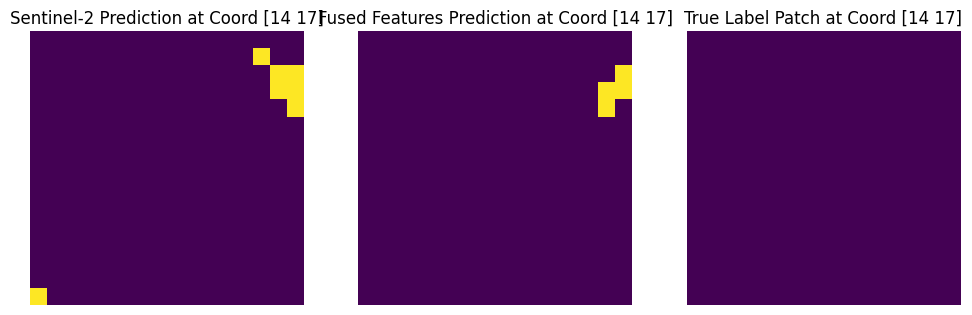

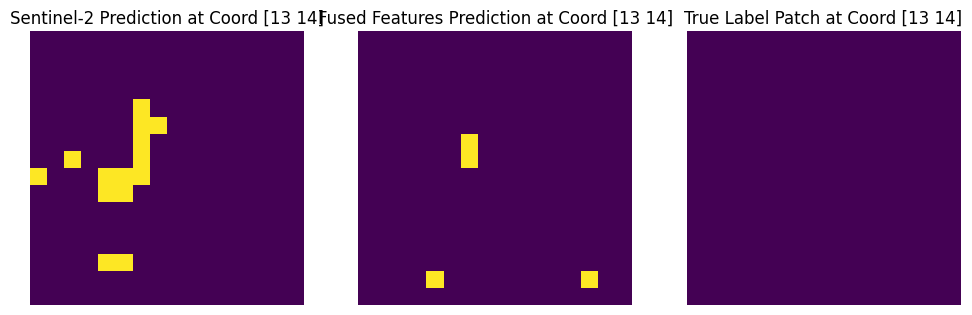

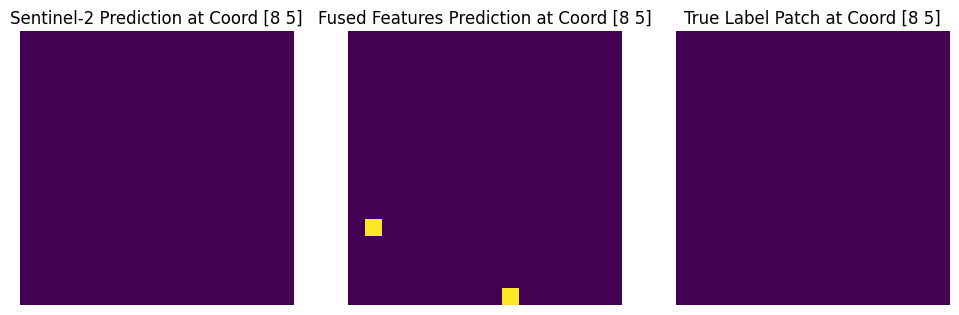

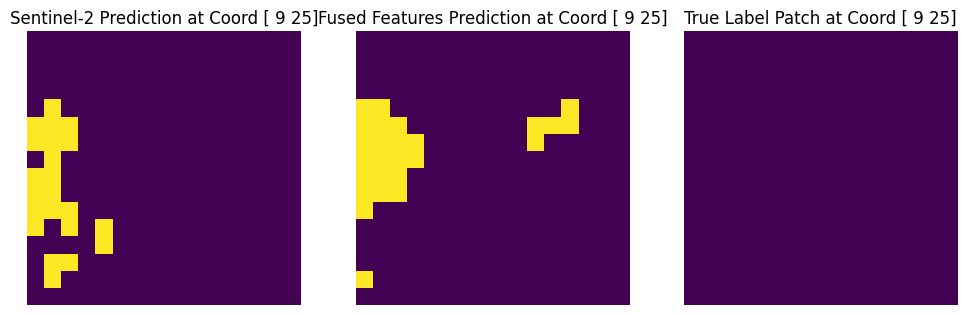

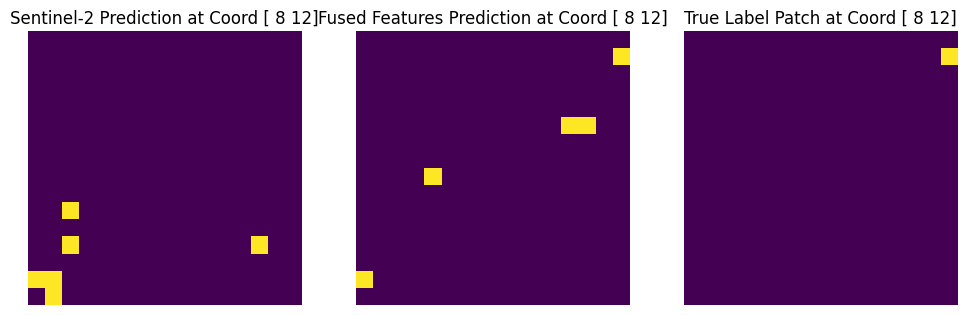

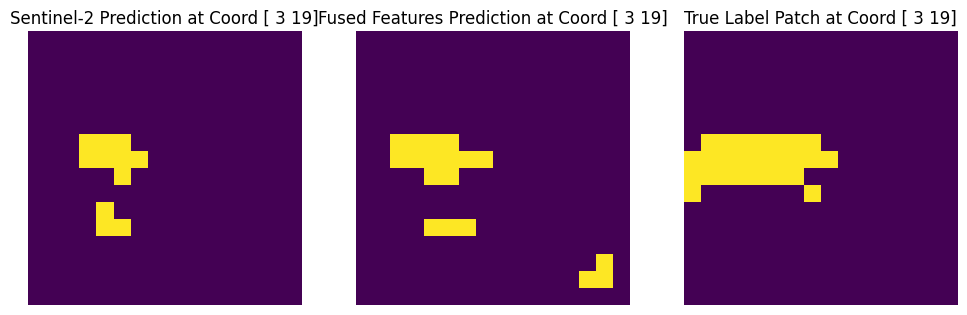

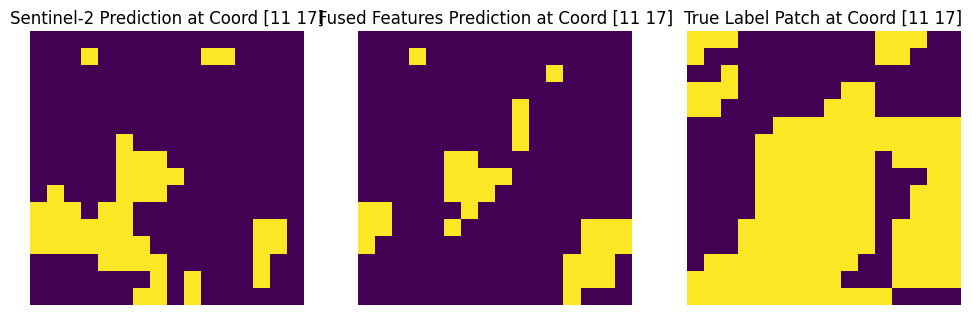

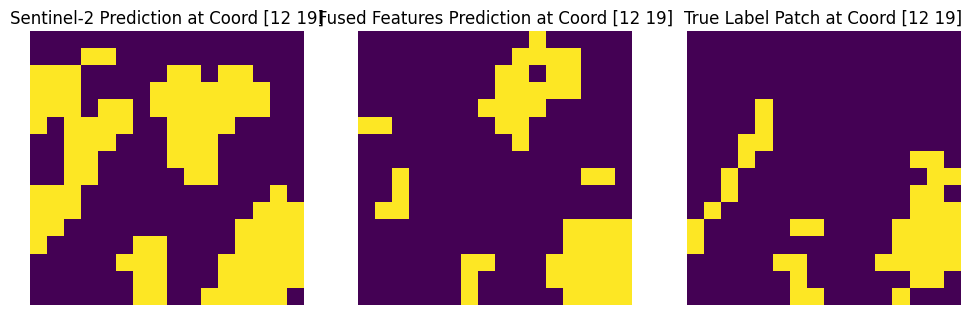

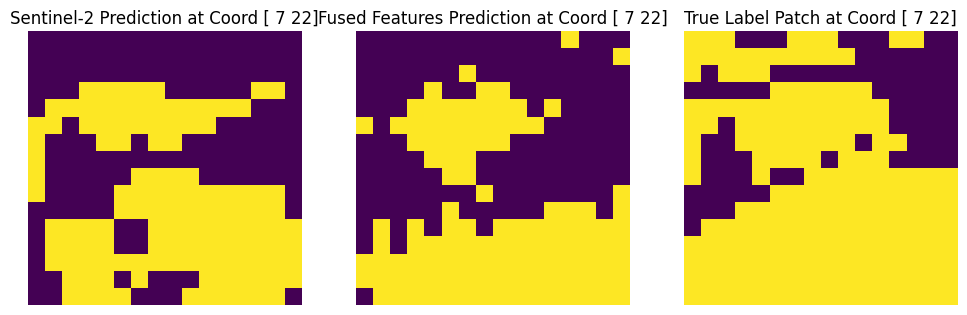

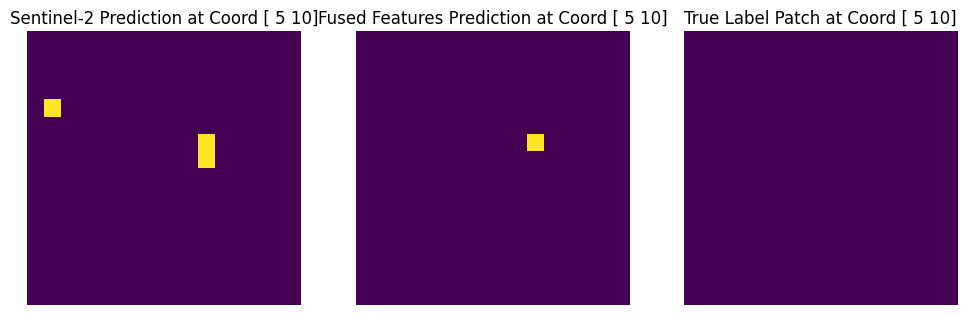

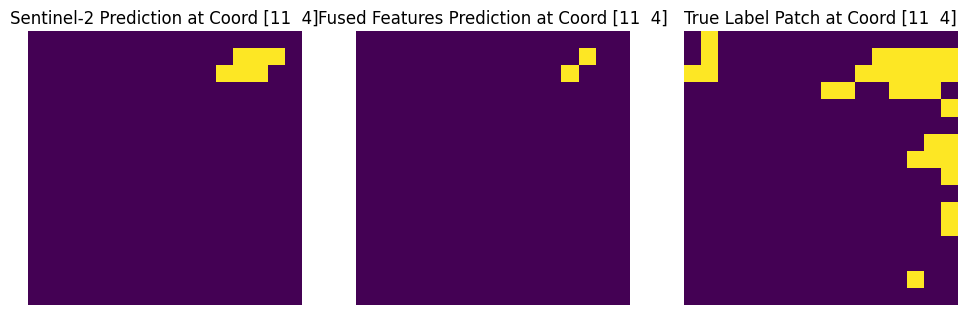

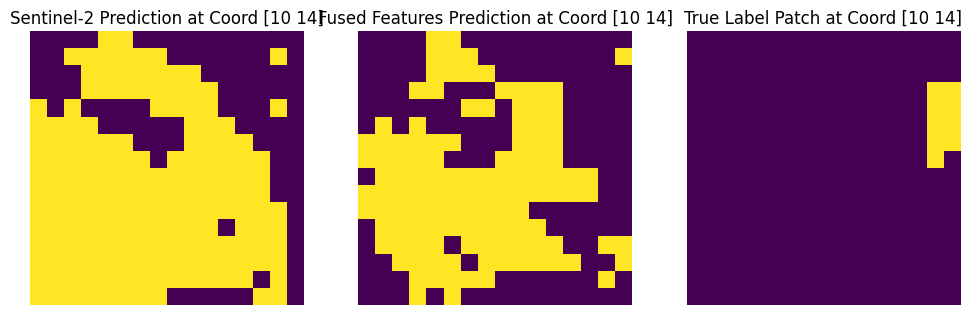

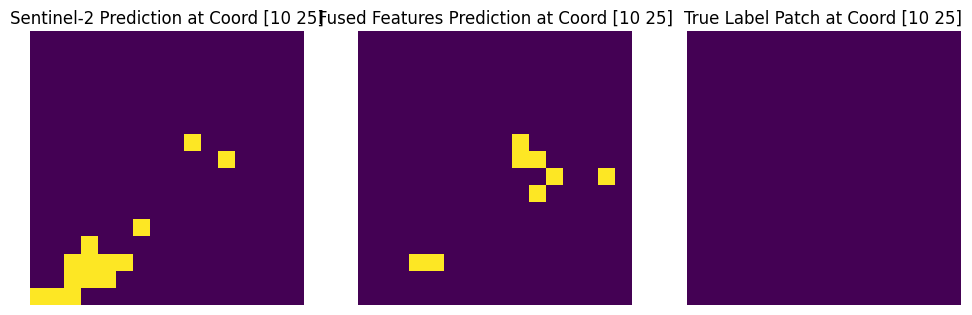

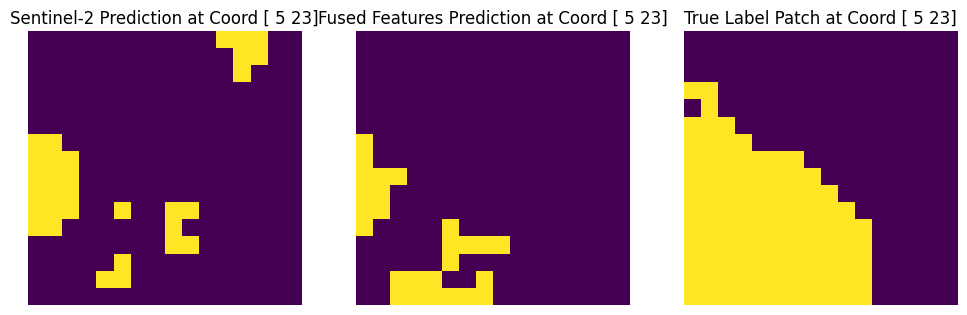

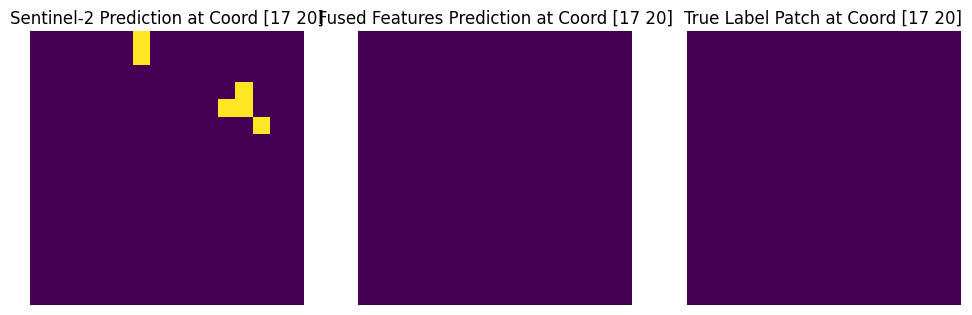

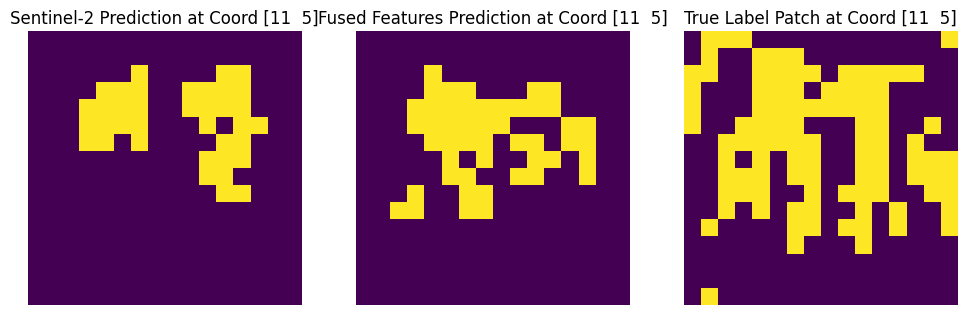

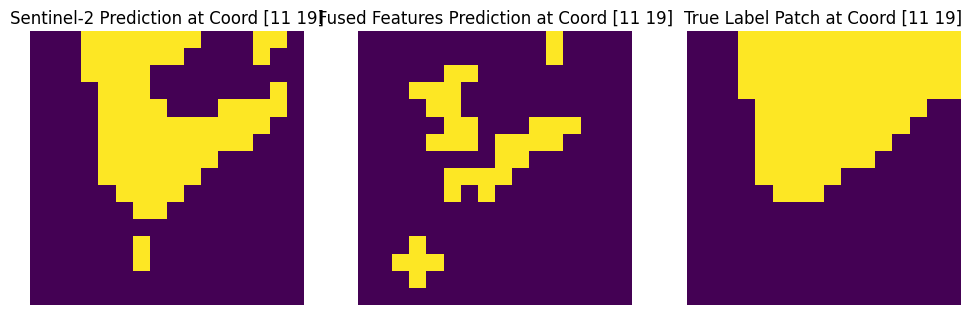

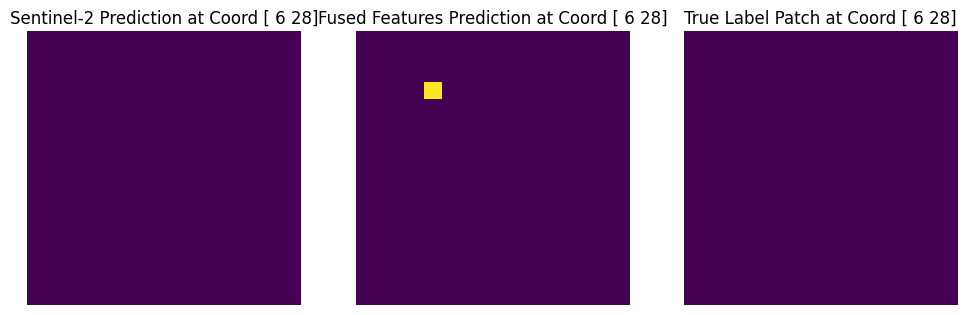

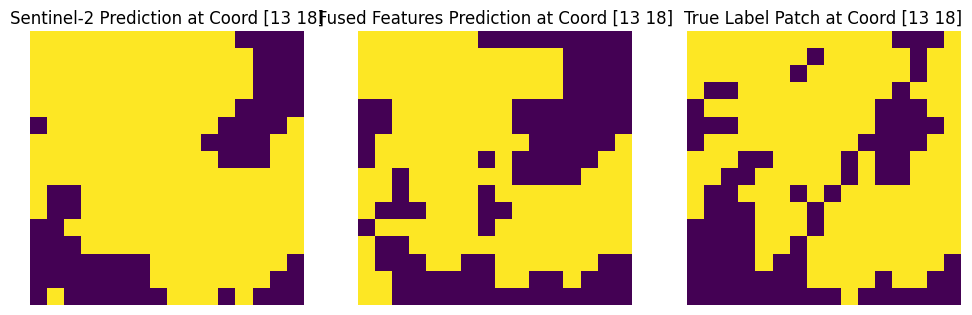

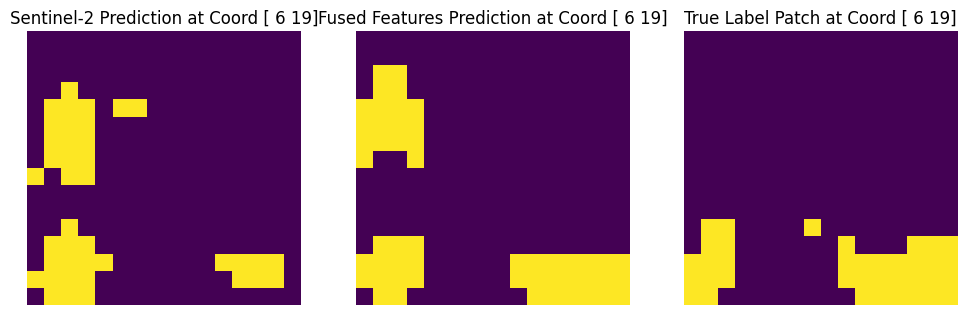

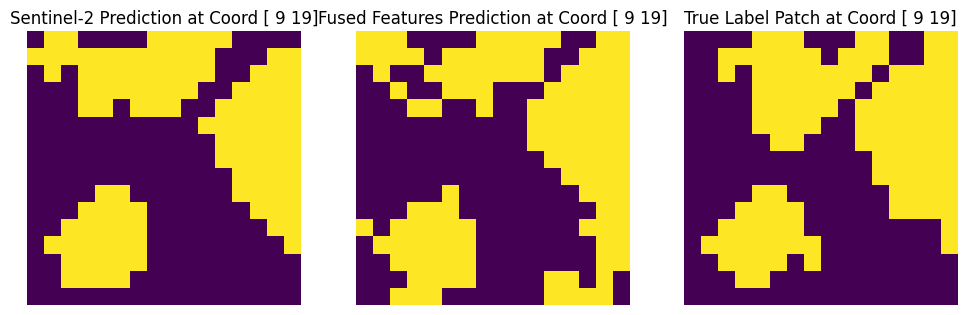

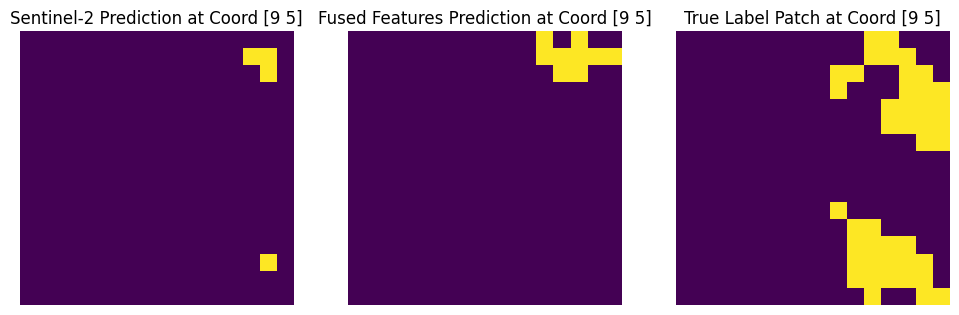

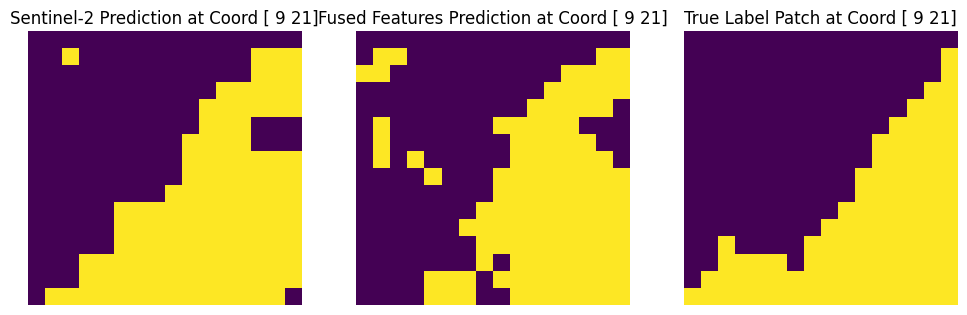

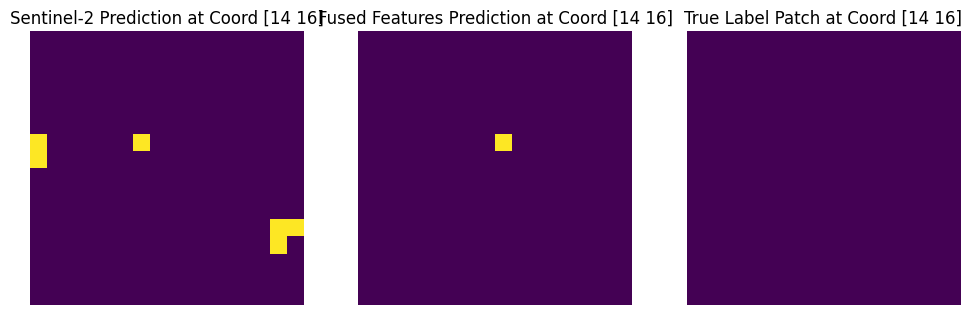

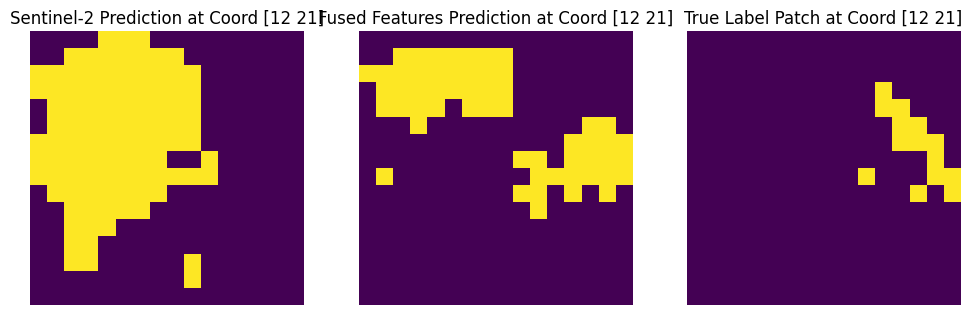

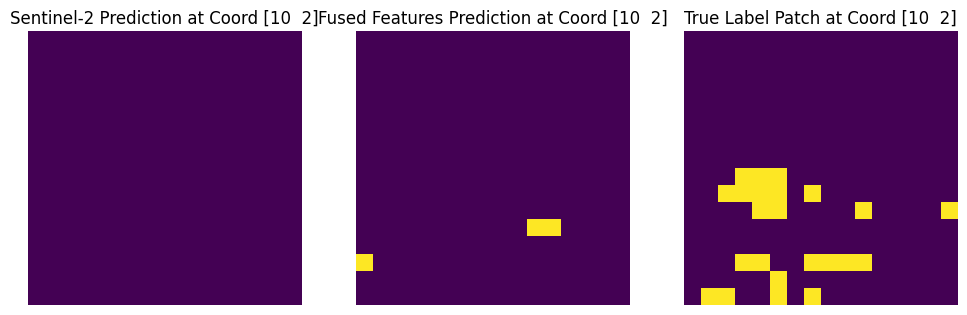

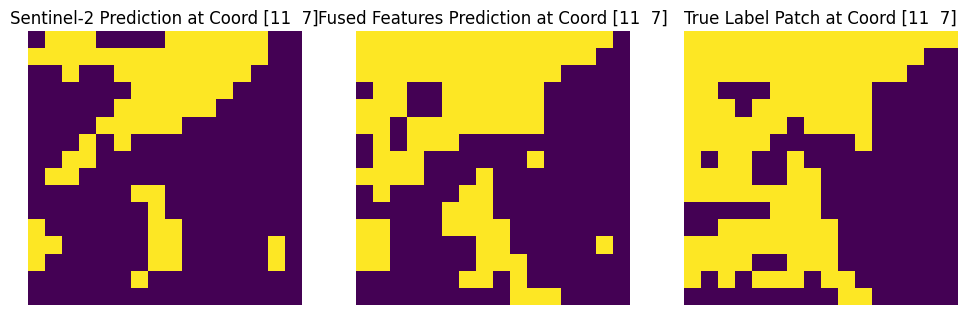

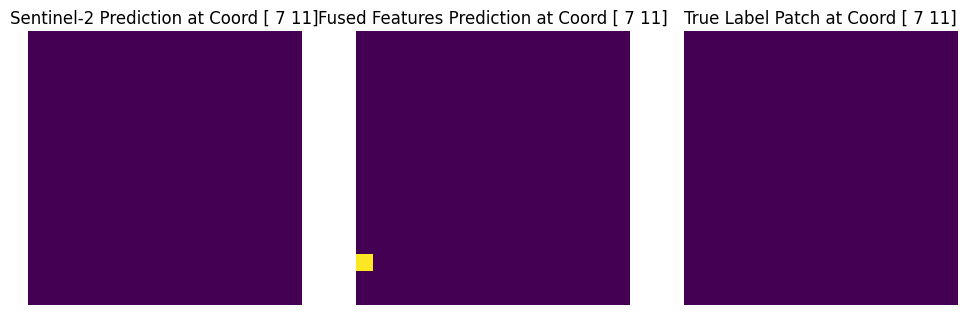

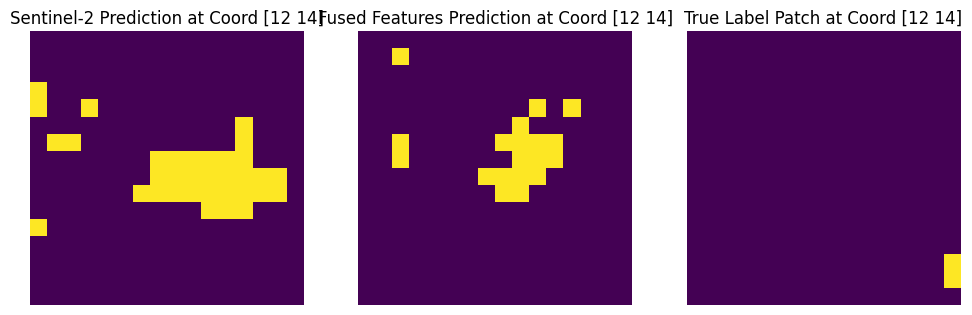

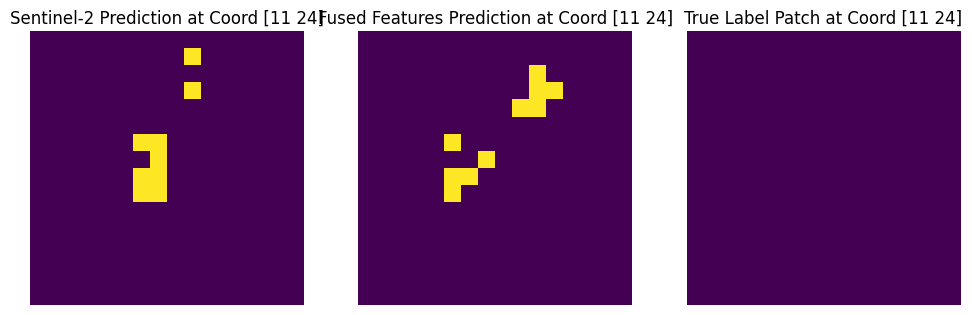

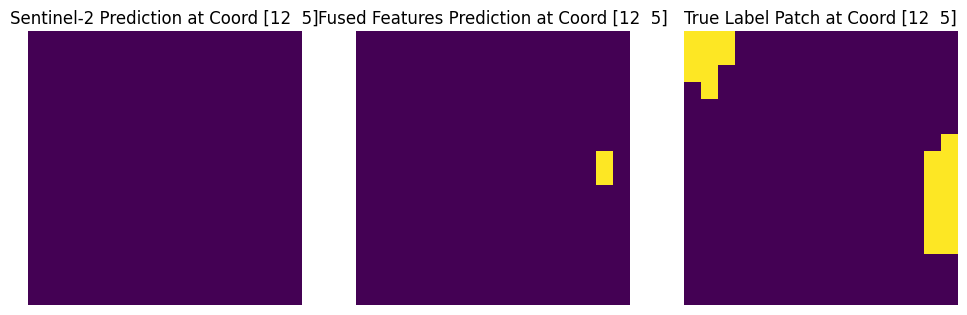

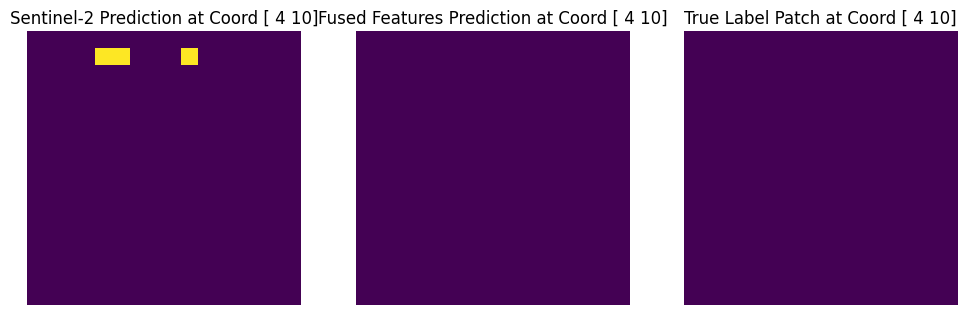

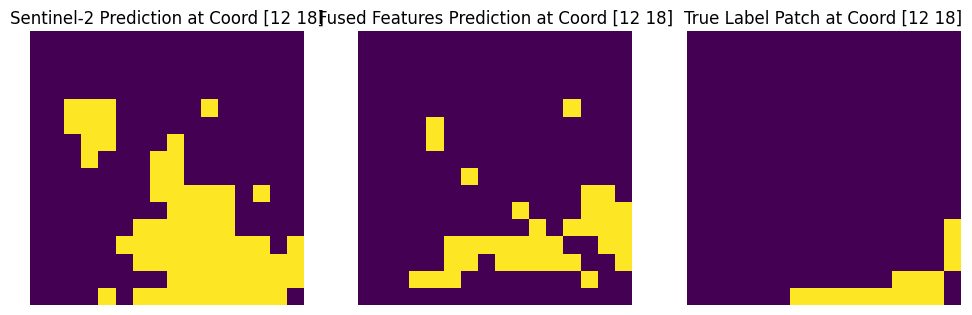

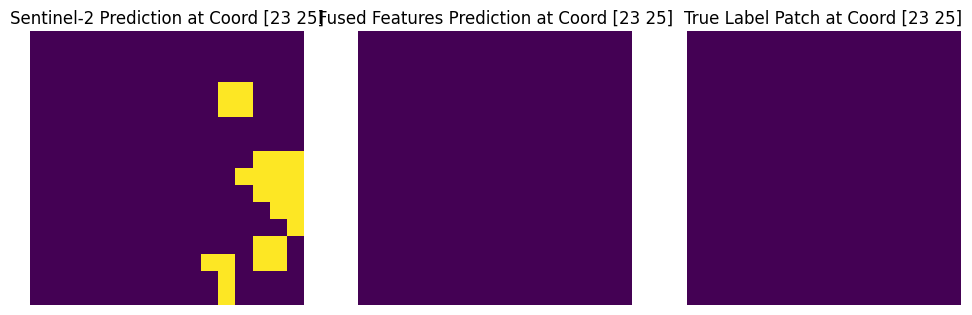

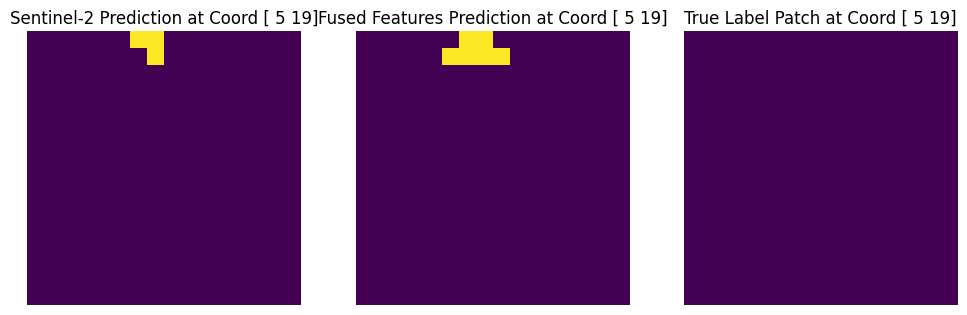

In [191]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_slum_patches_comparison(pred_s2_classes, pred_fused_classes, true_classes, coords, slum_class=1):
    """
    可视化每个包含贫民窟区域的16x16 patch及其对应的真实标签，同时显示Sentinel-2和Fused Features的预测结果。

    :param pred_s2_classes: Sentinel-2 模型预测的类别 (3D array, e.g., (num_patches, 16, 16))
    :param pred_fused_classes: Fused Features 模型预测的类别 (3D array, e.g., (num_patches, 16, 16))
    :param true_classes: 真实类别 (3D array, e.g., (num_patches, 16, 16))
    :param coords: 每个patch的位置坐标 (2D array, e.g., (num_patches, 2))
    :param slum_class: 贫民窟类别的标签 (默认为 1)
    """
    num_patches = pred_s2_classes.shape[0]
    
    for i in range(num_patches):
        s2_patch = pred_s2_classes[i]
        fused_patch = pred_fused_classes[i]
        true_patch = true_classes[i]
        
        # 检查patch中是否包含贫民窟类别
        if np.any(s2_patch == slum_class) or np.any(fused_patch == slum_class):
            plt.figure(figsize=(12, 4))

            # 可视化Sentinel-2模型的预测结果
            plt.subplot(1, 3, 1)
            plt.imshow(s2_patch, cmap='viridis')
            plt.title(f"Sentinel-2 Prediction at Coord {coords[i]}")
            plt.axis('off')

            # 可视化Fused Features模型的预测结果
            plt.subplot(1, 3, 2)
            plt.imshow(fused_patch, cmap='viridis')
            plt.title(f"Fused Features Prediction at Coord {coords[i]}")
            plt.axis('off')

            # 可视化对应的真实标签patch
            plt.subplot(1, 3, 3)
            plt.imshow(true_patch, cmap='viridis')
            plt.title(f"True Label Patch at Coord {coords[i]}")
            plt.axis('off')

            plt.show()

# 对训练、验证和测试集中的贫民窟patch进行可视化
print("Visualizing Slum Patches in Training Set")
visualize_slum_patches_comparison(s2_train_pred_classes, fused_train_pred_classes, s2_train_true_classes, train_coords, slum_class=1)

print("Visualizing Slum Patches in Validation Set")
visualize_slum_patches_comparison(s2_val_pred_classes, fused_val_pred_classes, s2_val_true_classes, val_coords, slum_class=1)

print("Visualizing Slum Patches in Test Set")
visualize_slum_patches_comparison(s2_test_pred_classes, fused_test_pred_classes, s2_test_true_classes, test_coords, slum_class=1)

In [156]:
def evaluate_block_predictions(y_test, y_pred_sentinel, y_pred_fused):

    # 将预测结果和真实标签转换为类别索引
    y_pred_sentinel_classes = np.argmax(y_pred_sentinel, axis=-1)
    y_pred_fused_classes = np.argmax(y_pred_fused, axis=-1)
    y_true_classes = np.argmax(y_test, axis=-1)
    
    print(y_pred_sentinel_classes.shape)
    print(y_pred_fused_classes.shape)
    print(y_true_classes.shape)

    improved = []
    unchanged = []
    degraded = []

    # 遍历每个像素
    for i in range(y_true_classes.shape[0]):
        for j in range(y_true_classes.shape[1]):
            for k in range(y_true_classes.shape[2]):
                correct_sentinel = y_pred_sentinel_classes[i, j, k] == y_true_classes[i, j, k]
                correct_fused = y_pred_fused_classes[i, j, k] == y_true_classes[i, j, k]

                if correct_fused and not correct_sentinel:
                    improved.append((i, j, k))
                elif correct_fused and correct_sentinel:
                    unchanged.append((i, j, k))
                elif not correct_fused and correct_sentinel:
                    degraded.append((i, j, k))

    return improved, unchanged, degraded


# 假设我们的模型预测和真实标签都已经准备好，并且具有正确的形状。
improved, unchanged, degraded = evaluate_block_predictions(labels_test, s2_test_predictions, fused_test_predictions)

# 输出结果
print(f"Improved blocks count: {len(improved)}")
print(f"Unchanged blocks count: {len(unchanged)}")
print(f"Degraded blocks count: {len(degraded)}")

(102, 16, 16)
(102, 16, 16)
(102, 16, 16)
Improved blocks count: 755
Unchanged blocks count: 24018
Degraded blocks count: 427


Visualizing an Improved Example in Slum Area:


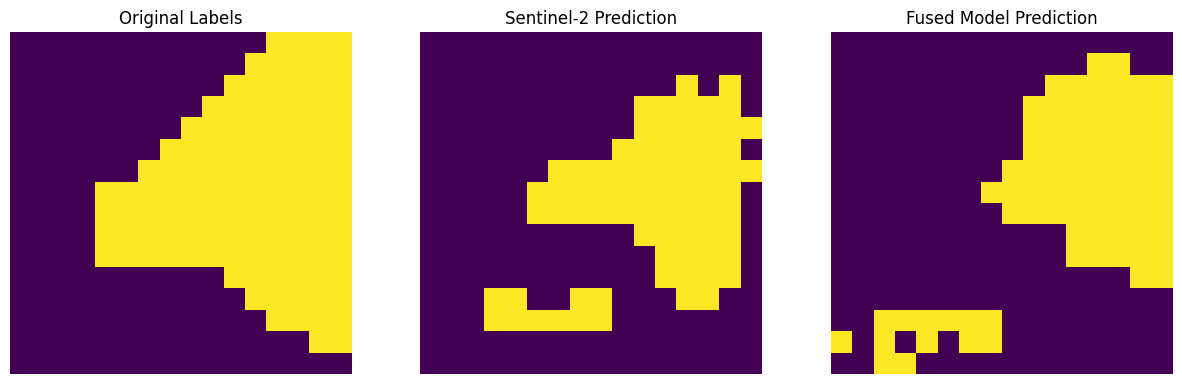

Visualizing an Unchanged Example in Slum Area:


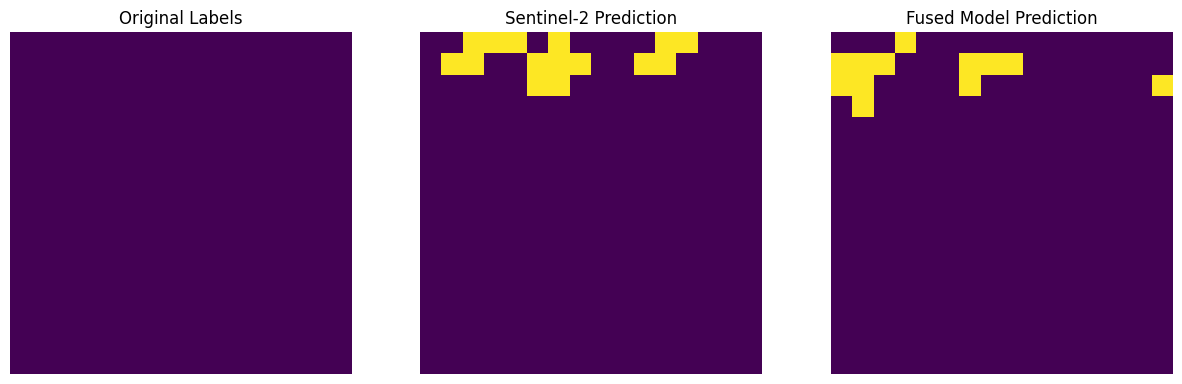

Visualizing a Degraded Example in Slum Area:


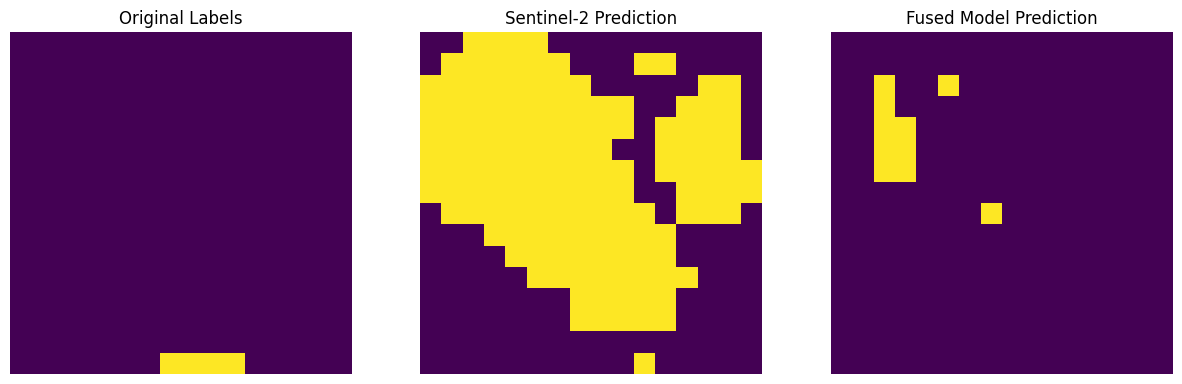

In [170]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_category(index, labels, s2_preds, fused_preds):
    """
    可视化特定分类的比较图。
    """
    # 获取数据
    label_img = labels[index]
    s2_img = s2_preds[index]
    fused_img = fused_preds[index]

    # 创建图形
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # 显示原始标签
    axs[0].imshow(np.argmax(label_img, axis=-1), cmap='viridis')
    axs[0].set_title('Original Labels')
    axs[0].axis('off')

    # 显示Sentinel-2预测
    axs[1].imshow(np.argmax(s2_img, axis=-1), cmap='viridis')
    axs[1].set_title('Sentinel-2 Prediction')
    axs[1].axis('off')

    # 显示融合模型预测
    axs[2].imshow(np.argmax(fused_img, axis=-1), cmap='viridis')
    axs[2].set_title('Fused Model Prediction')
    axs[2].axis('off')

    plt.show()

def filter_slum_examples(labels, category_indices):
    """
    过滤出位于贫民窟区域的示例。
    """
    slum_indices = []
    # 假设贫民窟的类别标签是1
    for idx in category_indices:
        i, j, k = idx
        if np.argmax(labels[i, j, k], axis=-1) == 1:  # 检查该像素是否标记为贫民窟
            slum_indices.append(idx)
    return slum_indices

# 假设improved, unchanged, degraded包含像素级的索引
# 过滤出位于贫民窟的示例
improved_slum = filter_slum_examples(labels_test, improved)
unchanged_slum = filter_slum_examples(labels_test, unchanged)
degraded_slum = filter_slum_examples(labels_test, degraded)

# 可视化
if improved_slum:
    print("Visualizing an Improved Example in Slum Area:")
    visualize_category(improved_slum[0][0], labels_test, s2_test_predictions, fused_test_predictions)

if unchanged_slum:
    print("Visualizing an Unchanged Example in Slum Area:")
    visualize_category(unchanged_slum[0][1], labels_test, s2_test_predictions, fused_test_predictions)

if degraded_slum:
    print("Visualizing a Degraded Example in Slum Area:")
    visualize_category(degraded_slum[0][0], labels_test, s2_test_predictions, fused_test_predictions)

In [110]:
fused_results = fused_model.evaluate(fused_features_test, labels_test)
print(f"\nTest Loss: {fused_results[0]:.4f}")
print(f"Test Accuracy: {fused_results[1] * 100:.2f}%")
print(f"F1 Score: {fused_results[2]:.4f}")  # F1Score 类的结果
print(f"Mean IoU: {fused_results[3]:.4f}")  # MeanIoU 的结果

4/4 [==============================] - 0s 21ms/step - loss: 0.0097 - accuracy: 0.9426 - f1_score: 0.5987 - mean_io_u_20: 0.2502

Test Loss: 0.0097
Test Accuracy: 94.26%
F1 Score: 0.5987
Mean IoU: 0.2502


4/4 [==============================] - 0s 16ms/step
Overall Classification Report on Fused Features:
              precision    recall  f1-score   support

    Non-slum       0.97      0.99      0.98    123154
        Slum       0.66      0.48      0.56      7406

    accuracy                           0.96    130560
   macro avg       0.82      0.73      0.77    130560
weighted avg       0.95      0.96      0.95    130560

Confusion Matrix on Fused Features
[[121360   1794]
 [  3860   3546]]


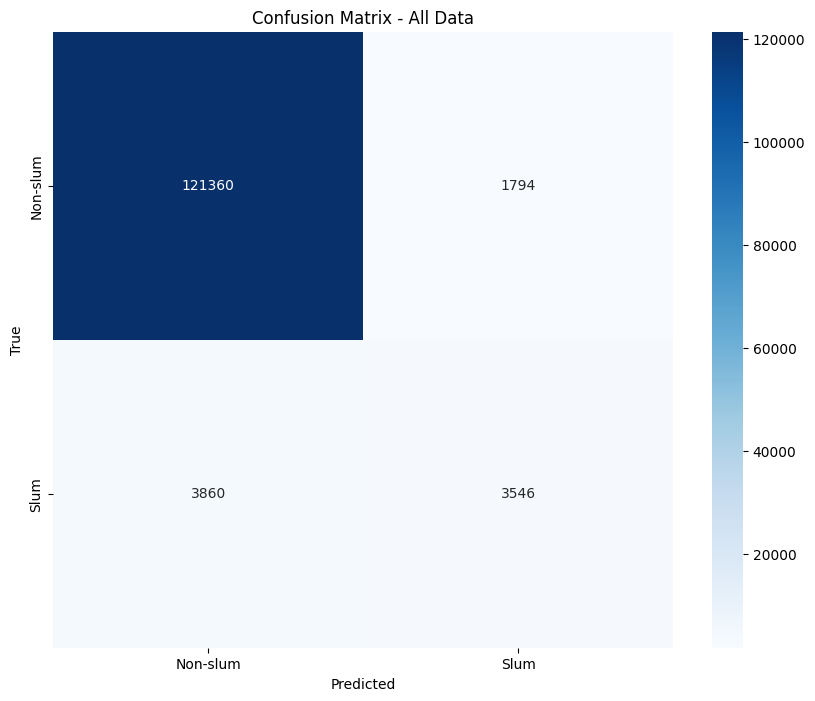

In [111]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 获取预测结果
fused_train_predictions = fused_model.predict(fused_features_train)
fused_val_predictions = fused_model.predict(fused_features_val)
fused_test_predictions = fused_model.predict(fused_features_test)

# 获取预测类别
fused_train_pred_classes = np.argmax(fused_train_predictions, axis=-1).flatten()
fused_val_pred_classes = np.argmax(fused_val_predictions, axis=-1).flatten()
fused_test_pred_classes = np.argmax(fused_test_predictions, axis=-1).flatten()

# 获取真实类别
fused_train_true_classes = np.argmax(labels_train, axis=-1).flatten()
fused_val_true_classes = np.argmax(labels_val, axis=-1).flatten()
fused_test_true_classes = np.argmax(labels_test, axis=-1).flatten()

# 组合所有预测结果和真实标签
fused_all_pred_classes = np.concatenate([fused_train_pred_classes, fused_val_pred_classes, fused_test_pred_classes], axis=0)
fused_all_true_classes = np.concatenate([fused_train_true_classes, fused_val_true_classes, fused_test_true_classes], axis=0)

# 计算整体混淆矩阵
fused_overall_cm = confusion_matrix(fused_all_true_classes, fused_all_pred_classes)

# 输出整体分类报告
class_labels = ['Non-slum', 'Slum']
fused_overall_report = classification_report(fused_all_true_classes, fused_all_pred_classes, target_names=class_labels, zero_division=1)
print("Overall Classification Report on Fused Features:")
print(fused_overall_report)

print("Confusion Matrix on Fused Features")
print(fused_overall_cm)


# 可视化整体混淆矩阵
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - All Data')
    plt.show()


plot_confusion_matrix(fused_overall_cm)